In [ ]:
import datetime as dt
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
import requests
from io import BytesIO
from zipfile import ZipFile
from datetime import datetime
from scipy.optimize import minimize
from scipy.stats import gmean
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import riskfolio as rp
import warnings

# Set visual styles for plotting
sns.set(style="whitegrid")
plt.style.use('ggplot')

# Configure warnings to ignore them
warnings.filterwarnings("ignore")


# Progetto Business Intelligence per i Servizi Finanziari 2023/2024

---


Richard Rabi, n° matricola 869353


In [ ]:
start_date = '2014-05-31'
end_date = '2024-05-31'

In [ ]:
tickers = ["AMZN", "MCD", "PG", "WMT", "AAPL", "NVDA"]

In [ ]:
adjusted_close_df  = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  6 of 6 completed


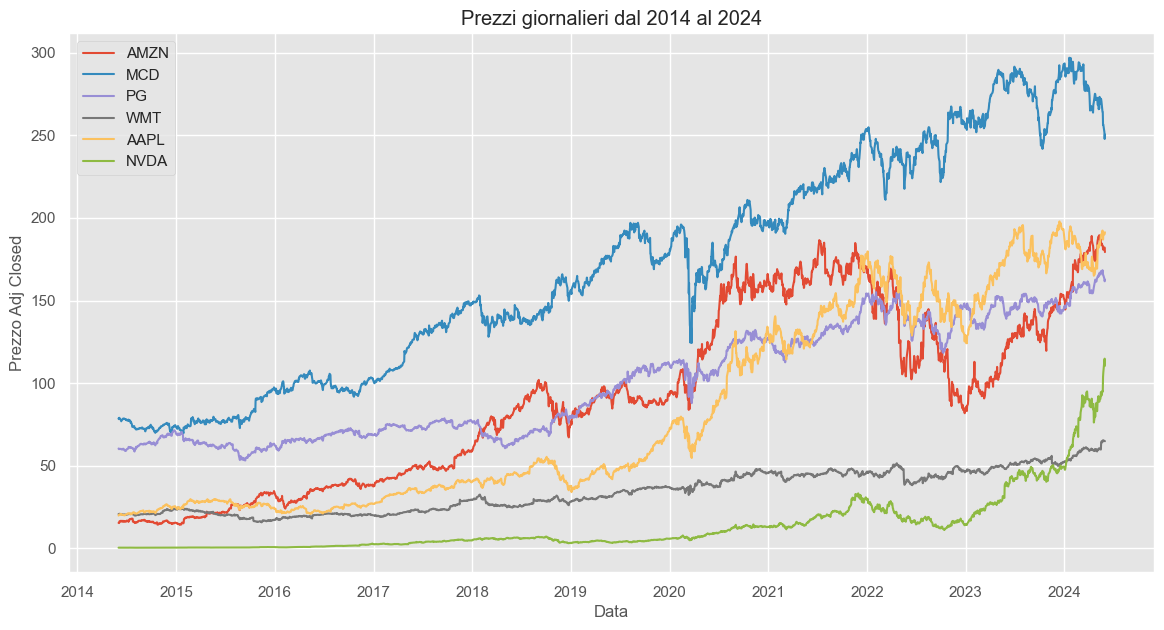

In [ ]:
adjusted_close_df.ffill(inplace=True)

# Creare il grafico
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(adjusted_close_df.index, adjusted_close_df[ticker], label=ticker)

plt.title('Prezzi giornalieri dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Prezzo Adj Closed')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
adjusted_close_df = adjusted_close_df.round(2)
adjusted_close_df.head()

Ticker       AAPL   AMZN    MCD  NVDA     PG    WMT
Date                                               
2014-06-02  19.89  15.44  78.68  0.45  60.44  20.80
2014-06-03  20.17  15.36  78.23  0.45  60.12  20.79
2014-06-04  20.40  15.34  78.99  0.45  60.06  20.90
2014-06-05  20.48  16.18  79.00  0.45  60.25  20.95
2014-06-06  20.42  16.48  78.62  0.45  60.19  20.92

#2. Statistiche descrittive

a. Calcolare il rendimento cumulato e composto annuo di ciascun titolo nel periodo;

In [ ]:
# Calcolo dei ritorni giornalieri
daily_returns = adjusted_close_df.pct_change()

# Calcolo dei ritorni cumulativi
cumulative_returns = (1 + daily_returns).cumprod()

# Estrazione dell'ultimo valore dei ritorni cumulativi, che rappresenta il rendimento cumulativo complessivo
cumulative_returns_complessivo = cumulative_returns.iloc[-1]

# Arrotondamento per visualizzazione chiara
cumulative_returns_complessivo = cumulative_returns_complessivo.round(4)  # Arrotondare a 4 cifre decimali per precisione

# Convertire i rendimenti cumulativi in percentuali
cumulative_returns_percentuali = (cumulative_returns_complessivo - 1) * 100

cumulative_returns_complessivo.round(2)

Ticker
AAPL      9.62
AMZN     11.61
MCD       3.18
NVDA    245.53
PG        2.69
WMT       3.12
Name: 2024-05-30 00:00:00, dtype: float64

In [ ]:
print(cumulative_returns_percentuali.map('{:.2f}%'.format))

Ticker
AAPL      861.74%
AMZN     1061.40%
MCD       218.30%
NVDA    24453.33%
PG        168.99%
WMT       211.97%
Name: 2024-05-30 00:00:00, dtype: object


In [ ]:
# Calcolo della durata dell'investimento in giorni
delta = datetime.strptime(end_date, '%Y-%m-%d') - datetime.strptime(start_date, '%Y-%m-%d')
t = delta.days
years = t / 365.25

# Preparazione del DataFrame per contenere il CAGR
cagr_df = pd.DataFrame(index=tickers)

# Calcolo del CAGR per ogni ticker
for ticker in tickers:
    final_value = adjusted_close_df[ticker].iloc[-1]
    initial_value = adjusted_close_df[ticker].iloc[0]
    cagr = (final_value / initial_value) ** (1 / years) - 1
    #cagr_df.loc[ticker, 'Initial Value'] = initial_value
    #cagr_df.loc[ticker, 'Final Value'] = final_value
    cagr_df.loc[ticker, 'CAGR'] = cagr.round(2)

#Arrotondo per 2° cifra decimale
cagr_df.round(2)
# Stampa del DataFrame con i CAGR per ciascun ticker
cagr_df

CAGR
AMZN  0.28
MCD   0.12
PG    0.10
WMT   0.12
AAPL  0.25
NVDA  0.73

b. Calcolare i rendimenti semplici e logaritmici e visualizzarli in un grafico

In [ ]:
# creo dataframe dove salverò i ritorni
returns_df = pd.DataFrame(index=adjusted_close_df.index)

for ticker in tickers:

  # Rendimento Semplice lordo - Non rilevante per la mia analisi
  returns_df[f'{ticker} RS_Lordo'] = adjusted_close_df[ticker] / adjusted_close_df[ticker].shift(1)

  # Rendimenti semplici netto
  returns_df[f'{ticker} RS_Netto'] = adjusted_close_df[ticker].pct_change(1)

  # Rendimenti logaritmici
  returns_df[f'{ticker} RL'] = np.log(adjusted_close_df[ticker] / adjusted_close_df[ticker].shift(1))
  returns_df.dropna(inplace = True)

In [ ]:
log_returns_df = returns_df[['AMZN RL','MCD RL','PG RL','WMT RL','AAPL RL','NVDA RL']] # DATAFRAME FATTO SOLO PER LA VISUALIZZIONE
log_returns_df.head()

AMZN RL    MCD RL     PG RL    WMT RL   AAPL RL  NVDA RL
Date                                                                 
2014-06-03 -0.005195 -0.005736 -0.005309 -0.000481  0.013979      0.0
2014-06-04 -0.001303  0.009668 -0.000999  0.005277  0.011339      0.0
2014-06-05  0.053312  0.000127  0.003159  0.002389  0.003914      0.0
2014-06-06  0.018372 -0.004822 -0.000996 -0.001433 -0.002934      0.0
2014-06-09 -0.006086 -0.005612  0.000830 -0.002393  0.016031      0.0

In [ ]:
# Calcolo della media dei rendimenti per ogni ticker
mean_returns_df = pd.DataFrame(index=tickers)

for ticker in tickers:
    mean_returns_df.loc[ticker, 'Mean RS_Netto'] = returns_df[f'{ticker} RS_Netto'].mean() #Rendimento netto medio giornaliero
    mean_returns_df.loc[ticker, 'Mean RL'] = returns_df[f'{ticker} RL'].mean() #Rendimento logaritmico medio giornaliero

# Stampa del DataFrame con le medie dei rendimenti
mean_returns_df.round(4)

Mean RS_Netto  Mean RL
AMZN         0.0012   0.0010
MCD          0.0005   0.0005
PG           0.0005   0.0004
WMT          0.0005   0.0005
AAPL         0.0011   0.0009
NVDA         0.0026   0.0022

# Questo va bene, da farlo per ogni ticker

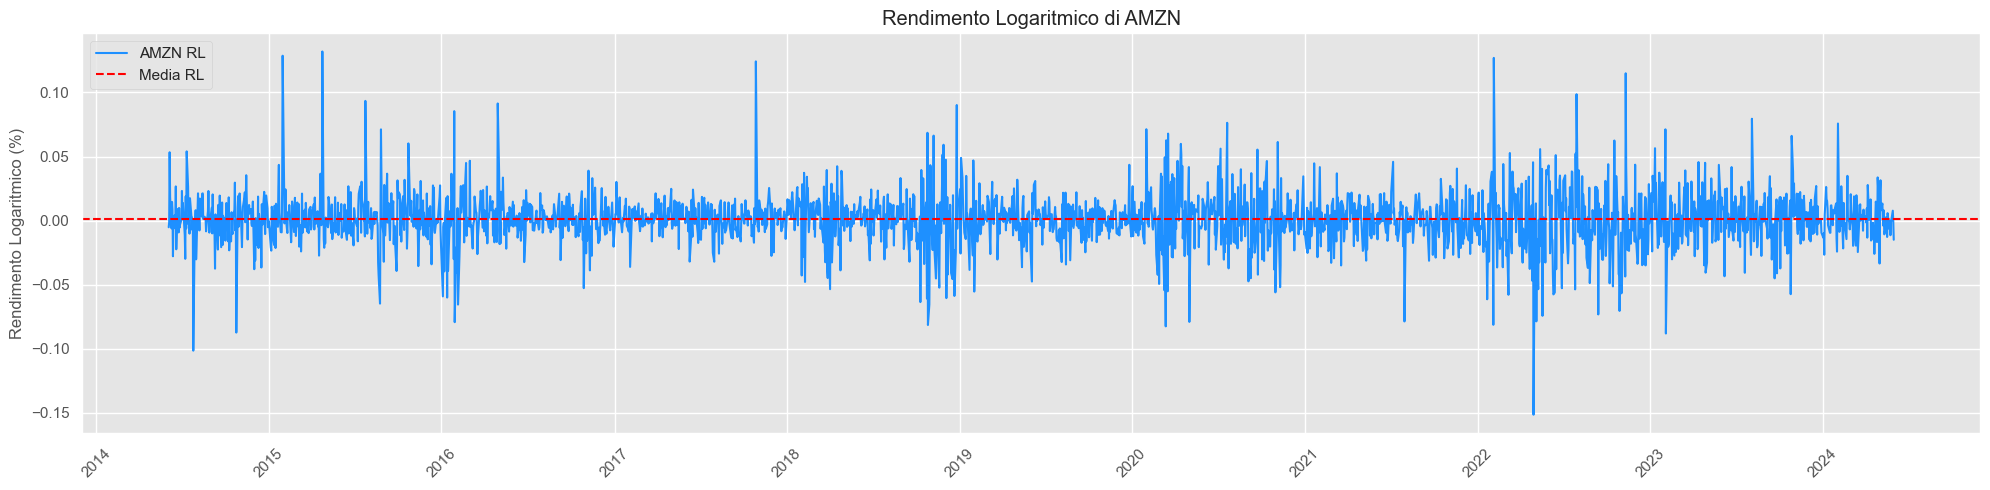

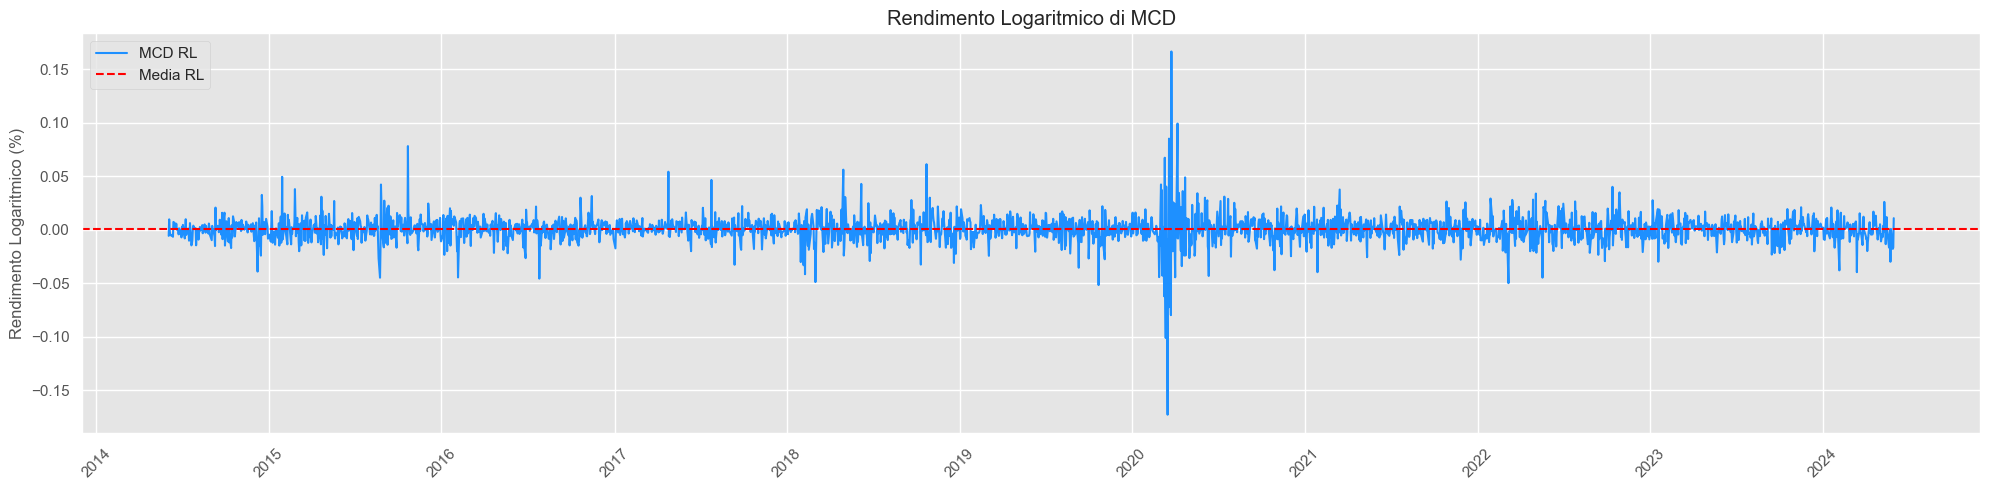

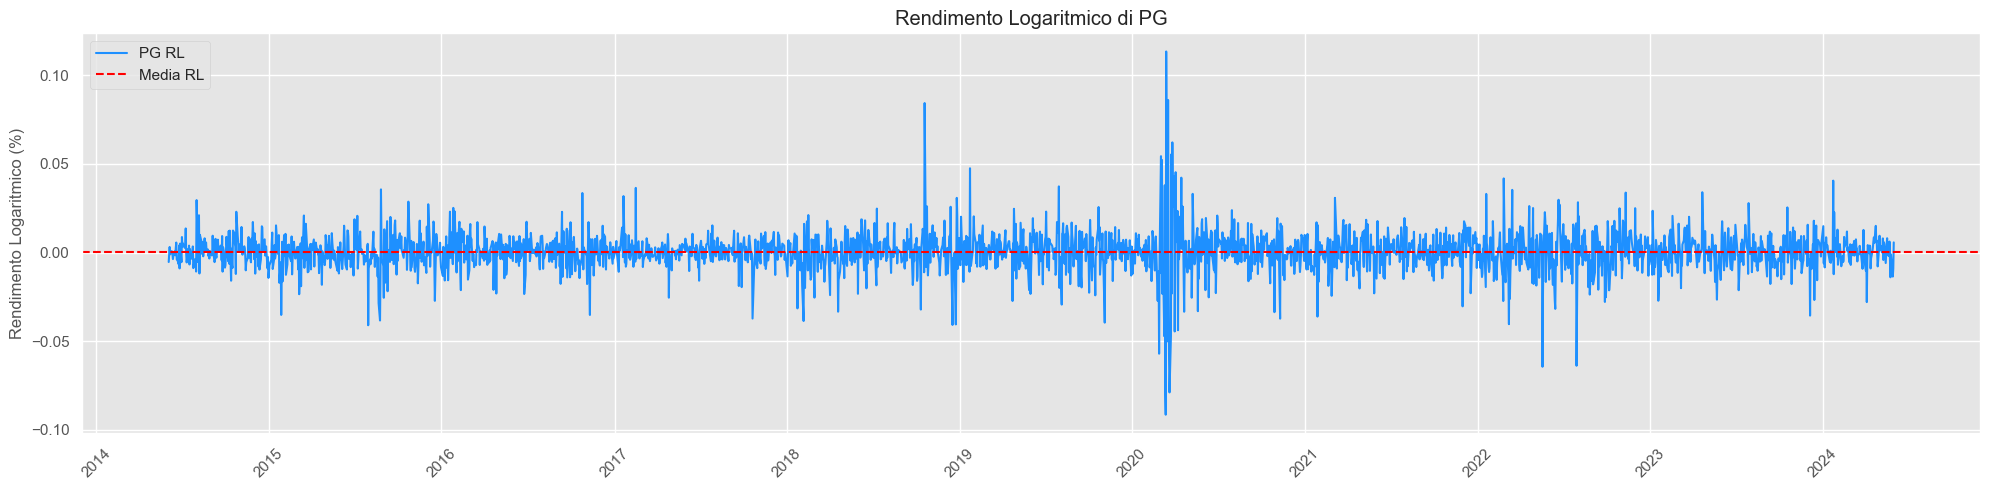

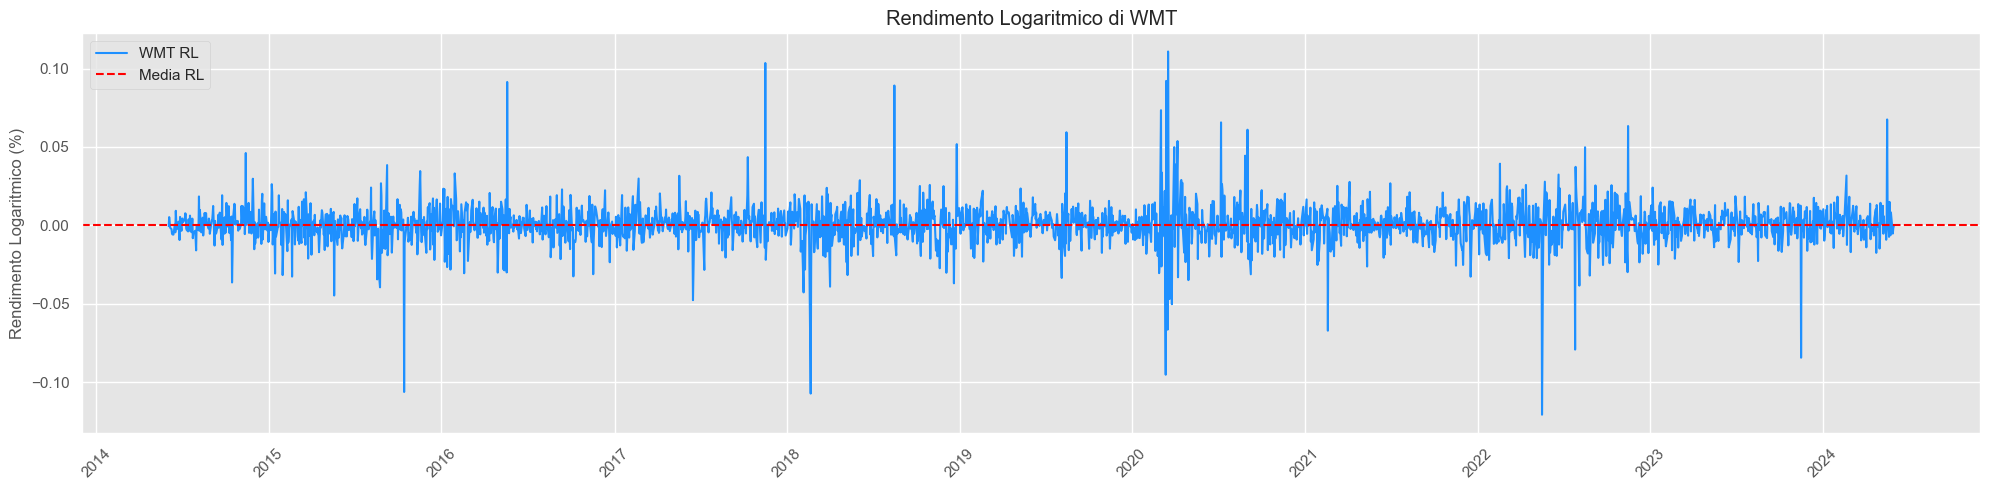

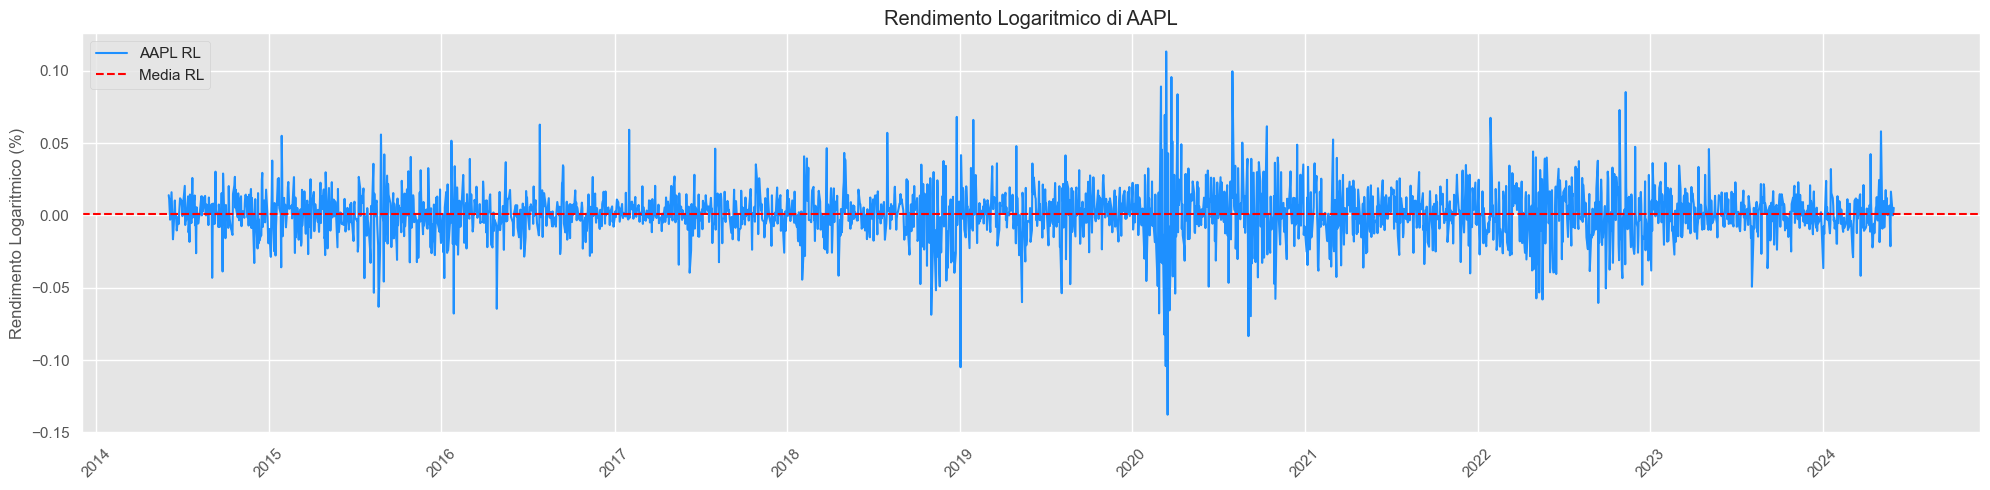

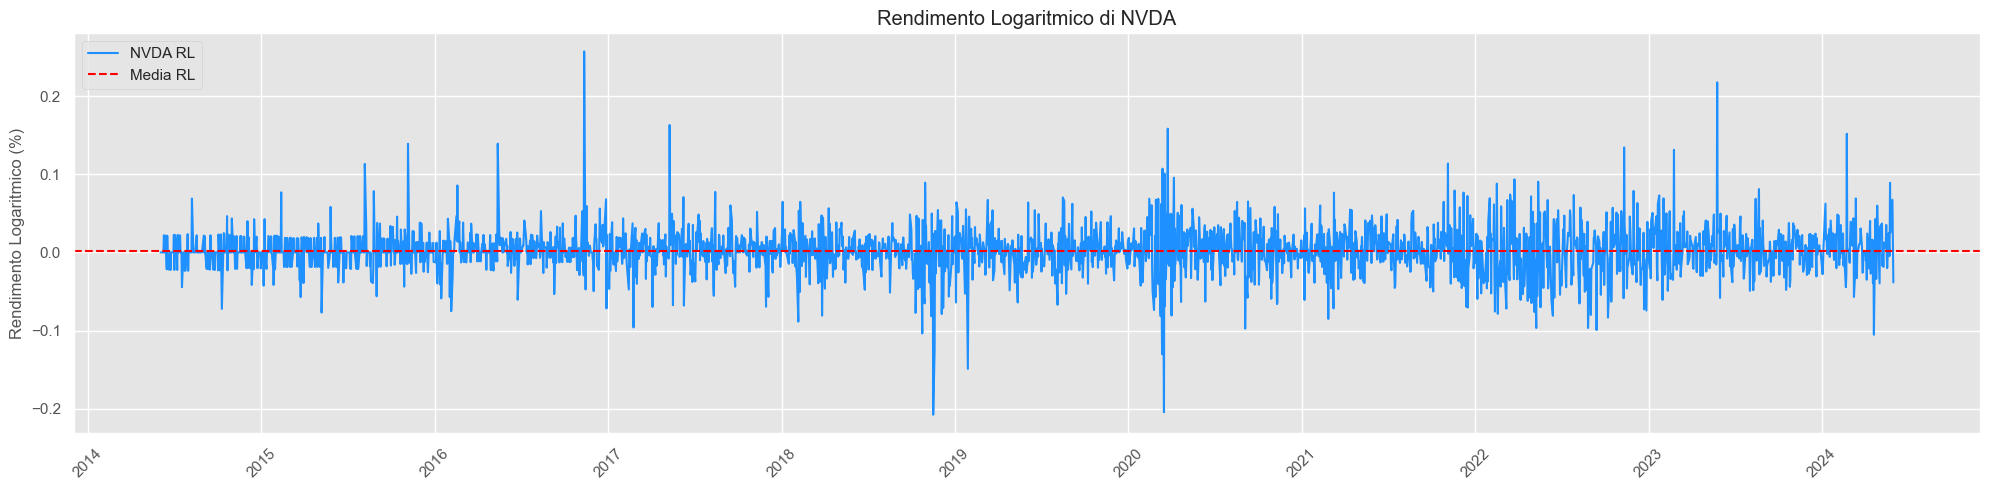

In [ ]:
for ticker in tickers:
    label_plot_log = f"{ticker} RL"
    nome_azienda = ticker 
    valore_mean_log = returns_df[label_plot_log].mean()

    returns_log = returns_df[label_plot_log]


    fig, ax = plt.subplots(figsize=(20, 5))

    # Grafico dei rendimenti logaritmici
    ax.plot(returns_log.index, returns_log, color='dodgerblue', label=label_plot_log)
    ax.set_title(f'Rendimento Logaritmico di {nome_azienda}')
    ax.set_ylabel('Rendimento Logaritmico (%)')
    ax.axhline(valore_mean_log, color='red', linestyle='dashed', label='Media RL')
    ax.legend(loc='upper left')
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# Titoli per i grafici
return_types = ['RS_Netto', 'RL']

d. Presentare i rendimenti con istogrammi e confrontare la dispersione dei rendimenti dei diversi titoli

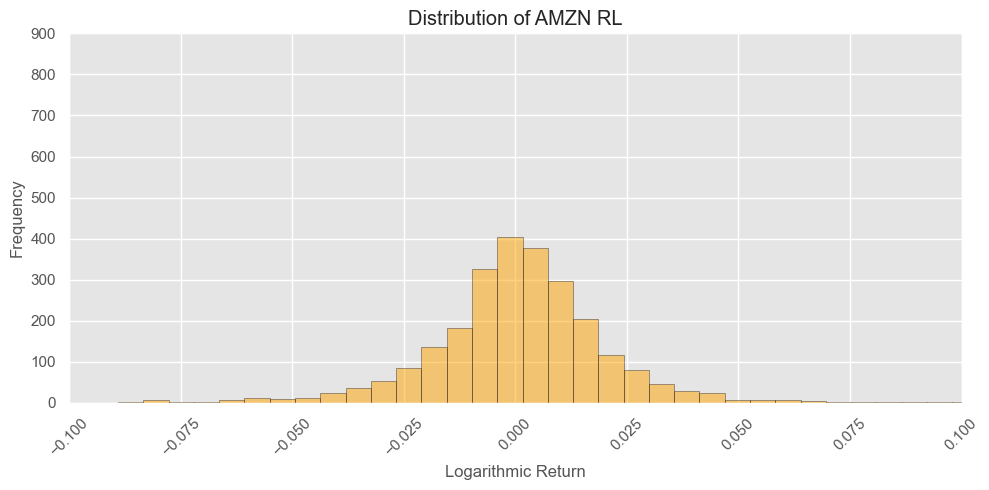

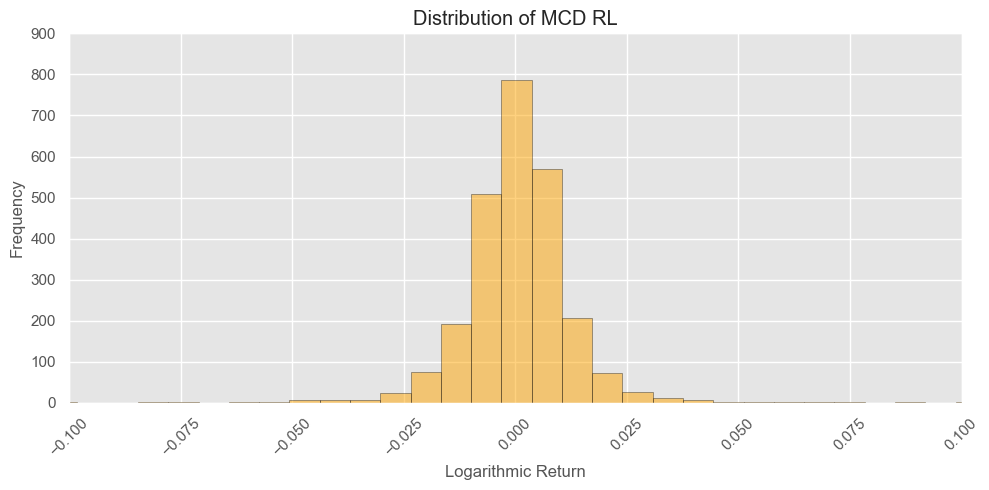

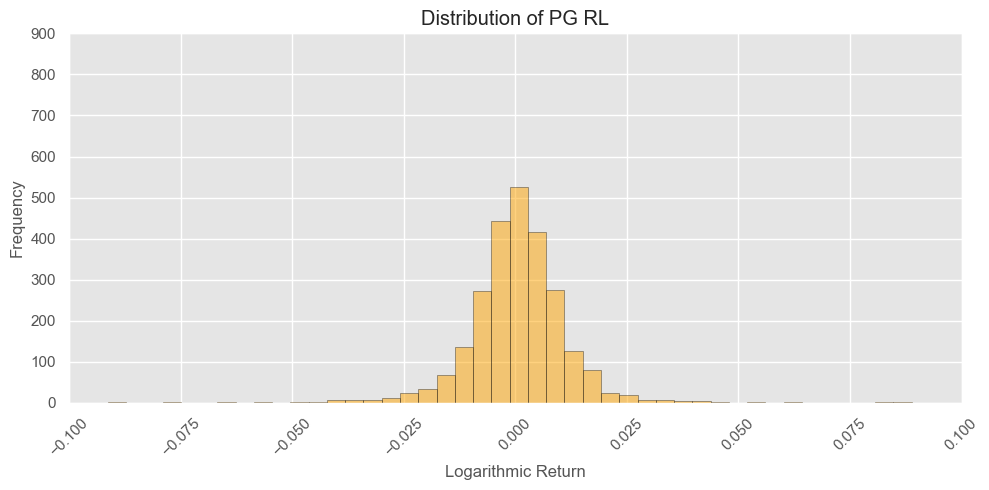

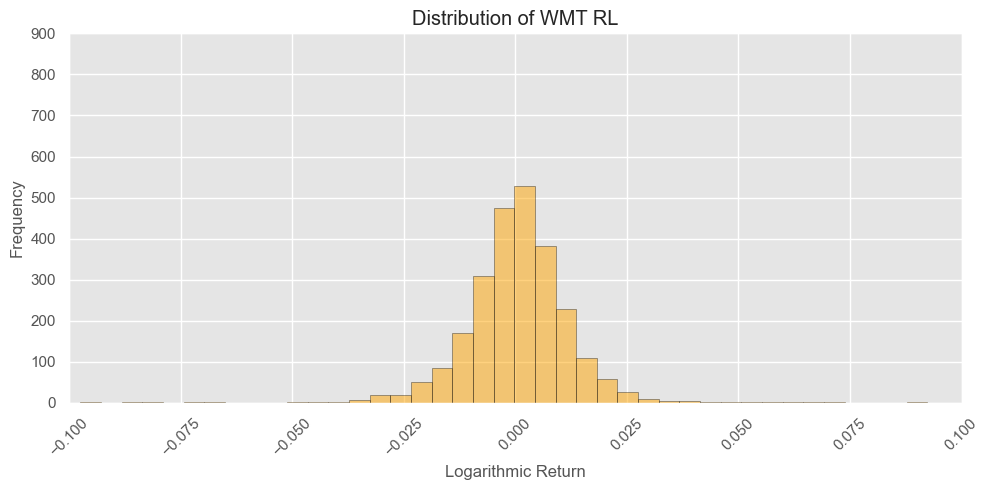

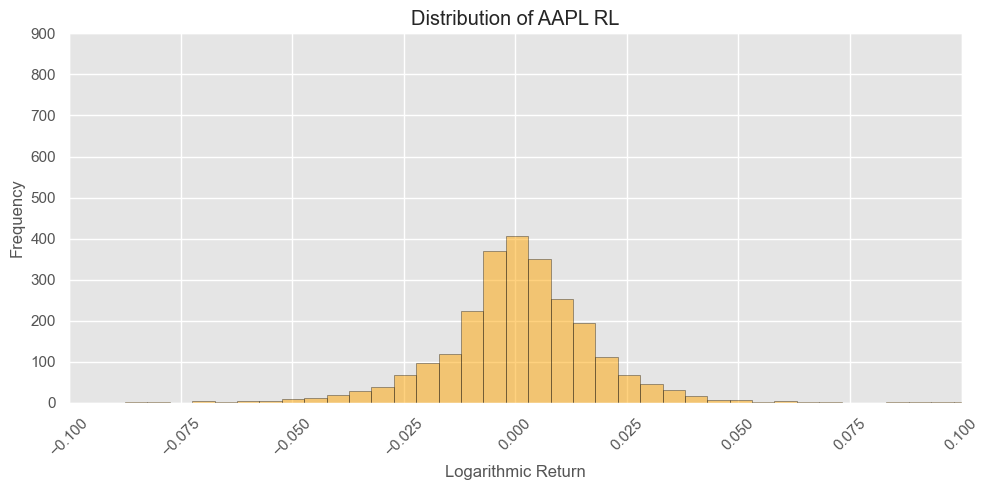

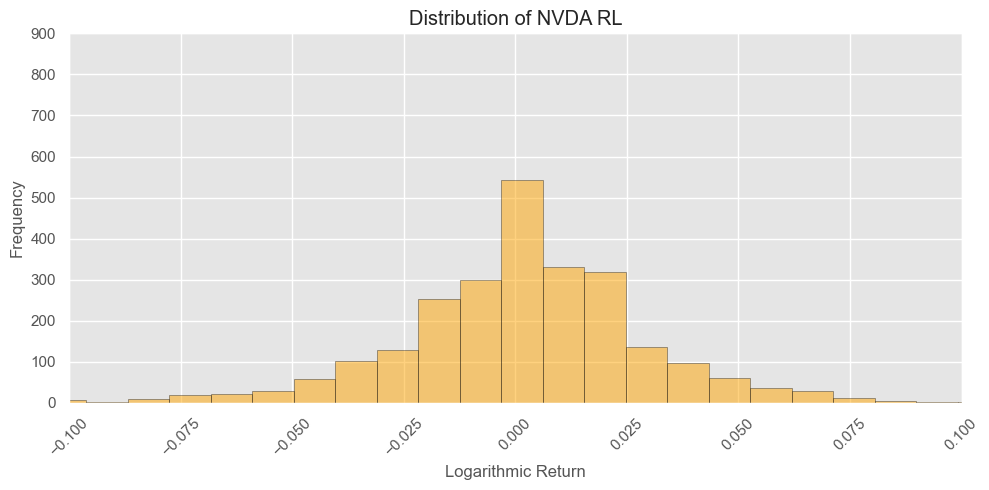

In [ ]:
return_type = 'RL'  
bins = 50  

for ticker in tickers:
    plt.figure(figsize=(10, 5))
    data_to_plot = returns_df[f'{ticker} {return_type}'].dropna()

    plt.hist(data_to_plot, bins=bins, alpha=0.5, color='orange', edgecolor='black', label=f'{ticker} {return_type}')
    plt.title(f'Distribution of {ticker} {return_type}')
    plt.xlabel('Logarithmic Return')
    plt.ylabel('Frequency')
    plt.xlim(-0.10, 0.10)
    plt.ylim(0, 900)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

e. Creare grafici diagnostici a 3 sezioni (istogramma e kernel density, boxplot, qq-plot) per ciascuna serie di rendimenti e commentare
(i rendimenti sono distribuiti normalmente?
Ci sono outliers?)

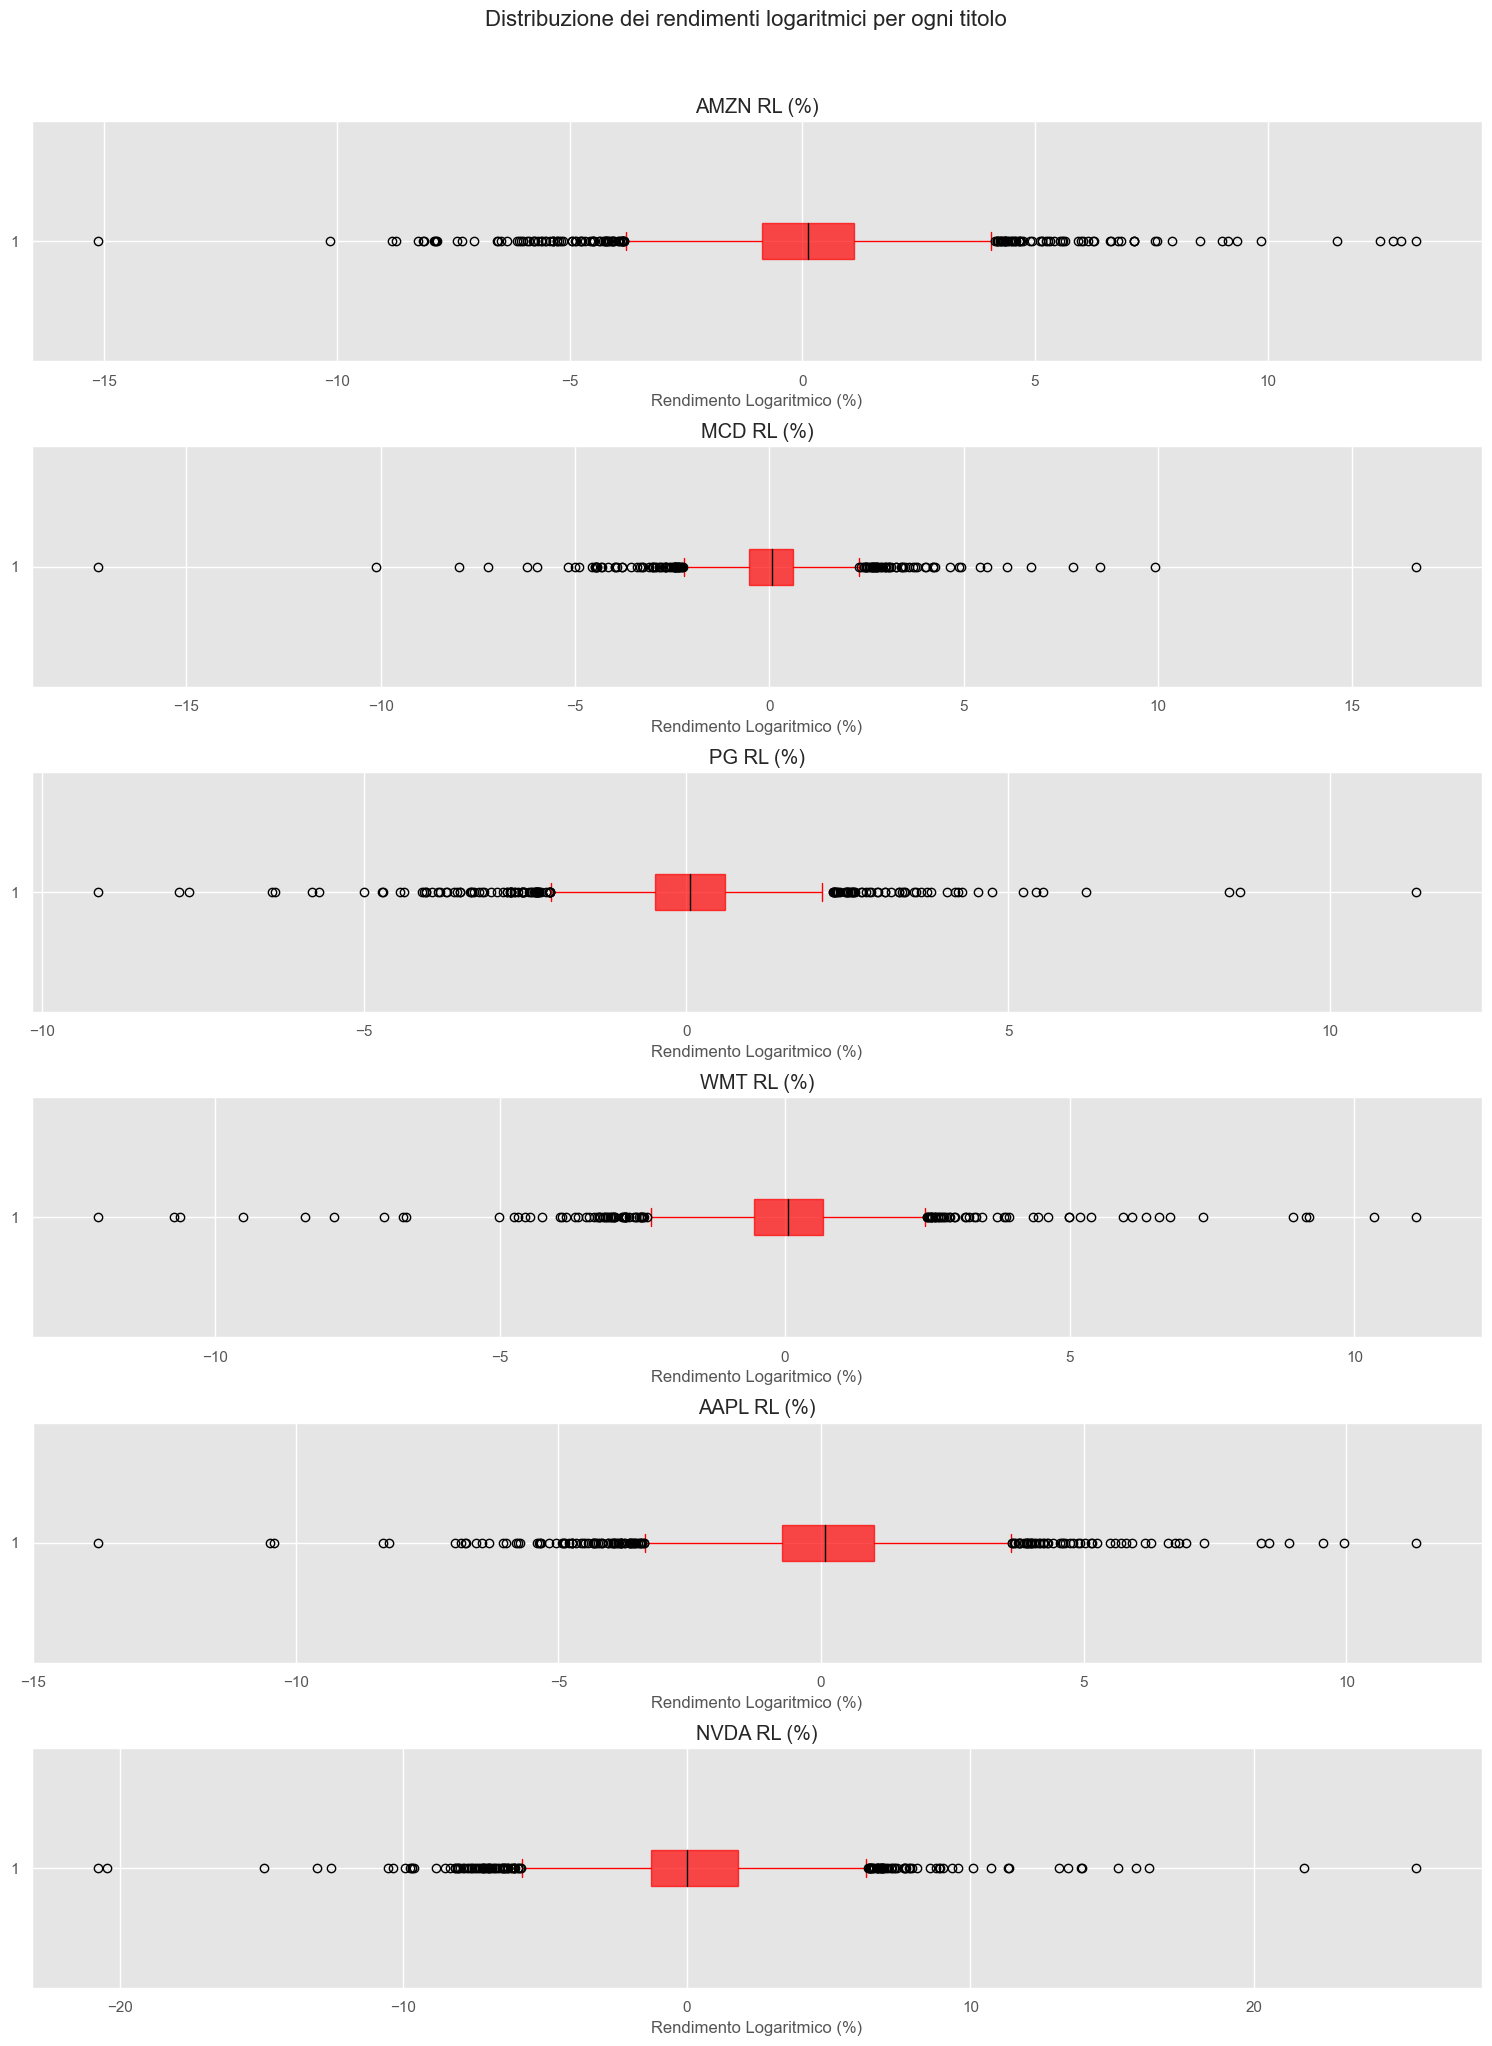

In [ ]:
# Configurazione principale della figura
fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(15, 20))  
fig.suptitle('Distribuzione dei rendimenti logaritmici per ogni titolo', fontsize=16, y=1.02)

for i, ticker in enumerate(tickers):
    # Plotta solo il rendimento logaritmico in orizzontale
    axes[i].boxplot(returns_df[f'{ticker} RL'].dropna() * 100, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='red', color='red', alpha=0.7),
                    whiskerprops=dict(color='red'),
                    capprops=dict(color='red'),
                    medianprops=dict(color='black'))
    axes[i].set_title(f'{ticker} RL (%)')
    axes[i].set_xlabel('Rendimento Logaritmico (%)')
    axes[i].grid(True)

plt.tight_layout(pad=1.0)
plt.show()

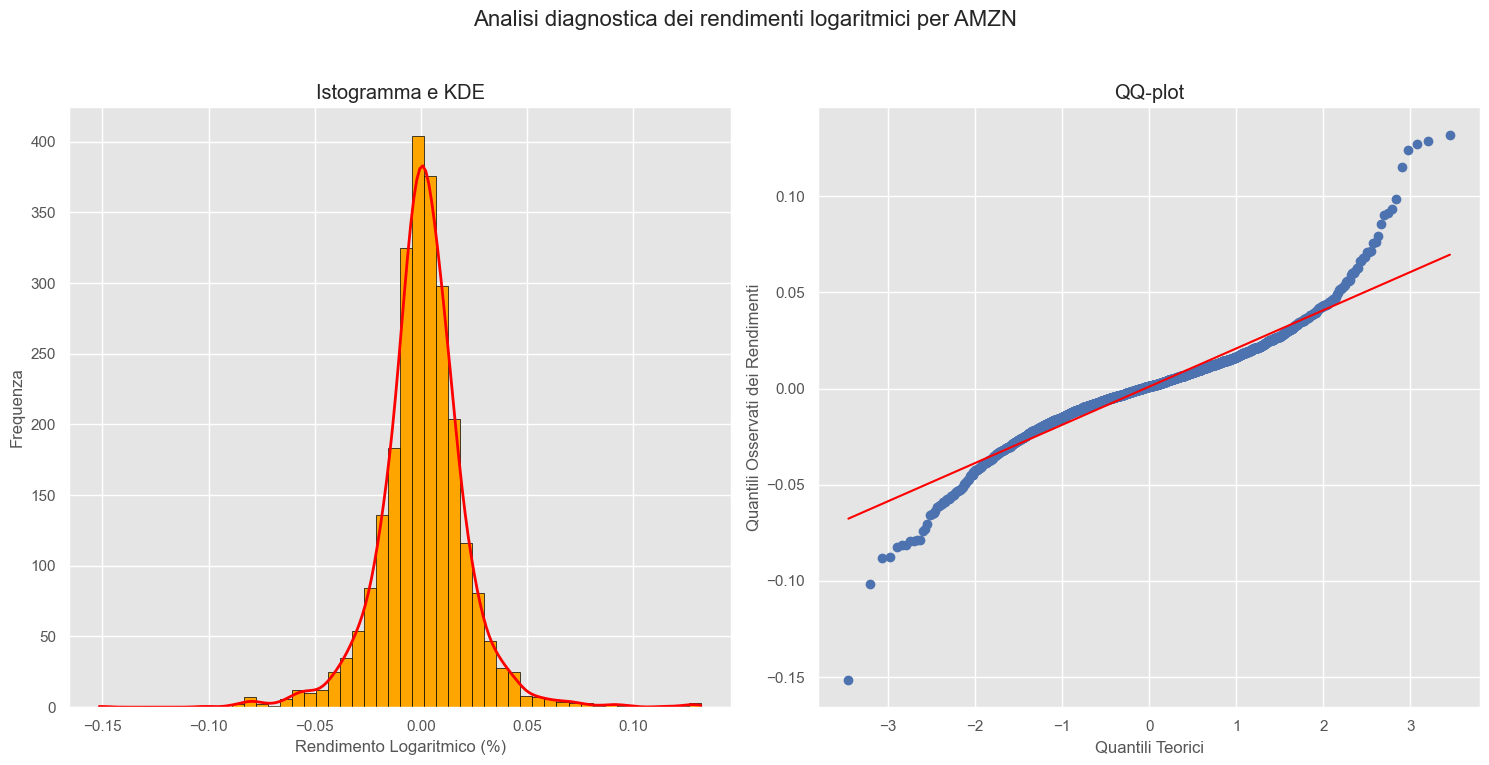

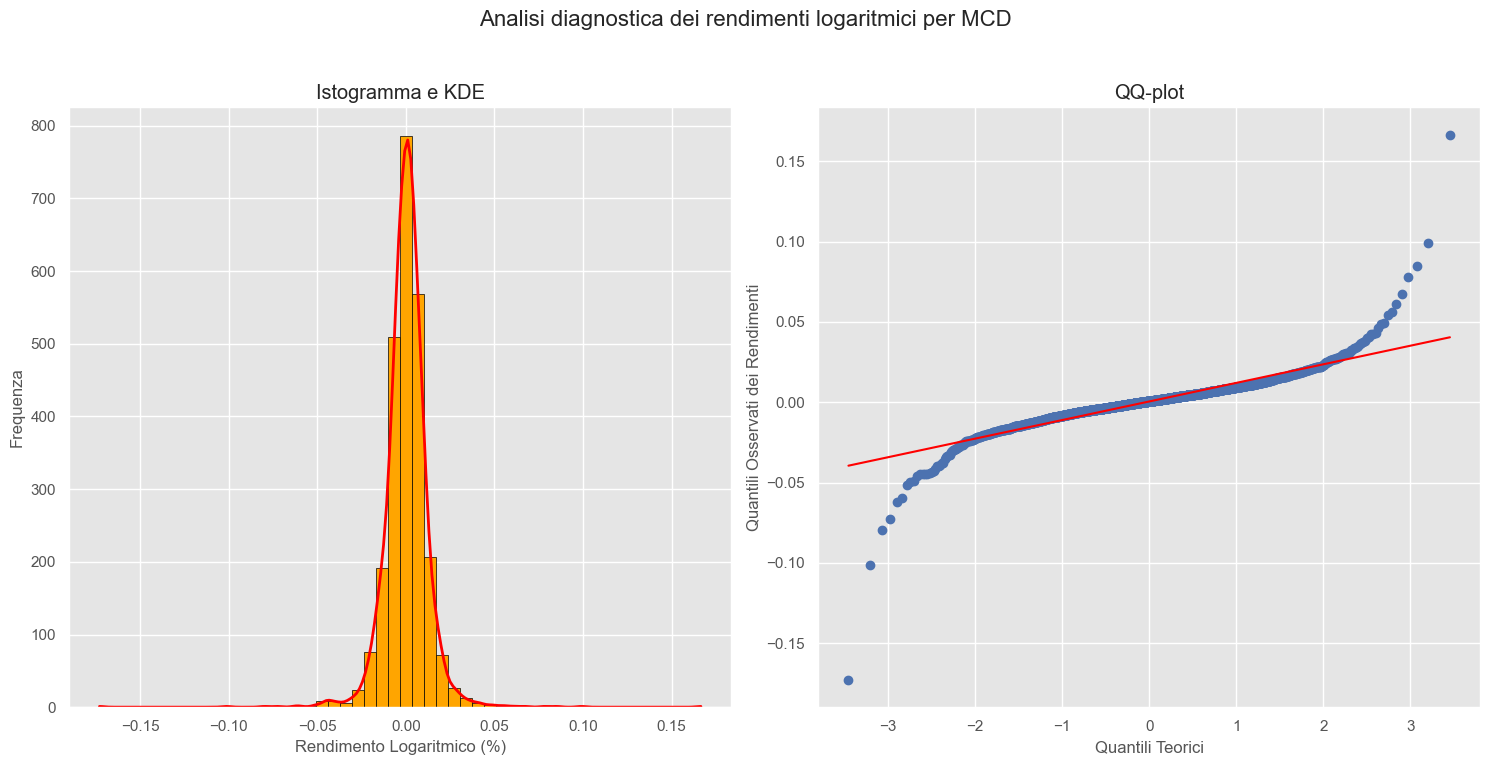

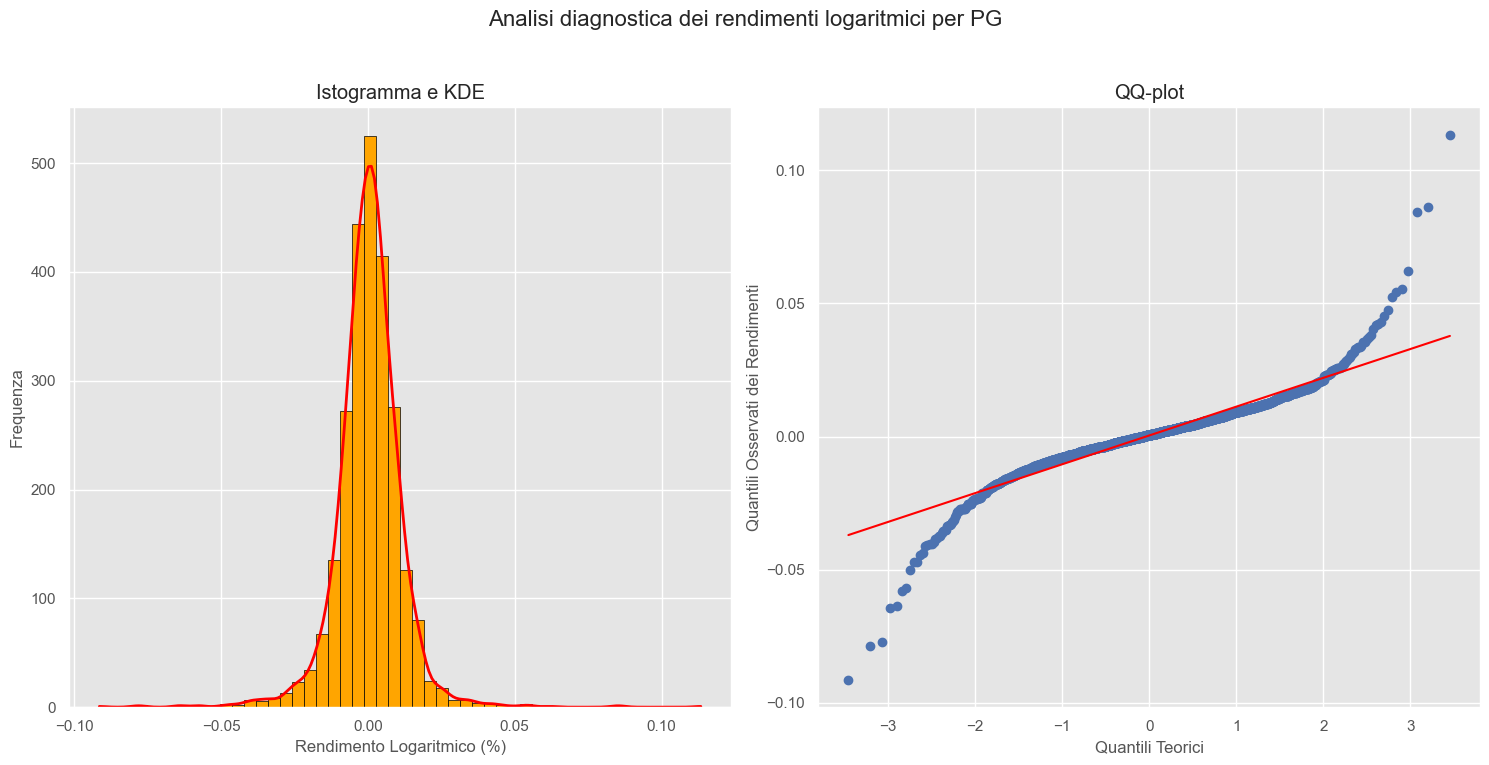

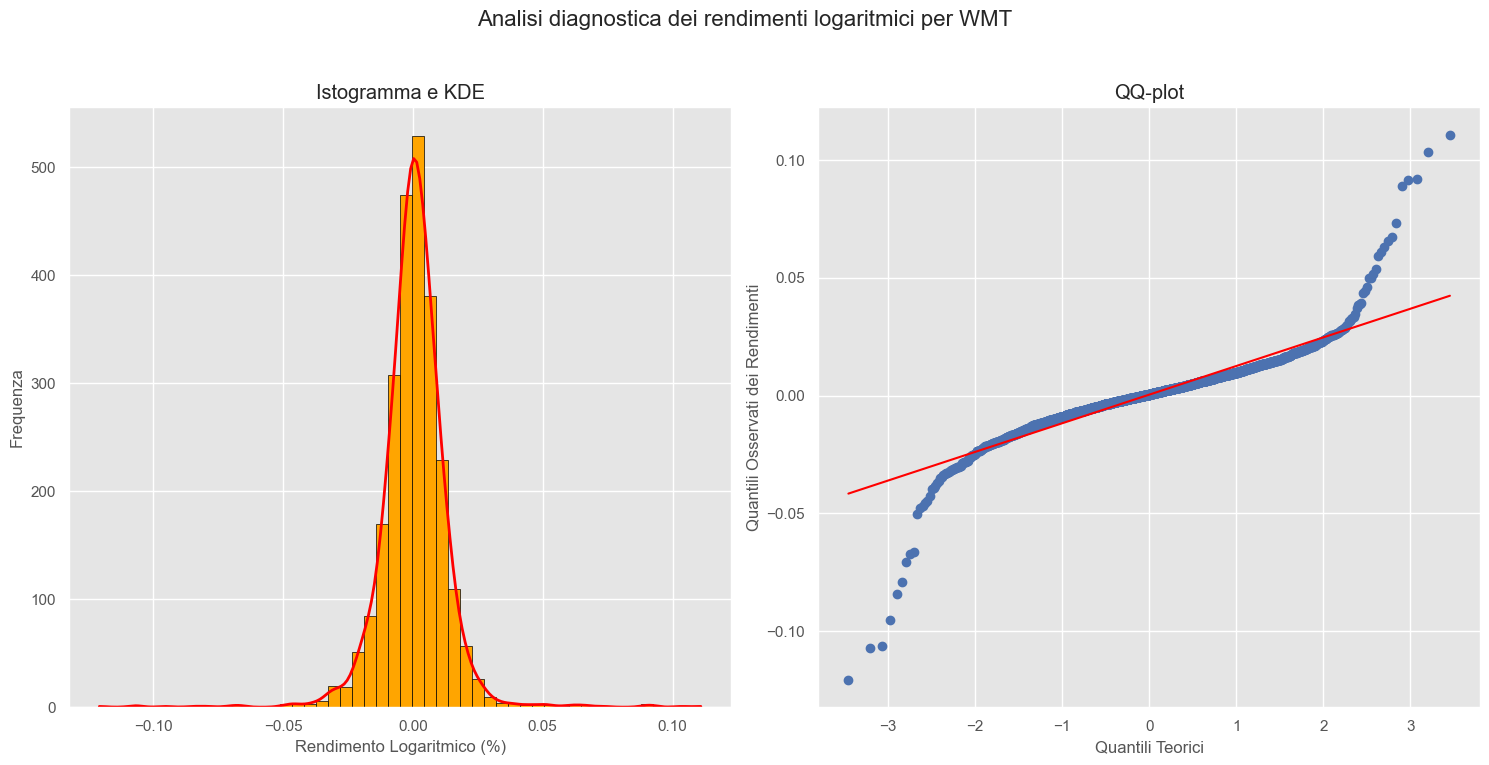

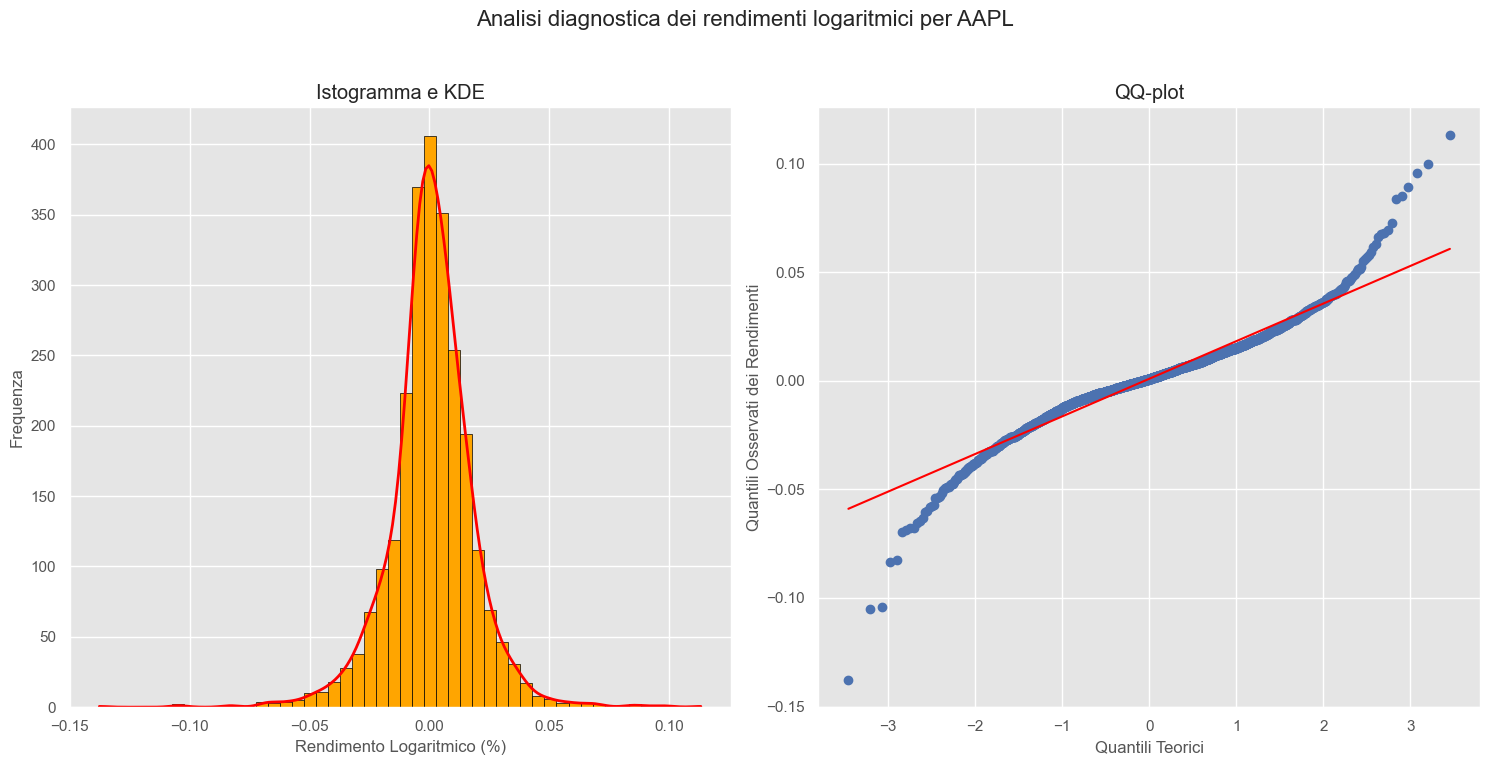

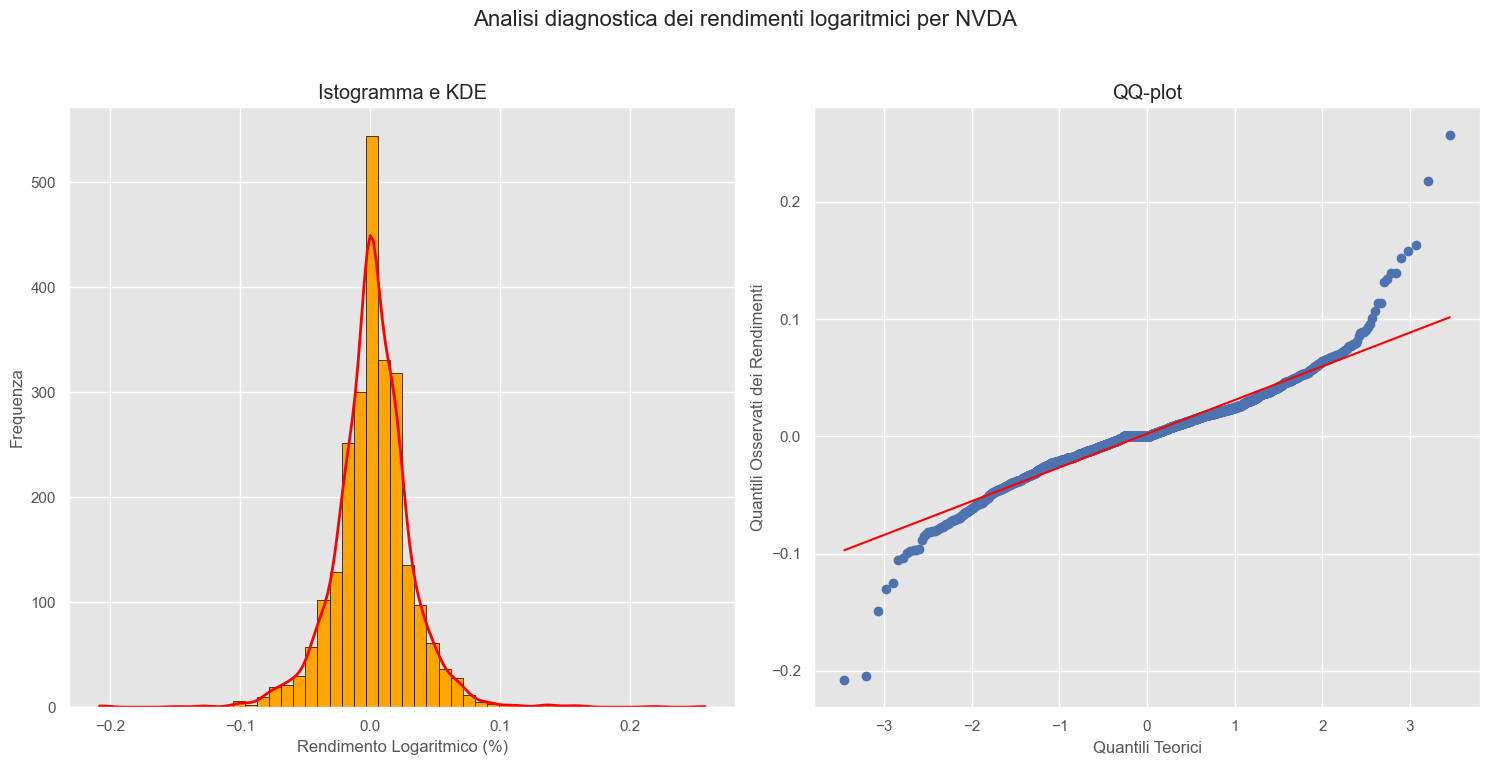

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Ciclo per ciascun ticker
for ticker in tickers:
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    fig.suptitle(f'Analisi diagnostica dei rendimenti logaritmici per {ticker}', fontsize=16)

    # Dati per il ticker corrente
    data = returns_df[f'{ticker} RL'].dropna()  # Rimuovi NaN per analisi accurate

    # Istogramma e KDE (Kernel Density Estimate)
    sns.histplot(data, kde=True, ax=axes[0], color="red", bins=50,
                 line_kws={'lw': 2}, facecolor='orange', edgecolor='black')  # Utilizzo line_kws per personalizzare la linea KDE
    axes[0].set_title('Istogramma e KDE')
    axes[0].set_xlabel('Rendimento Logaritmico (%)')
    axes[0].set_ylabel('Frequenza')

    # QQ-plot
    stats.probplot(data, dist="norm", plot=axes[1])
    axes[1].get_lines()[1].set_color('red')
    axes[1].set_title('QQ-plot')
    axes[1].set_xlabel('Quantili Teorici')
    axes[1].set_ylabel('Quantili Osservati dei Rendimenti')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to include the suptitle
    plt.show()


f. Calcolare statistiche descrittive univariate (media, varianza, deviazione standard,
asimmetria, curtosi) per ogni serie di rendimenti e commentare.
i. Quali azioni hanno il rendimento più basso e più alto?
ii. quali azioni hanno la deviazione standard più alta o più bassa?
iii. come si evolvono nel tempo rendimento e volatilità?
iv. quale azione ha la distribuzione di rendimenti più vicina o lontana dalla
normale?


In [ ]:
# Preparazione del DataFrame per contenere le statistiche
stats_df = pd.DataFrame(index=tickers)

# Ciclo per ogni ticker
for ticker in tickers:
    # Selezione dei dati di rendimento logaritimico per il ticker corrente
    data = returns_df[f'{ticker} RL'].dropna()  # Rimuovi NaN

    # Calcolo delle statistiche
    stats_df.loc[ticker, 'Media'] = data.mean()
    stats_df.loc[ticker, 'Varianza'] = data.var()
    stats_df.loc[ticker, 'Deviazione Standard'] = data.std()
    stats_df.loc[ticker, 'Asimmetria'] = data.skew()
    stats_df.loc[ticker, 'Curtosi'] = data.kurtosis()

stats_df.round(4)

Media  Varianza  Deviazione Standard  Asimmetria  Curtosi
AMZN  0.0010    0.0004               0.0206      0.1267   5.9907
MCD   0.0005    0.0002               0.0127     -0.1516  32.1372
PG    0.0004    0.0001               0.0115      0.0062  12.2436
WMT   0.0005    0.0002               0.0132     -0.2200  16.4201
AAPL  0.0009    0.0003               0.0178     -0.2156   5.5198
NVDA  0.0022    0.0009               0.0298      0.2275   7.2888

In [ ]:
# Preparazione del DataFrame contenente solo i rendimenti logaritmici
log_returns = returns_df.filter(regex='RL$')

# Calcolo della matrice di covarianza annualizzata
covariance_matrix = (log_returns*252).cov()

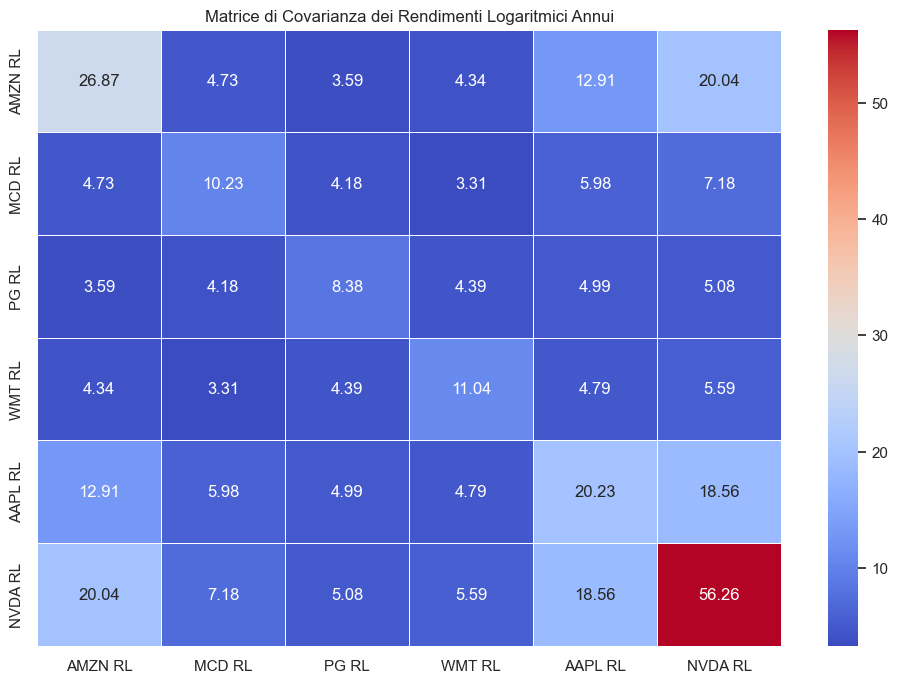

In [ ]:
# Configurazione dell'ambiente grafico
sns.set(style="whitegrid")
# Visualizzazione della matrice di covarianza
plt.figure(figsize=(12, 8))
sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title('Matrice di Covarianza dei Rendimenti Logaritmici Annui')
plt.show()

g. i. Quali sono i titoli più correlati?
ii. Quali i meno correlati?


In [ ]:
correlation_matrix = log_returns.corr()

max_corr = 0
pair_most_corr = ('', '')

for i in correlation_matrix.columns:
    for j in correlation_matrix.index:
        if i != j:  # Evitiamo di confrontare un titolo con se stesso
            if correlation_matrix.loc[i, j] > max_corr:
                max_corr = correlation_matrix.loc[i, j]
                pair_most_corr = (i, j)

# ii. Titoli meno correlati
min_corr = 1
pair_least_corr = ('', '')

for i in correlation_matrix.columns:
    for j in correlation_matrix.index:
        if i != j:  # Evitiamo di confrontare un titolo con se stesso
            if correlation_matrix.loc[i, j] < min_corr:
                min_corr = correlation_matrix.loc[i, j]
                pair_least_corr = (i, j)

In [ ]:
# Calcolo max e min correlazione
max_val = correlation_matrix.values.max()
min_val = correlation_matrix.values.min()

# Calcolo di un limite ragionevole per la scala dei colori
color_limit = max(abs(max_val), abs(min_val))

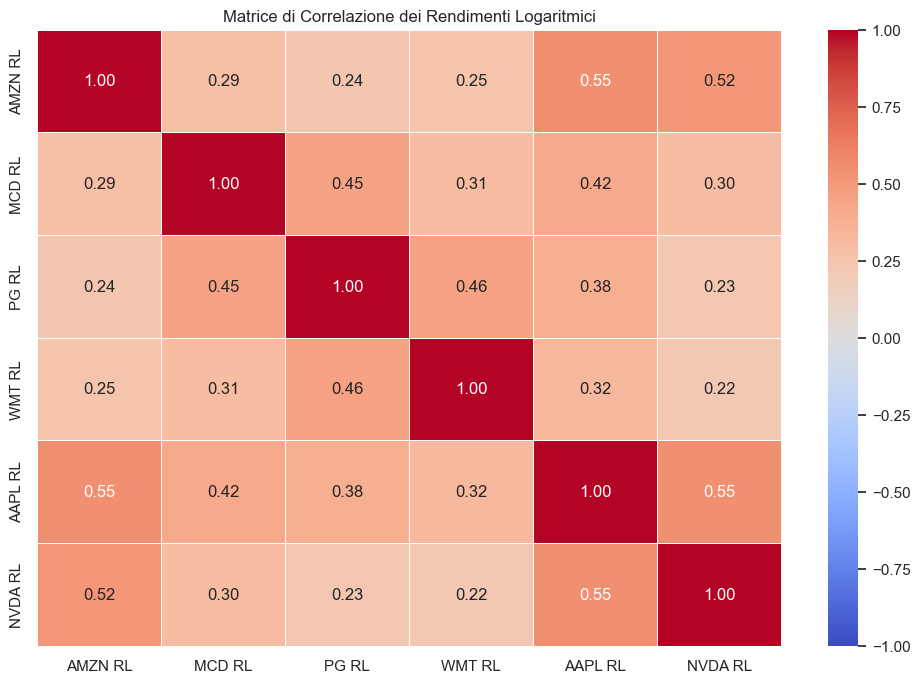

In [ ]:

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, center=0, vmin=-color_limit, vmax=color_limit)
plt.title('Matrice di Correlazione dei Rendimenti Logaritmici')
plt.show()

In [ ]:
# Calcolo delle correlazioni mobili
rolling_correlations = log_returns.rolling(window=252).corr().dropna()

h. Fare il grafico dell’andamento nel tempo delle correlazioni fra i titoli

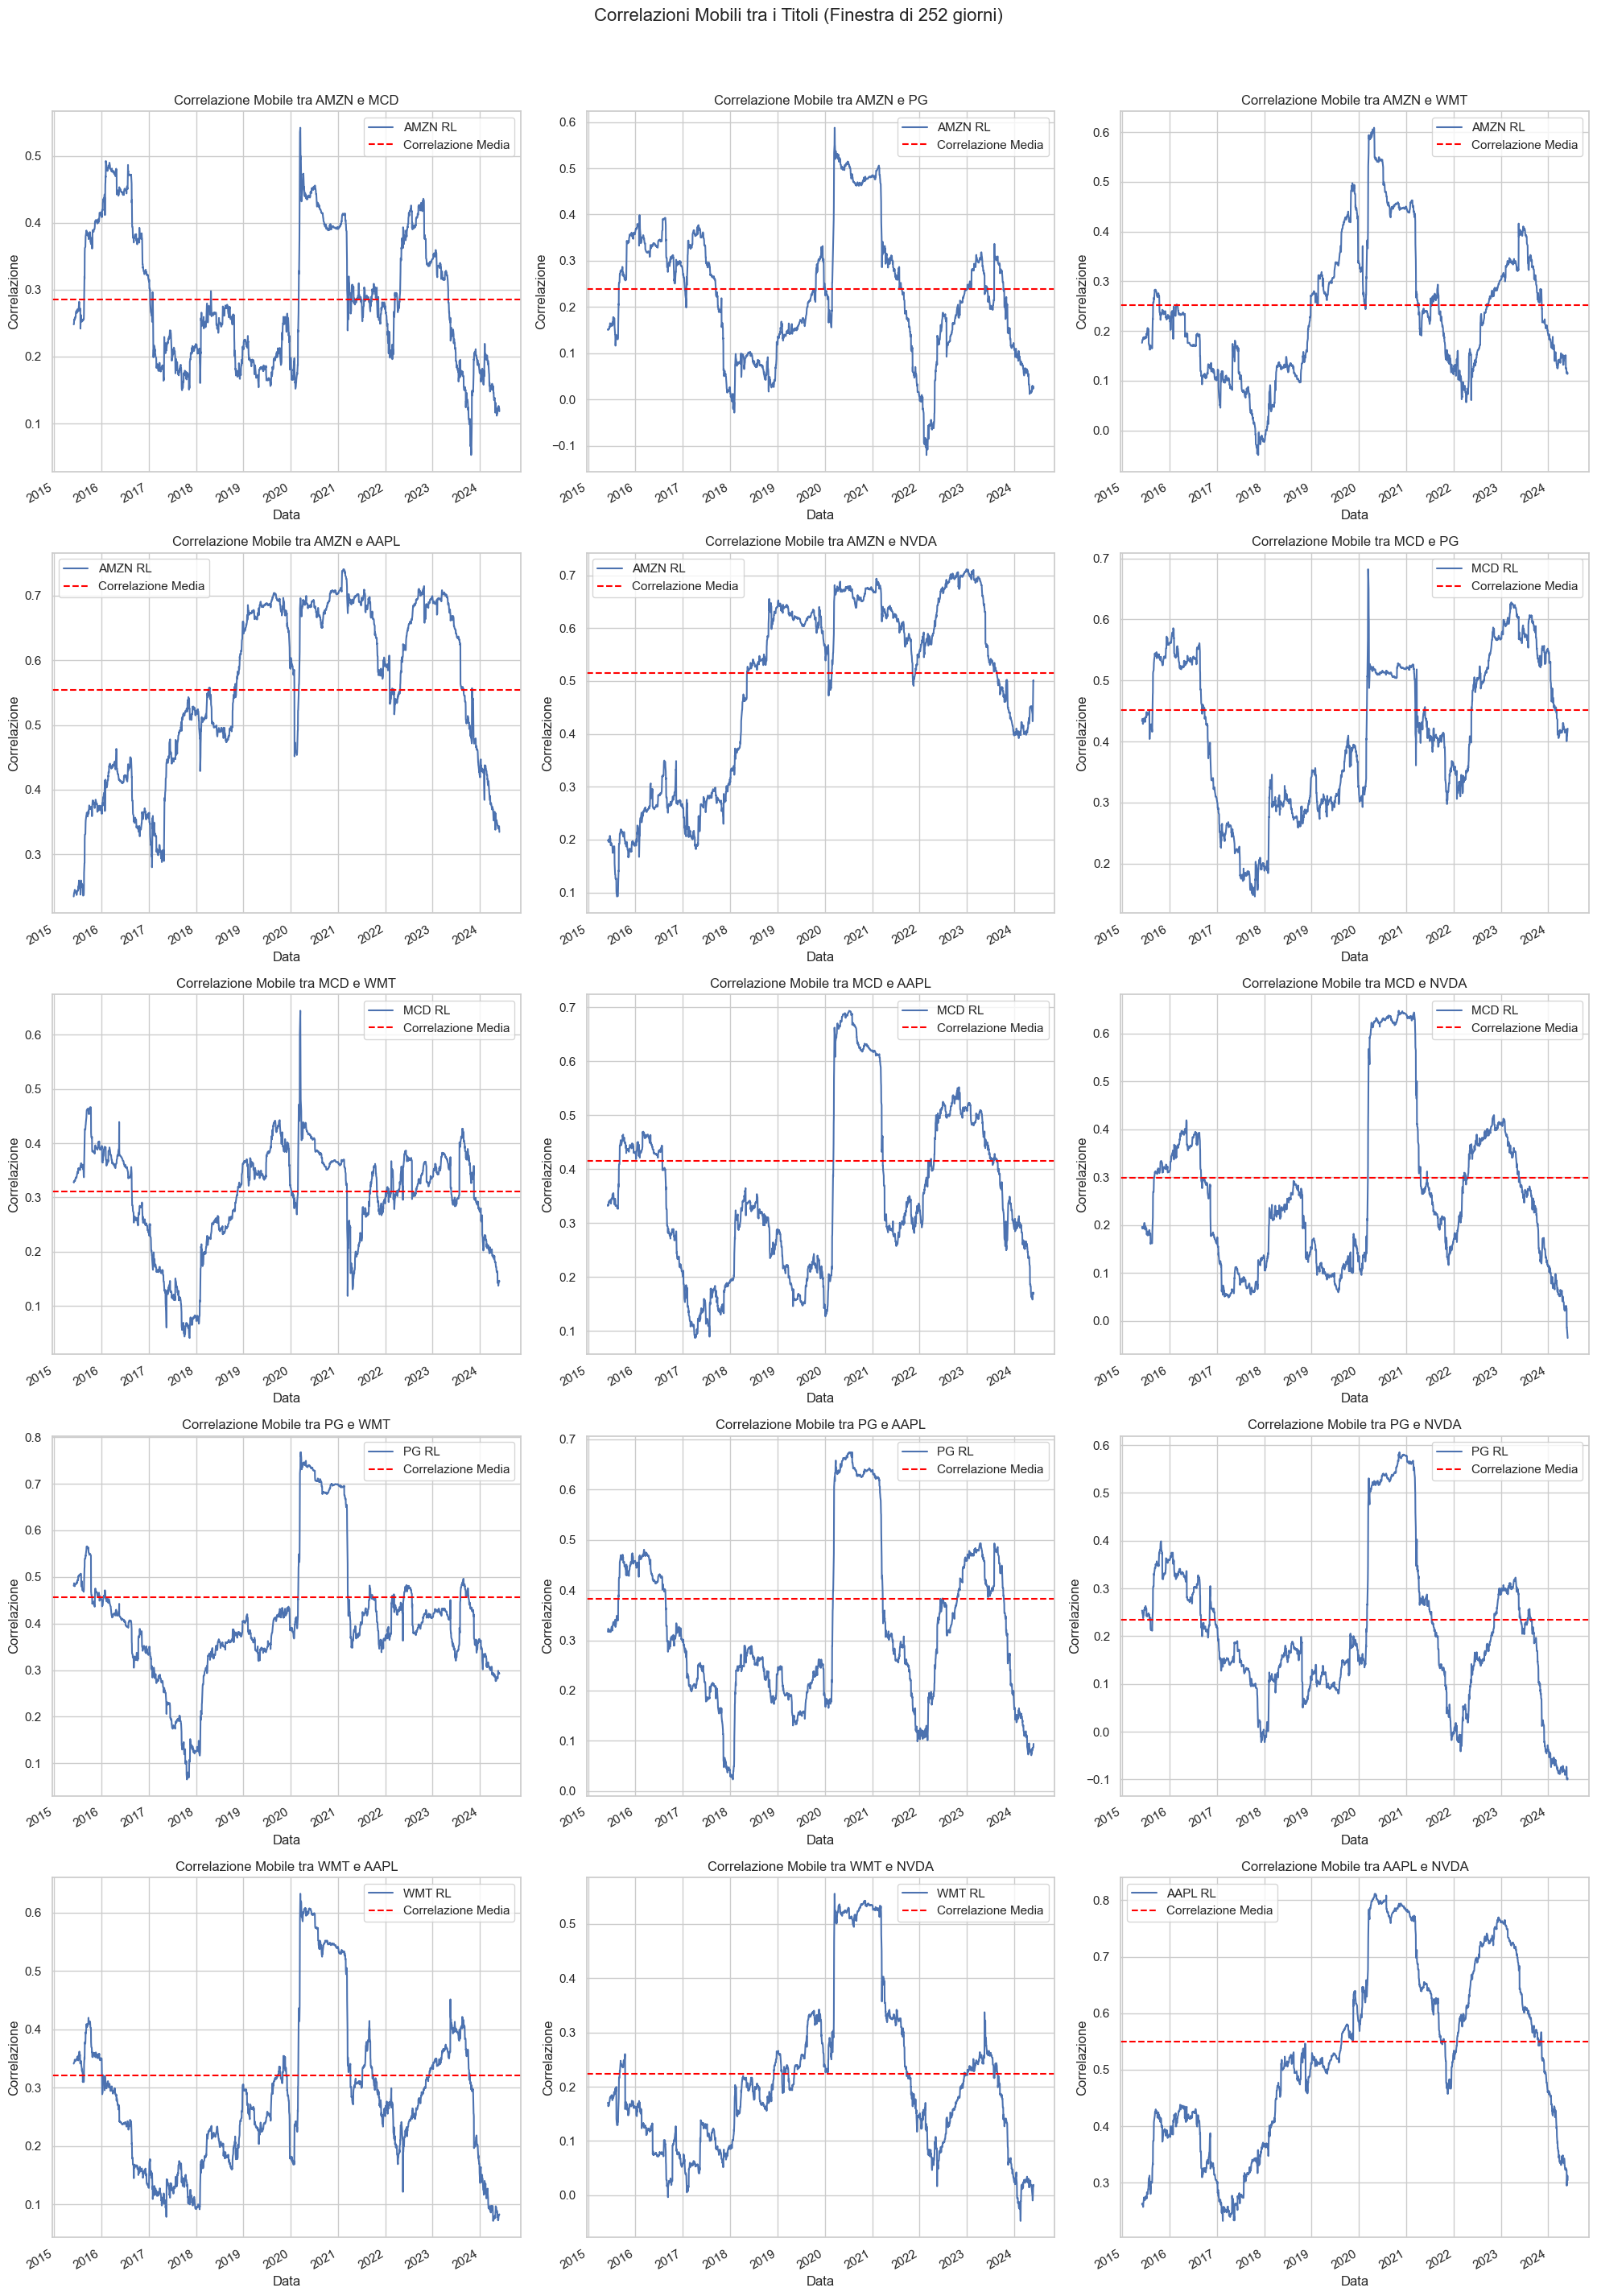

In [ ]:
# Preparazione della griglia di grafici
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 30))
axes = axes.flatten()  

# Grafico delle correlazioni mobili per ogni coppia di titoli
plot_idx = 0
for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        ticker_i = tickers[i]
        ticker_j = tickers[j]

        if f'{ticker_i} RL' in rolling_correlations.columns and f'{ticker_j} RL' in rolling_correlations.columns:
            rolling_corr_pair = rolling_correlations[f'{ticker_i} RL'].loc[:, f'{ticker_j} RL']

            # Estrai la correlazione media dalla matrice di correlazione
            mean_correlation = correlation_matrix.loc[f'{ticker_i} RL', f'{ticker_j} RL']

            ax = axes[plot_idx]
            rolling_corr_pair.plot(ax=ax, title=f'Correlazione Mobile tra {ticker_i} e {ticker_j}')
            ax.axhline(mean_correlation, color='red', linestyle='--', label='Correlazione Media')
            ax.set_xlabel('Data')
            ax.set_ylabel('Correlazione')
            ax.legend()
            plot_idx += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to include the suptitle
plt.suptitle('Correlazioni Mobili tra i Titoli (Finestra di 252 giorni)', fontsize=16)
plt.show()

In [ ]:
sectors = {
    'XLY': ['AMZN', 'MCD'], 
    'XLP': ['PG', 'WMT'],
    'XLK': ['AAPL', 'NVDA']
}

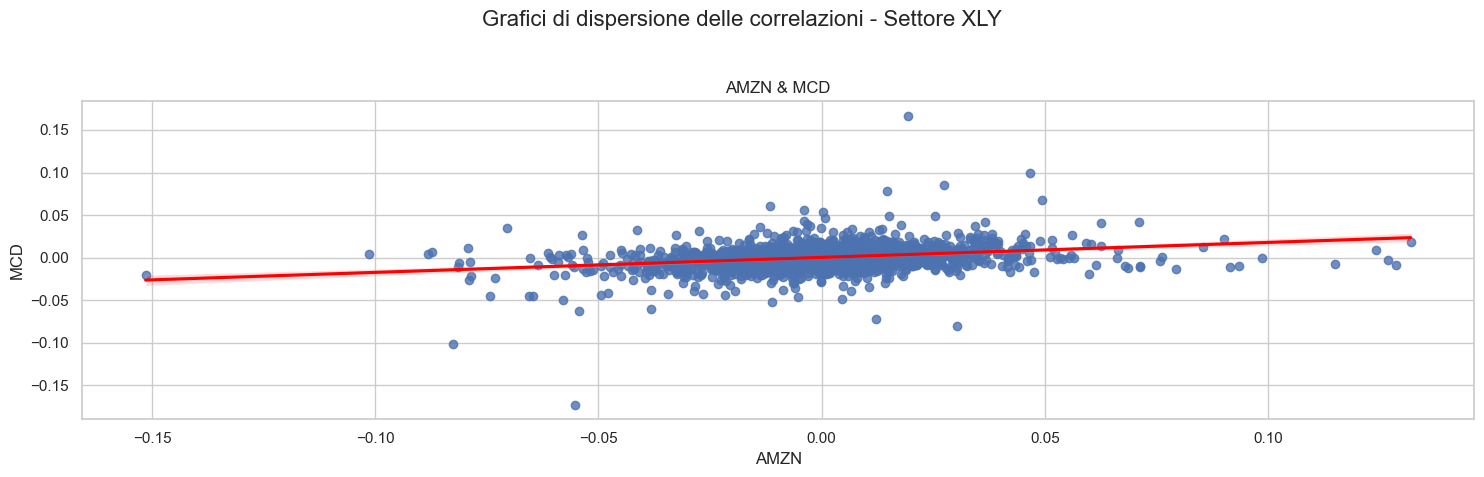

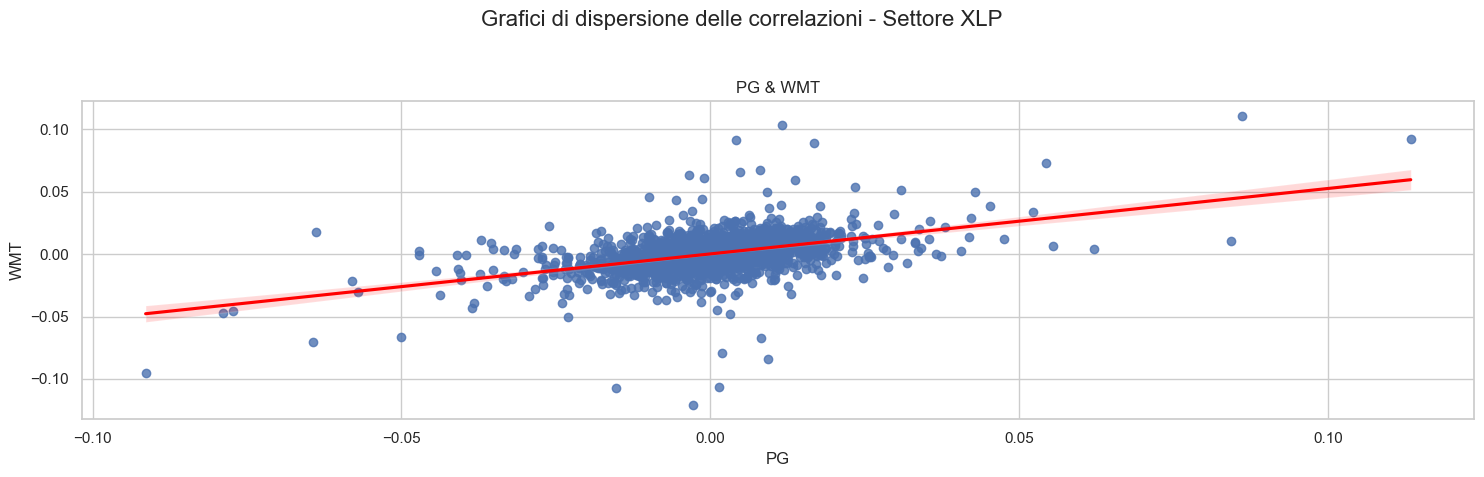

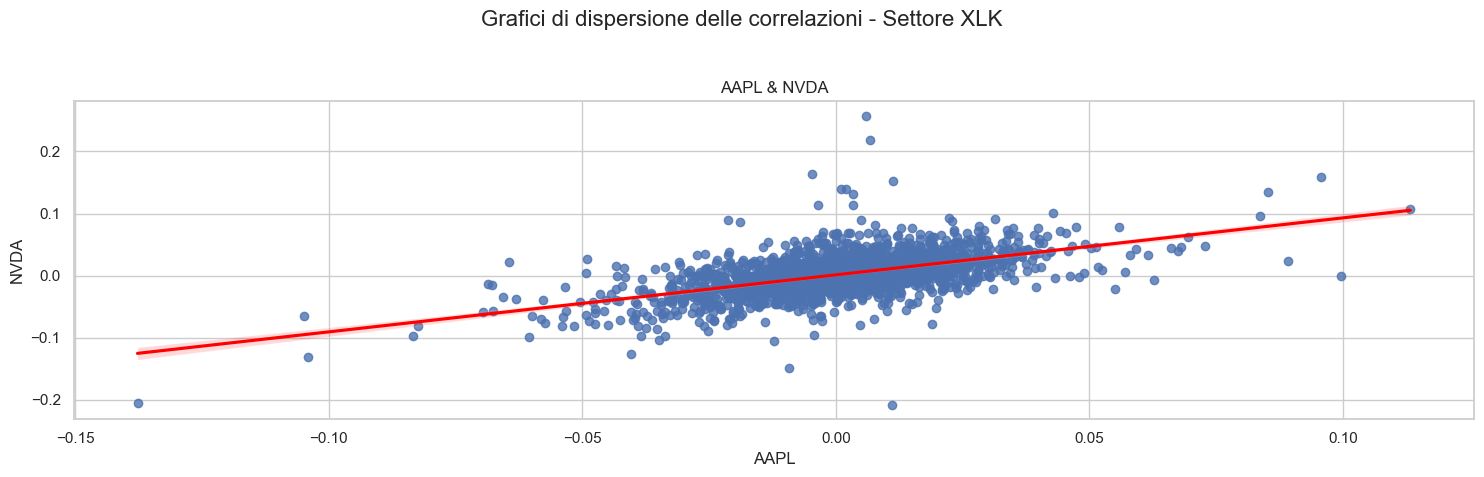

In [ ]:
# Creazione dei grafici di dispersione per ciascun settore
for sector, tickers in sectors.items():
    fig, axes = plt.subplots(1, len(tickers) - 1, figsize=(15, 5))
    fig.suptitle(f'Grafici di dispersione delle correlazioni - Settore {sector}', fontsize=16)

    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            ticker_i = tickers[i]
            ticker_j = tickers[j]
            ax = axes[i] if len(tickers) > 2 else axes

            sns.regplot(x=log_returns[f'{ticker_i} RL'], y=log_returns[f'{ticker_j} RL'], ax=ax, line_kws={"color": "red"})
            ax.set_title(f'{ticker_i} & {ticker_j}')
            ax.set_xlabel(ticker_i)
            ax.set_ylabel(ticker_j)
            ax.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

 # 3. Analisi di previsione

In [ ]:
df_settle = adjusted_close_df.resample('M').last() #rendimento mensile di ogni titolo

In [ ]:
def arima_grid_search(dataframe, s):
    p = d = q = range(2)  # Definizione dei range per p, d, q
    param_combinations = list(itertools.product(p, d, q))
    lowest_aic, pdq, pdqs = None, None, None
    total_iterations = 0

    for order in param_combinations:
        for seasonal_order in [(x[0], x[1], x[2], s) for x in param_combinations]:
            try:
                model = SARIMAX(dataframe, order=order, seasonal_order=seasonal_order)
                model_result = model.fit(disp=False)
                if lowest_aic is None or model_result.aic < lowest_aic:
                    lowest_aic = model_result.aic
                    pdq, pdqs = order, seasonal_order
            except Exception as ex:
                print(f"Error with order {order} and seasonal order {seasonal_order}: {ex}")
                continue

    return lowest_aic, pdq, pdqs

In [ ]:
hyperparams = {}
tickers = ["AMZN", "MCD", "PG", "WMT", "AAPL", "NVDA"]
for name in tickers:
    print(f"Optimizing ARIMA parameters for {name}")
    hyperparams[name] = arima_grid_search(df_settle[name].dropna(), 12)  # Presumiendo 12 come periodo stagionale

print("Optimization Complete!")
hyperparams

Optimizing ARIMA parameters for AMZN
Optimizing ARIMA parameters for MCD
Optimizing ARIMA parameters for PG
Optimizing ARIMA parameters for WMT
Optimizing ARIMA parameters for AAPL
Optimizing ARIMA parameters for NVDA
Optimization Complete!


{'AMZN': (804.6486613588127, (0, 1, 0), (0, 1, 1, 12)),
 'MCD': (807.6593573723213, (1, 1, 1), (0, 1, 1, 12)),
 'PG': (672.8724912006606, (0, 1, 0), (0, 1, 1, 12)),
 'WMT': (474.8198329028627, (0, 1, 0), (0, 1, 1, 12)),
 'AAPL': (773.9761782259034, (0, 1, 0), (0, 1, 1, 12)),
 'NVDA': (562.7042541768682, (1, 1, 1), (1, 1, 0, 12))}

In [ ]:
# Calcola le date di cut-off per il training e il validation
train_end = df_settle.index.min() + pd.DateOffset(months=80)
validation_end = train_end + pd.DateOffset(months=30)

# Dividi i dati in training e validation
train_data = {}
validation_data = {}
for ticker in tickers:
    train_data[ticker] = df_settle[ticker][:train_end]
    validation_data[ticker] = df_settle[ticker][train_end:validation_end]

# Addestramento del modello e predizioni per la fase di validation
models = {}
predictions_ic = {}
forecasted_vals = {}
for name in tickers:
    # Adatta il modello SARIMAX ai dati di training
    model = SARIMAX(
        train_data[name],
        order=hyperparams[name][1],
        seasonal_order=hyperparams[name][2],
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    models[name] = fitted_model

    # Calcola le previsioni per la fase di validation
    forecast_steps = len(validation_data[name])
    prediction_ci = fitted_model.get_prediction(start=train_end, end=validation_end).conf_int()
    forecasted_val = fitted_model.predict(start=train_end, end=validation_end)

    predictions_ic[name] = prediction_ci
    forecasted_vals[name] = forecasted_val

print("Models trained and predictions made.")

Models trained and predictions made.


In [ ]:
predictions_ic = dict([]) # intervalli di confidenza
forecasted_vals = dict([]) # valori

for name in tickers:
    prediction_ci = models.get(name).get_prediction(start=110, end = 110+9).conf_int() # i.c. di 10 predizioni
    forecasted_val = models.get(name).predict(start=110, end = 110+9) # valori forecasted per gli ultimi 10 mesi

    predictions_ic.update({name:prediction_ci})
    forecasted_vals.update({name:forecasted_val})

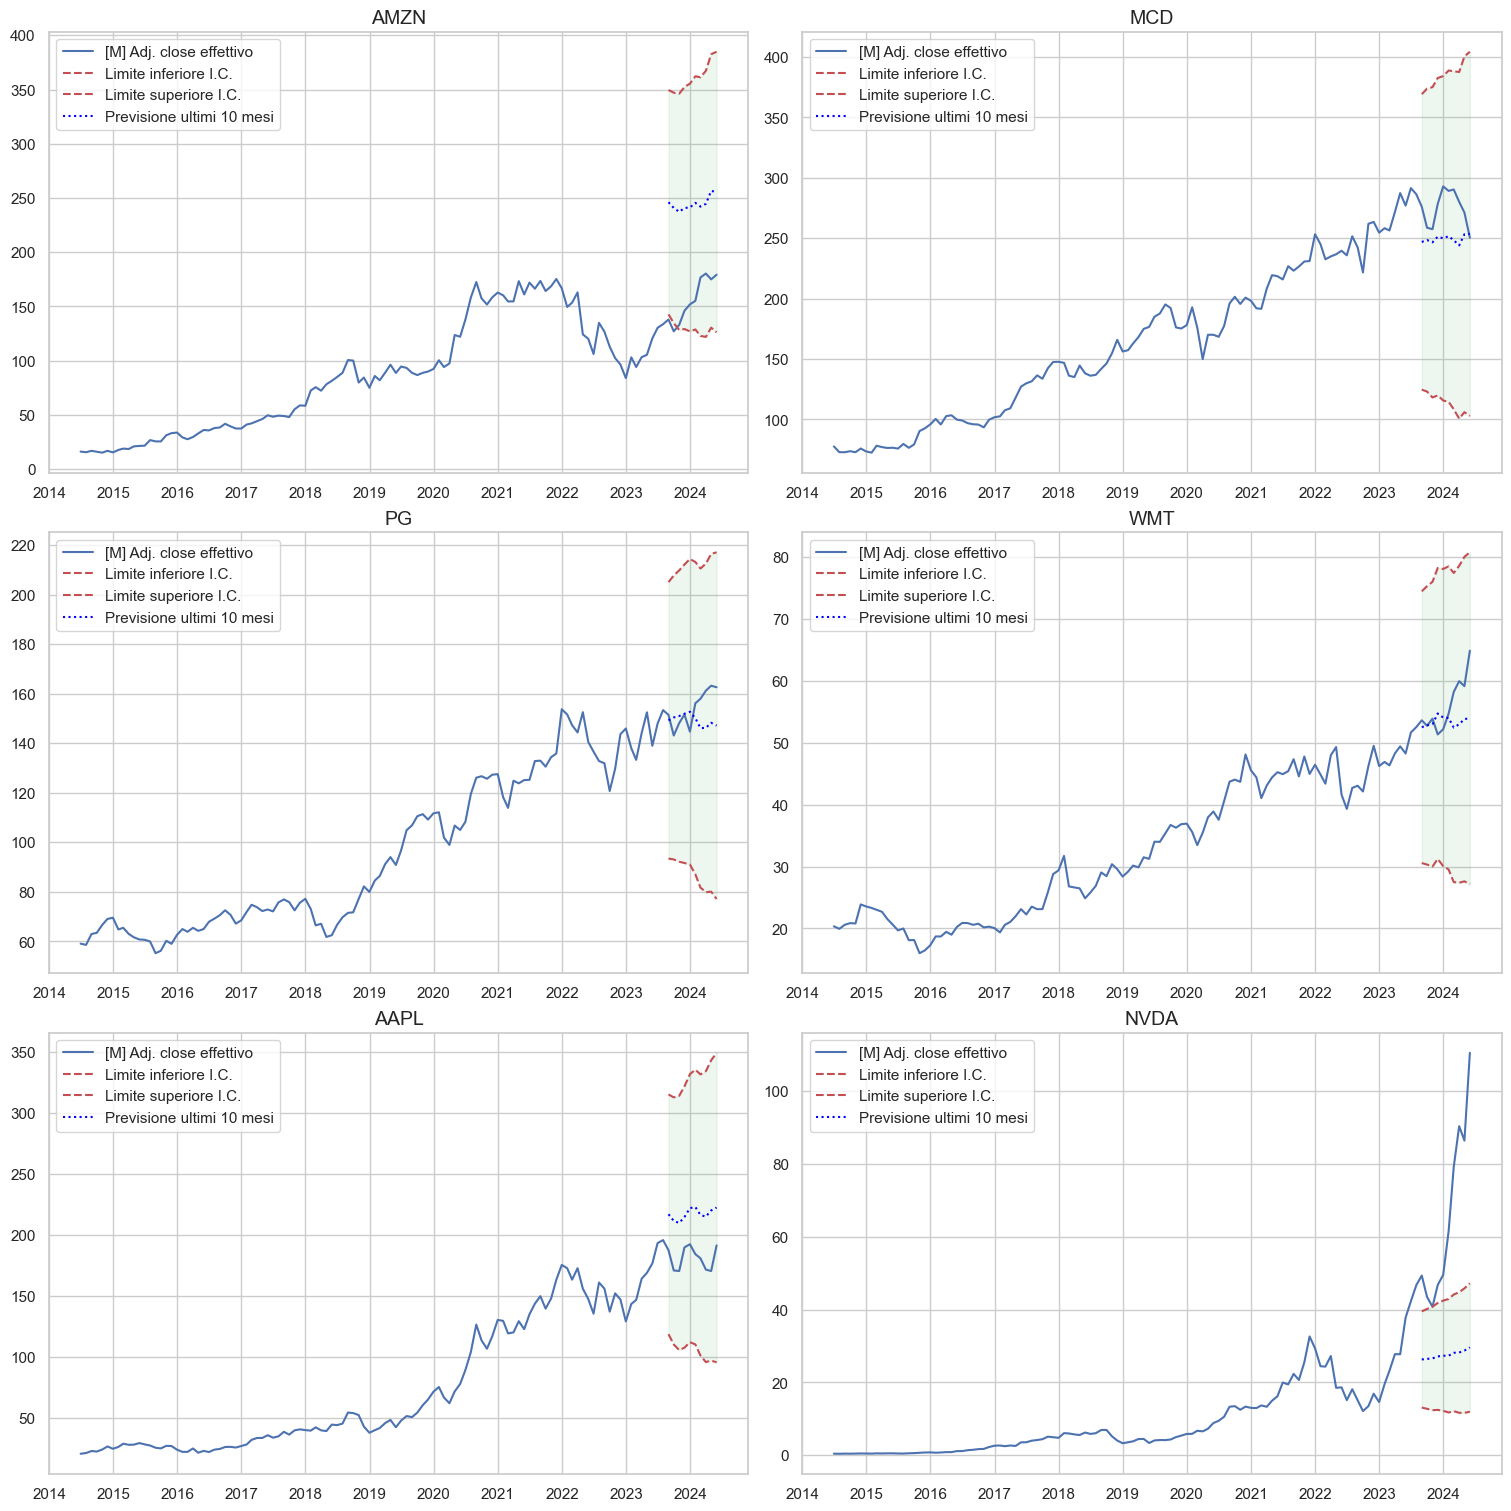

In [ ]:
predictions_ic = {}  # intervalli di confidenza
forecasted_vals = {}  # valori

# Assicurati che il modello sia adatto e i modelli siano già stati creati
for name in tickers:
    prediction_ci = models.get(name).get_prediction(start=110, end=110+9).conf_int()  # I.C. di 10 predizioni
    forecasted_val = models.get(name).predict(start=110, end=110+9)  # Valori forecasted per gli ultimi 10 mesi

    predictions_ic[name] = prediction_ci
    forecasted_vals[name] = forecasted_val

(row, col) = (0, 0)

# Creazione della griglia di grafici
fig, axs = plt.subplots(3, 2, figsize=(15, 15), constrained_layout=True)

for name in tickers:
    ax = axs[row, col]

    col += 1
    if col == 2:
        col = 0
        row += 1

    ax.set_title(name, fontsize=14)

    # Grafico dei dati effettivi dal DataFrame 'df_settle'
    ax.plot(df_settle[name], label='[M] Adj. close effettivo')

    # Intervallo di confidenza
    ax.plot(predictions_ic[name].index, predictions_ic[name].iloc[:, 0], 'r--', label='Limite inferiore I.C.')
    ax.plot(predictions_ic[name].index, predictions_ic[name].iloc[:, 1], 'r--', label='Limite superiore I.C.')
    ax.fill_between(predictions_ic[name].index,
                    predictions_ic[name].iloc[:, 0],
                    predictions_ic[name].iloc[:, 1],
                    color='g', alpha=0.1)

    # Forecast degli ultimi 10 mesi
    ax.plot(forecasted_vals[name], label='Previsione ultimi 10 mesi', color='blue', linestyle='dotted')

    ax.grid(True)
    ax.legend()

plt.show()


Per ogni ticker Calcolo di MSE e RMSE, ultimi 10 mesi

In [ ]:
mse_scores = {}
rmse_scores = {}

for name in tickers:
    actual_vals = df_settle[name][-10:]  # Prendi gli ultimi 10 mesi di dati effettivi
    predicted_vals = forecasted_vals[name]  # Prendi le previsioni corrispondenti

    # Calcolo di MSE
    mse = mean_squared_error(actual_vals, predicted_vals)
    mse_scores[name] = round(mse, 4)  # Arrotonda a 4 cifre decimali

    # Calcolo di RMSE
    rmse = sqrt(mse)
    rmse_scores[name] = round(rmse, 4)  # Arrotonda a 4 cifre decimali

    print(f"{name} - MSE: {mse_scores[name]}, RMSE: {rmse_scores[name]}")


AMZN - MSE: 8144.1242, RMSE: 90.2448
MCD - MSE: 845.9254, RMSE: 29.0848
PG - MSE: 99.5646, RMSE: 9.9782
WMT - MSE: 24.6822, RMSE: 4.9681
AAPL - MSE: 1362.2338, RMSE: 36.9085
NVDA - MSE: 1939.2591, RMSE: 44.037


# 4 Stategie di trading e backtesting

a. Costruire una strategia di trading basata su un algoritmo a scelta che segnali l’acquisto
o la vendita di un titolo o indice di borsa e farne il backtesting
b. Misurare l’efficienza della strategia rispetto alla detenzione del titolo per tutto il periodo
(“Buy & Hold”);


Per semplicità, svilupperemo una strategia di trading basata sulle medie mobili incrociate. Questa strategia genera un segnale di 'acquisto' quando una media mobile a breve termine incrocia sopra una media mobile a lungo termine e un segnale di 'vendita' quando incrocia al di sotto.


In [ ]:
# Scaricare tutti i dati in una sola volta
data_dict = {}
for ticker in tickers:
    data_dict[ticker] = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


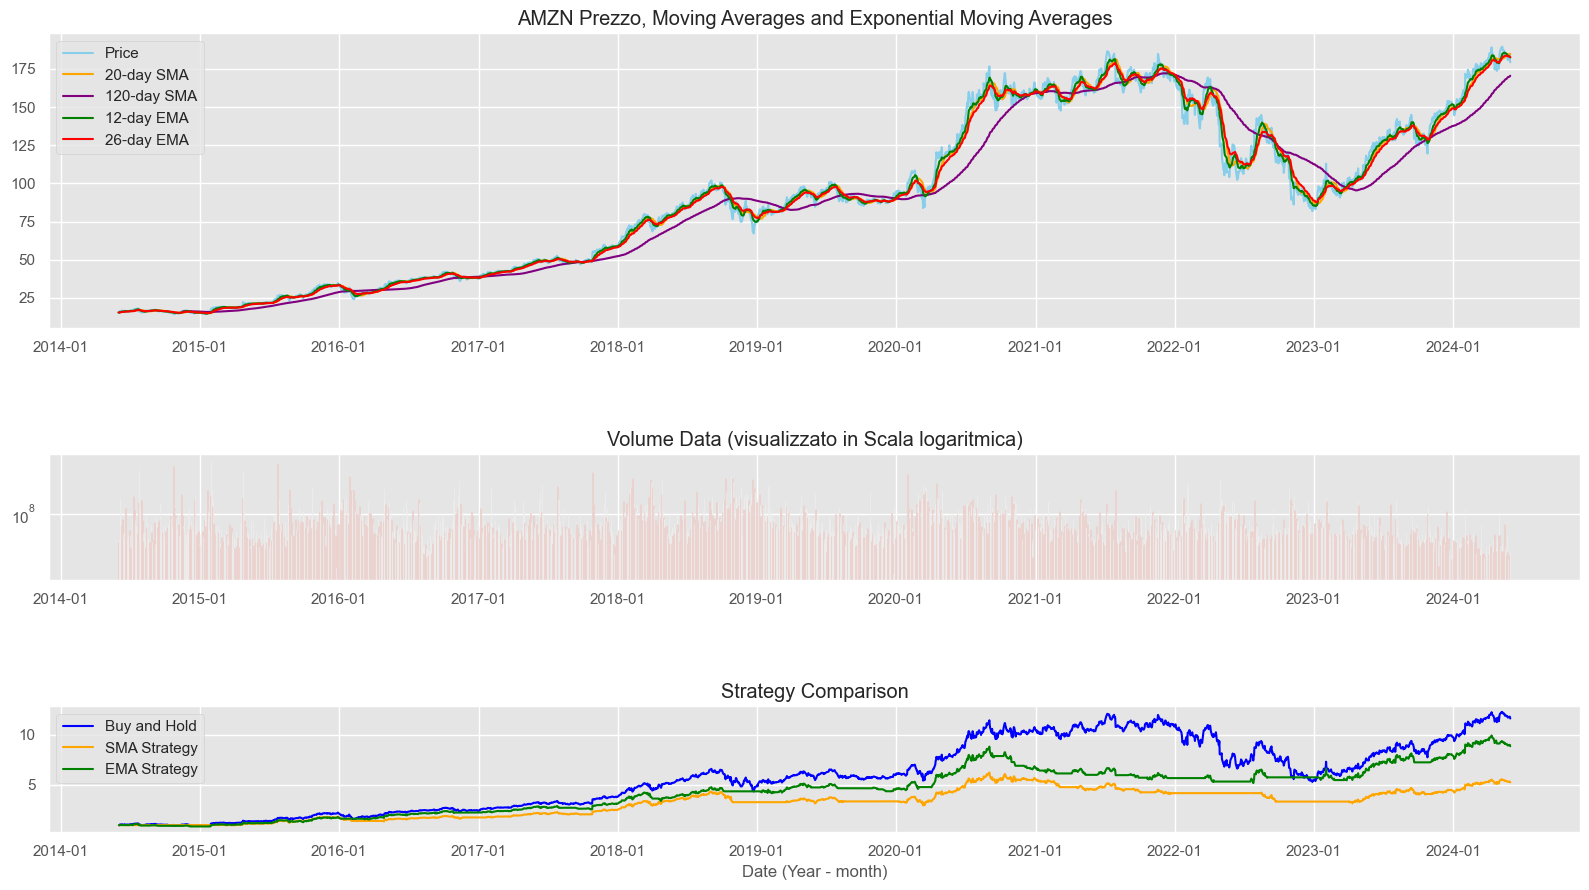

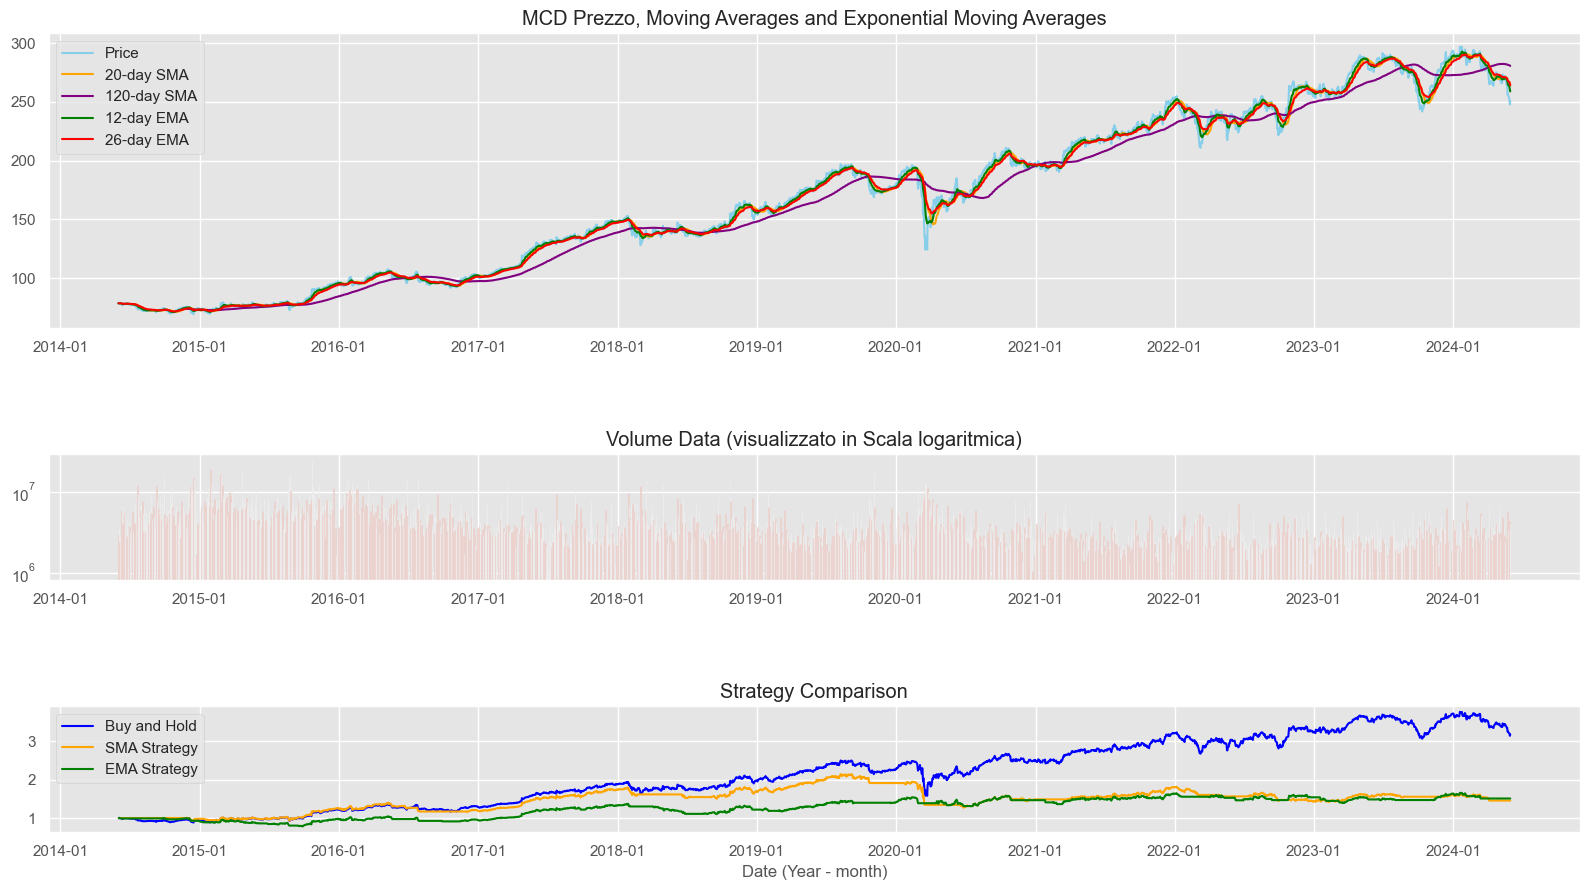

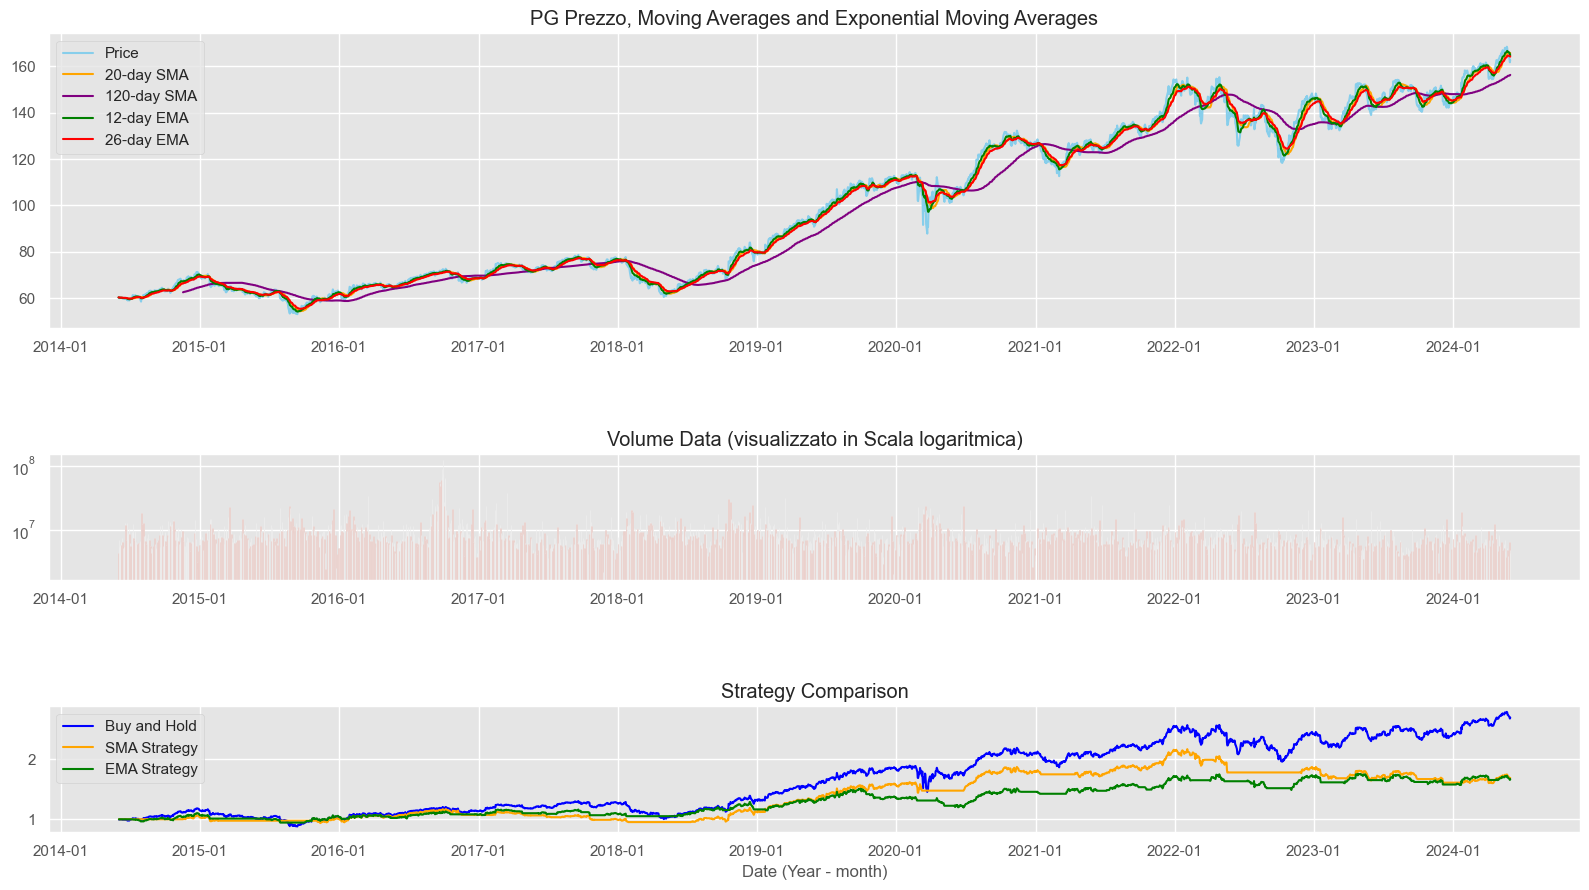

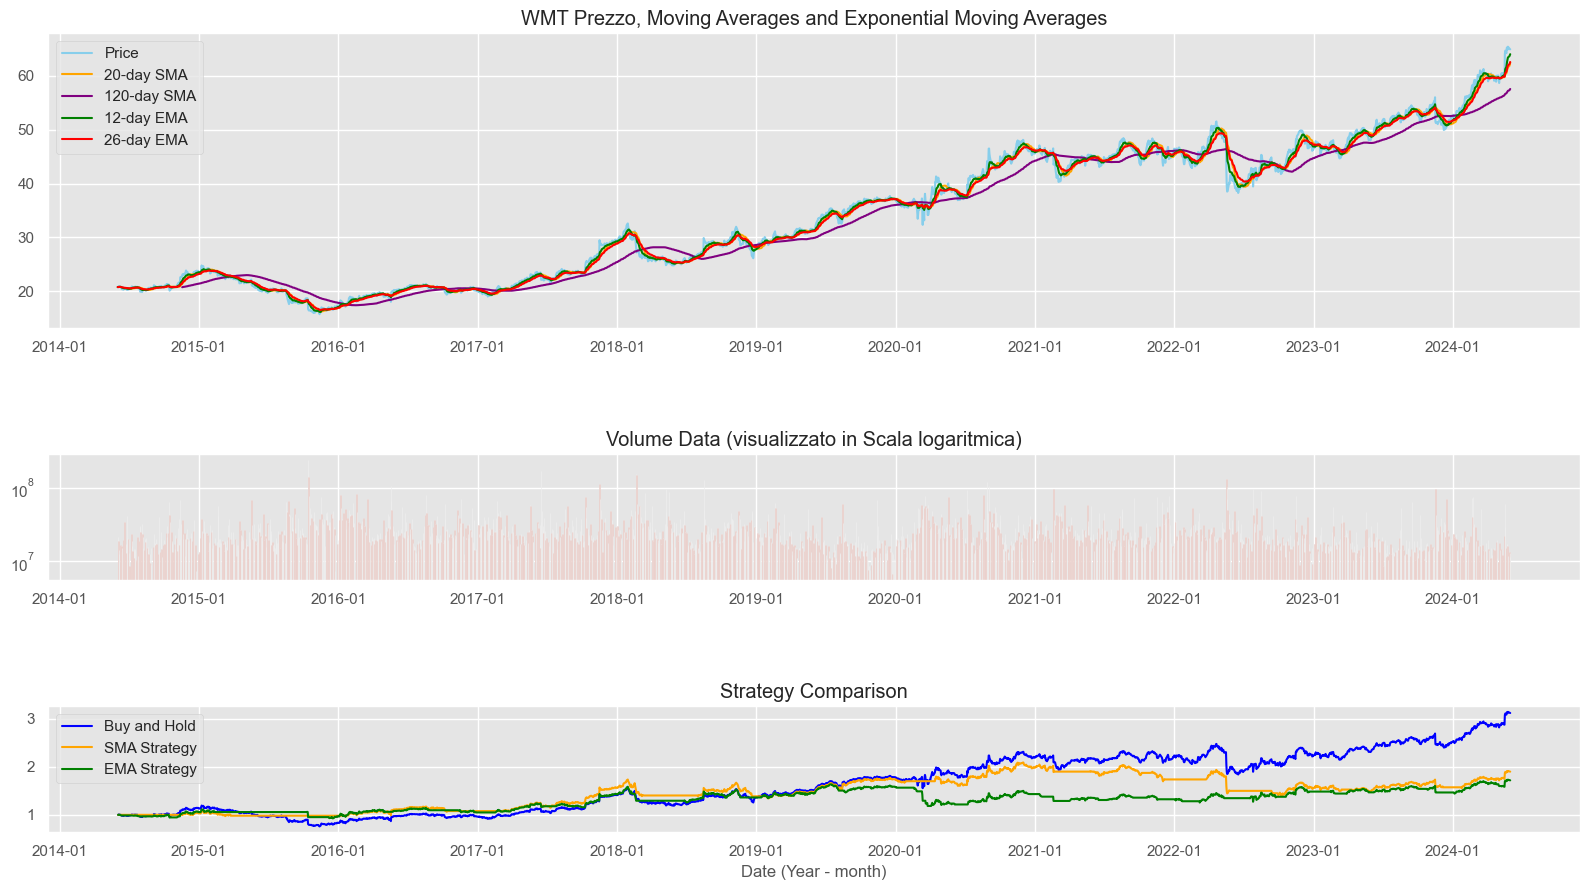

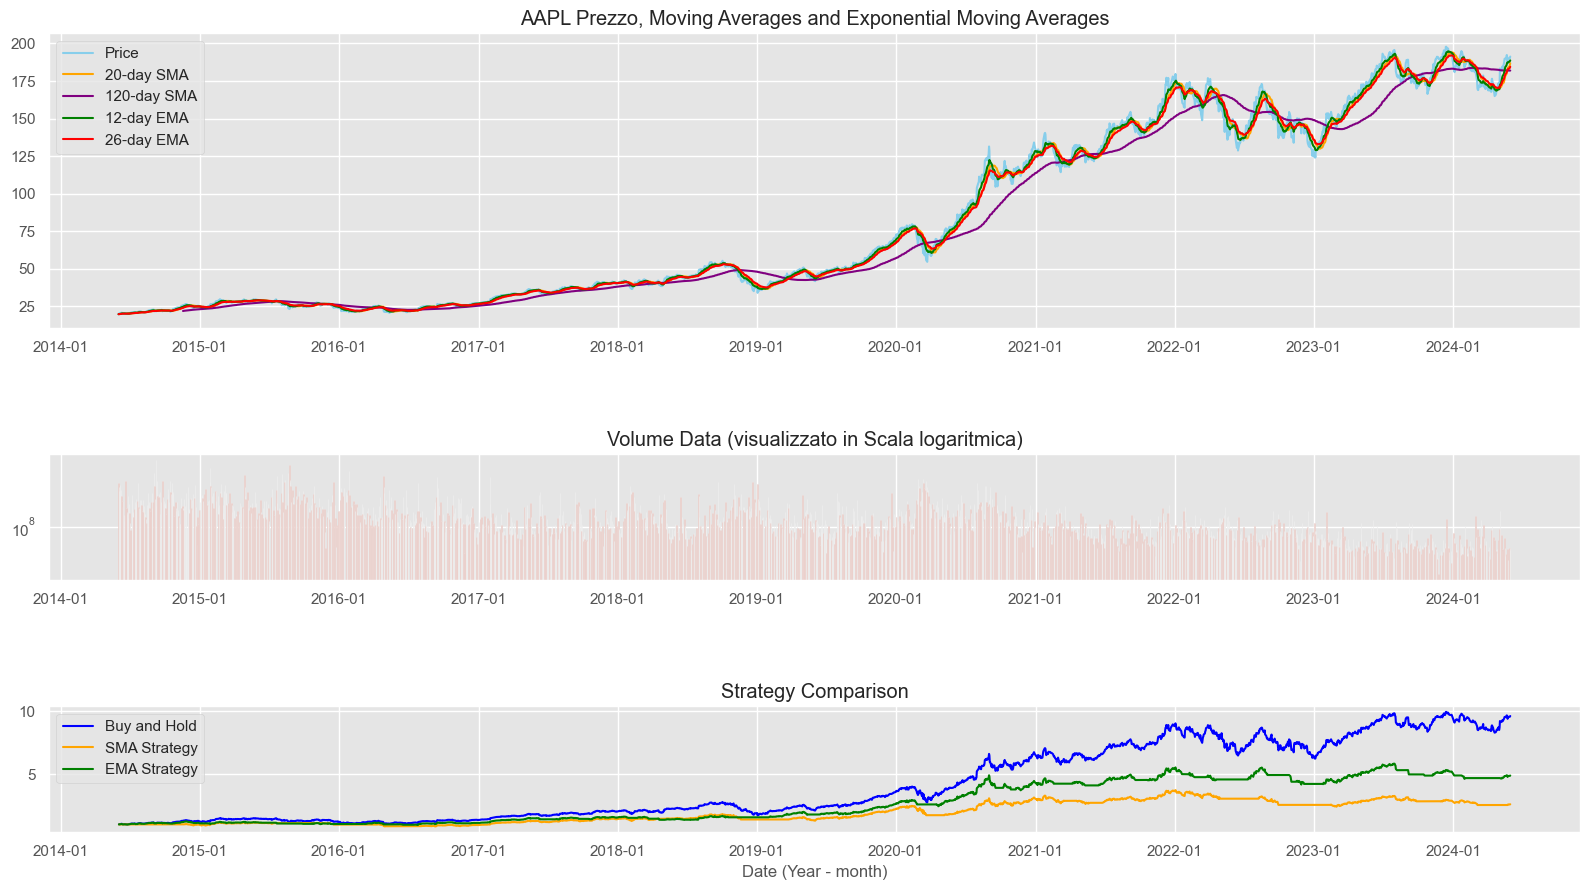

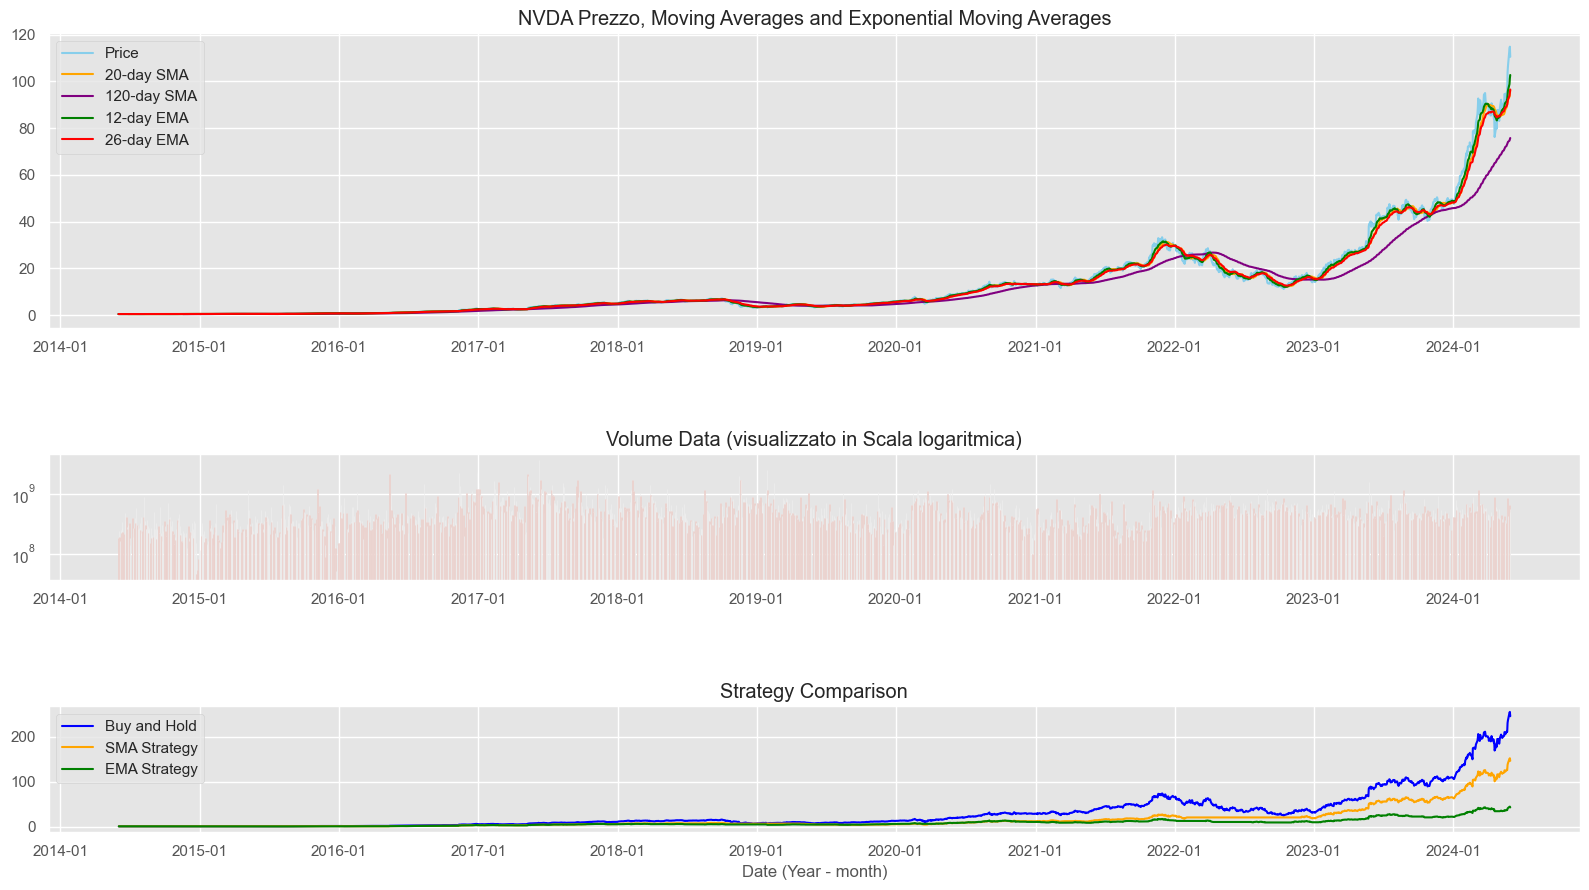

In [ ]:
plt.style.use('ggplot')

for ticker in tickers:
    data = data_dict[ticker] 
    data['SMA20'] = data['Adj Close'].rolling(window=20).mean() # Simple Moving Average 20
    data['SMA120'] = data['Adj Close'].rolling(window=120).mean() # Simple Moving Average 120
    data['EMA12'] = data['Adj Close'].ewm(span=12, adjust=False).mean() # Exponential Moving Average 12
    data['EMA26'] = data['Adj Close'].ewm(span=26, adjust=False).mean() # Exponential Moving Average 26
    data['Return'] = data['Adj Close'] / data['Adj Close'].shift(1) - 1 # Calcolo dei rendimenti -> 
    data['Cumulative Return'] = (1 + data['Return']).cumprod() # Calcolo dei rendimenti cumulativi -> 
    data['SMA Position'] = (data['SMA20'] > data['SMA120']).astype(int).shift(1) # Calcolo della posizione SMA
    data['SMA Strategy Returns'] = data['Return'] * data['SMA Position'] # Calcolo dei rendimenti della strategia SMA
    data['SMA Cumulative Returns'] = (1 + data['SMA Strategy Returns']).cumprod() # Calcolo dei rendimenti cumulativi della strategia SMA
    data['EMA Position'] = (data['EMA12'] > data['EMA26']).astype(int).shift(1) # Calcolo della posizione EMA
    data['EMA Strategy Returns'] = data['Return'] * data['EMA Position'] # Calcolo dei rendimenti della strategia EMA
    data['EMA Cumulative Returns'] = (1 + data['EMA Strategy Returns']).cumprod() # Calcolo dei rendimenti cumulativi della strategia EMA

    # Plots
    plt.figure(figsize=(16,9))
    ax1 = plt.subplot2grid((10,1), (0,0), rowspan=4, colspan=1)
    ax2 = plt.subplot2grid((10,1), (5,0), rowspan=2, colspan=1, sharex=ax1)
    ax3 = plt.subplot2grid((10,1), (8,0), rowspan=2, colspan=1, sharex=ax1)

    # Plotto price, SMAs, and EMAs
    ax1.plot(data.index, data['Adj Close'], label='Price', color='skyblue')
    ax1.plot(data.index, data['SMA20'], label='20-day SMA', color='orange')
    ax1.plot(data.index, data['SMA120'], label='120-day SMA', color='purple')
    ax1.plot(data.index, data['EMA12'], label='12-day EMA', color='green')
    ax1.plot(data.index, data['EMA26'], label='26-day EMA', color='red')
    ax1.set_title(f'{ticker} Prezzo, Moving Averages and Exponential Moving Averages')
    ax1.legend()

    # Plot volume
    ax2.bar(data.index, data['Volume'])
    ax2.set_yscale('log')  # Using logarithmic scale
    ax2.set_title('Volume Data (visualizzato in Scala logaritmica)')

    # Plotting confronto strategie
    ax3.plot(data.index, data['Cumulative Return'], label='Buy and Hold', color='blue')
    ax3.plot(data.index, data['SMA Cumulative Returns'], label='SMA Strategy', color='orange')
    ax3.plot(data.index, data['EMA Cumulative Returns'], label='EMA Strategy', color='green')
    ax3.set_title('Strategy Comparison')
    ax3.legend()

    # Formatting the date on the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax3.set_xlabel('Date (Year - month)')

    plt.tight_layout()
    plt.show()


Ticker: AMZN
EMA Buy signals: 41
EMA Sell signals: 40
Days without signals: 2436


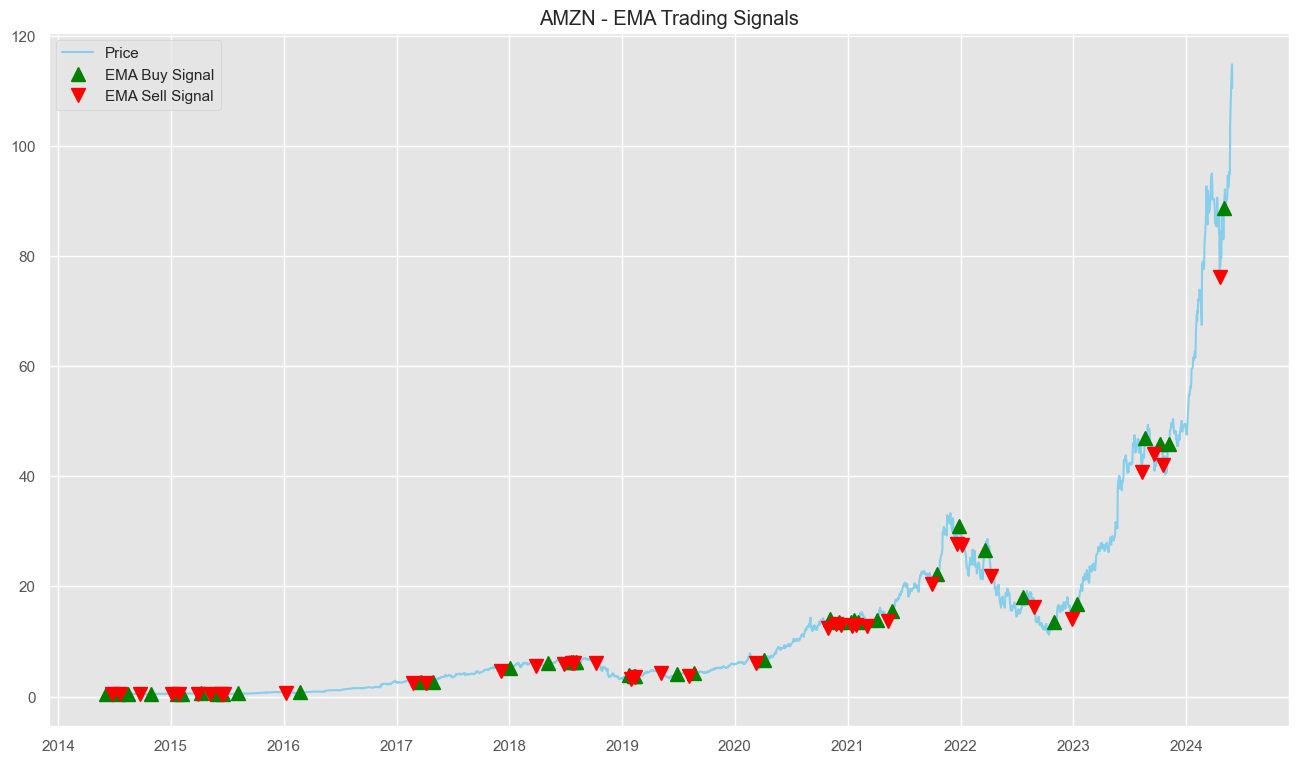

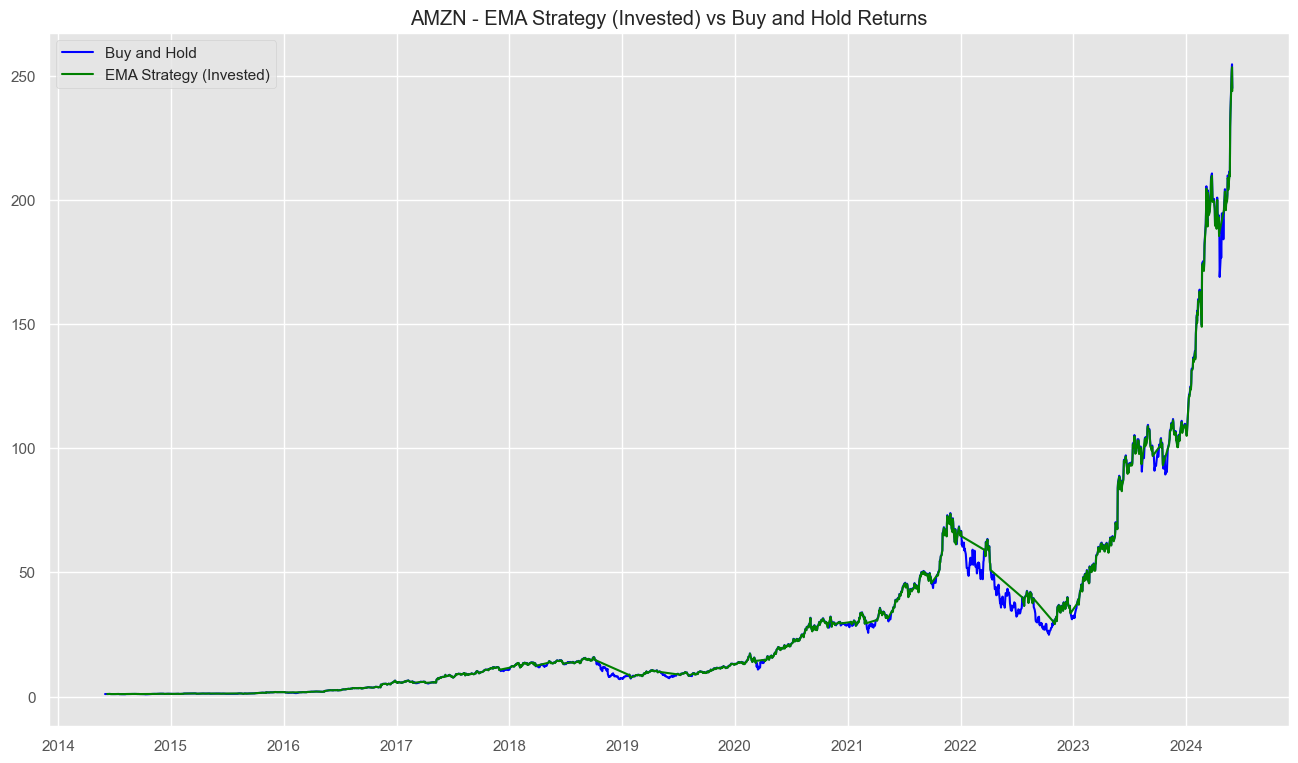

Ticker: MCD
EMA Buy signals: 41
EMA Sell signals: 40
Days without signals: 2436


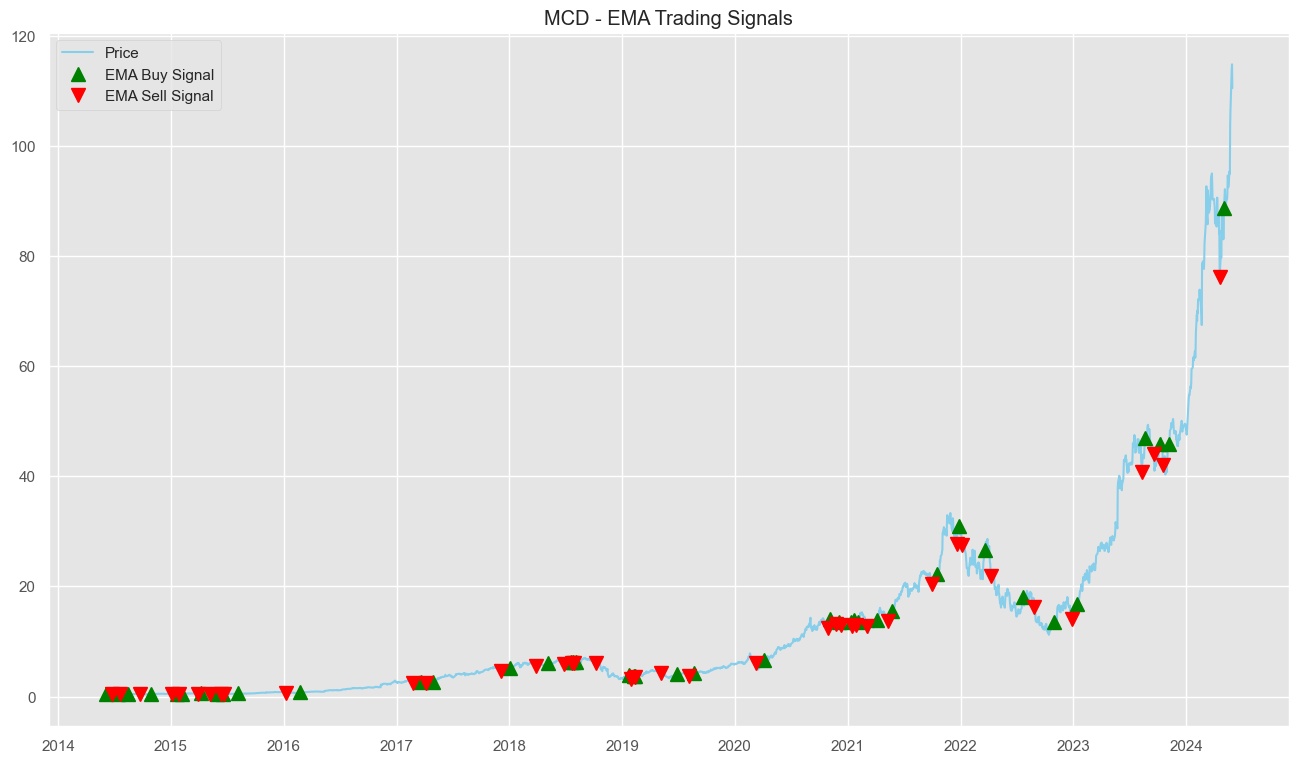

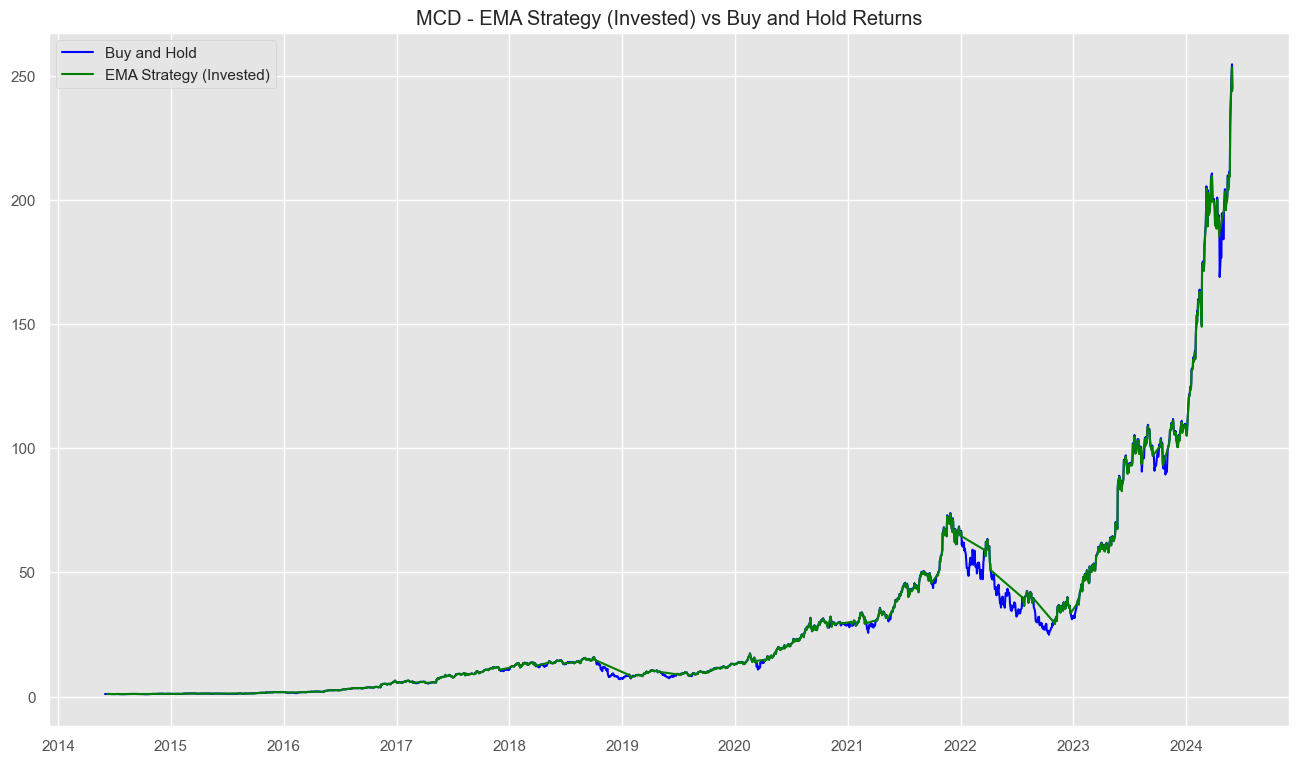

Ticker: PG
EMA Buy signals: 41
EMA Sell signals: 40
Days without signals: 2436


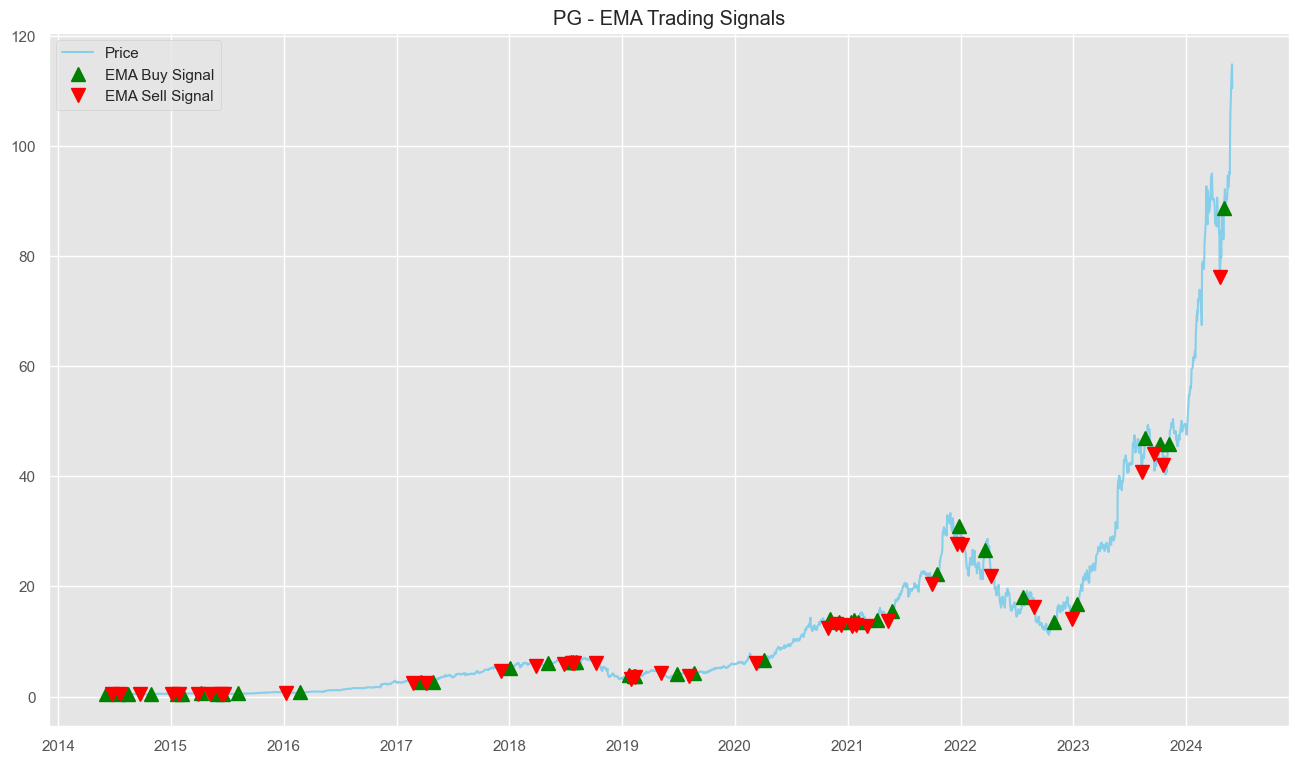

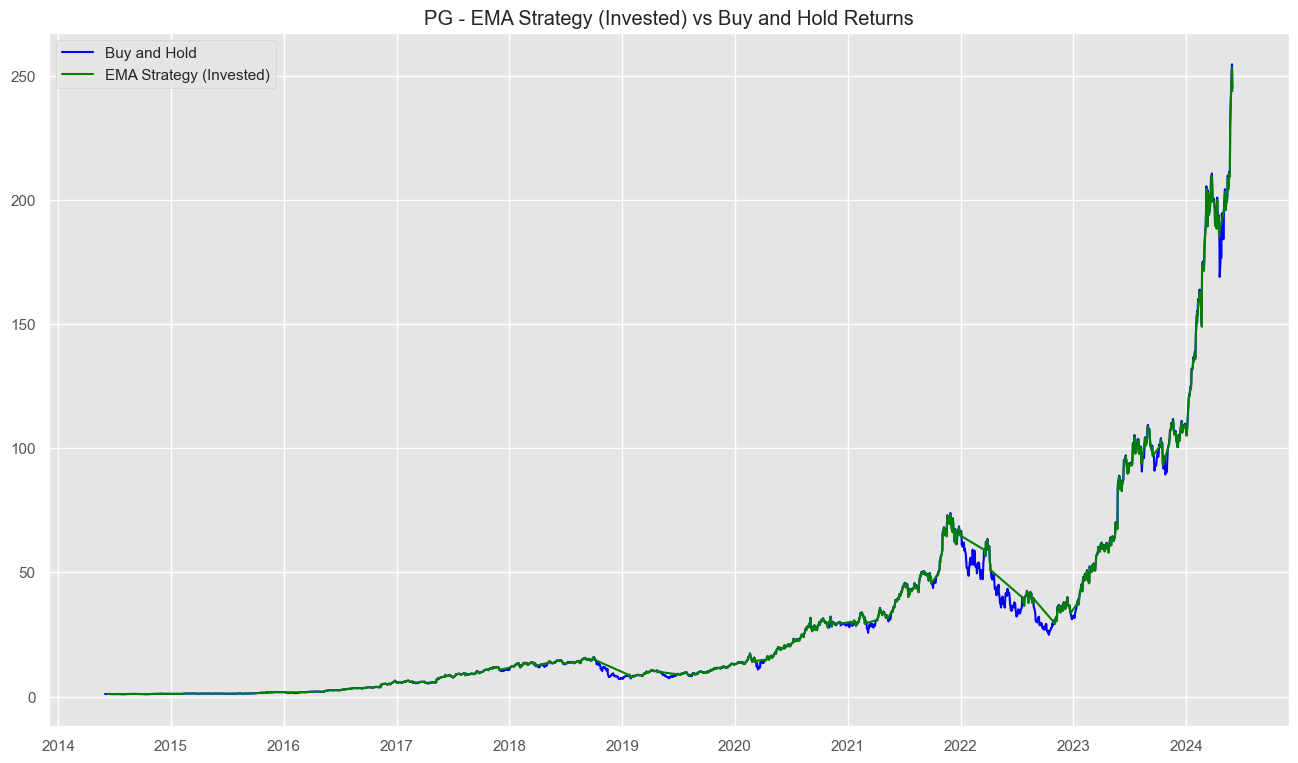

Ticker: WMT
EMA Buy signals: 41
EMA Sell signals: 40
Days without signals: 2436


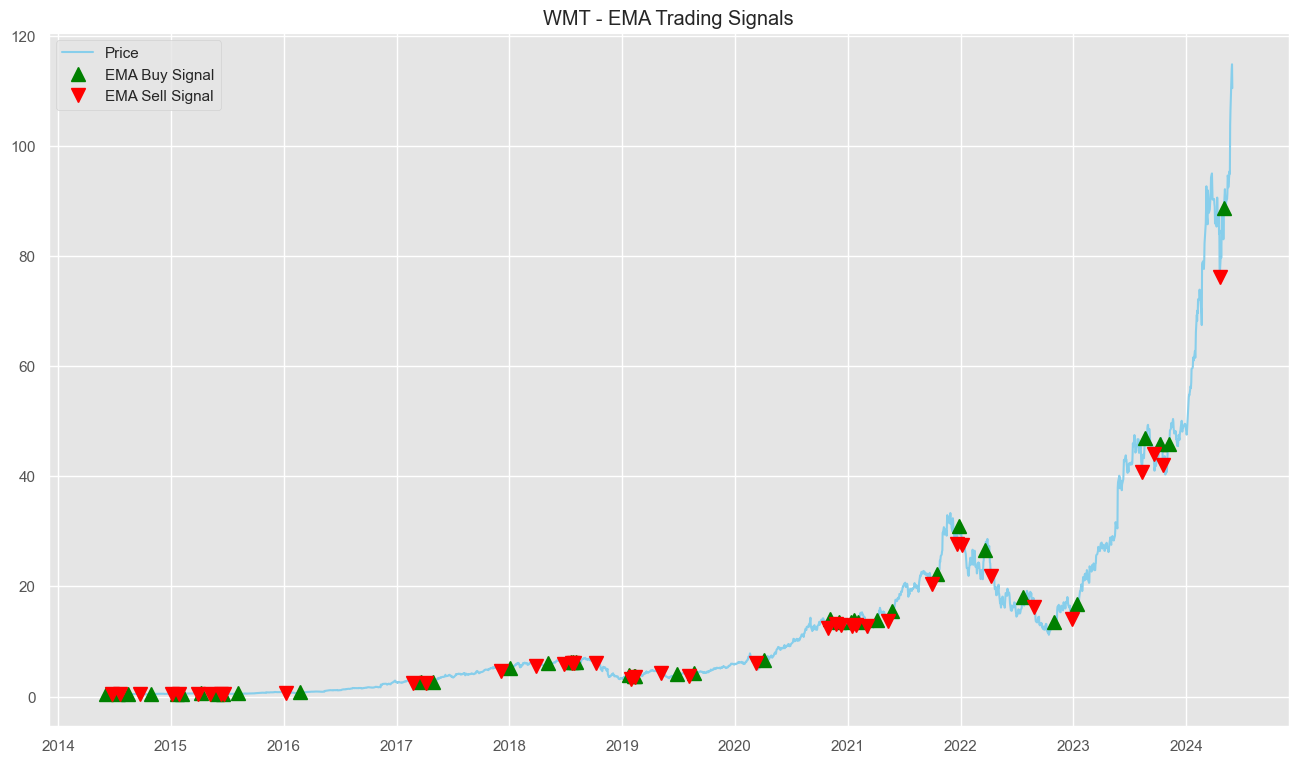

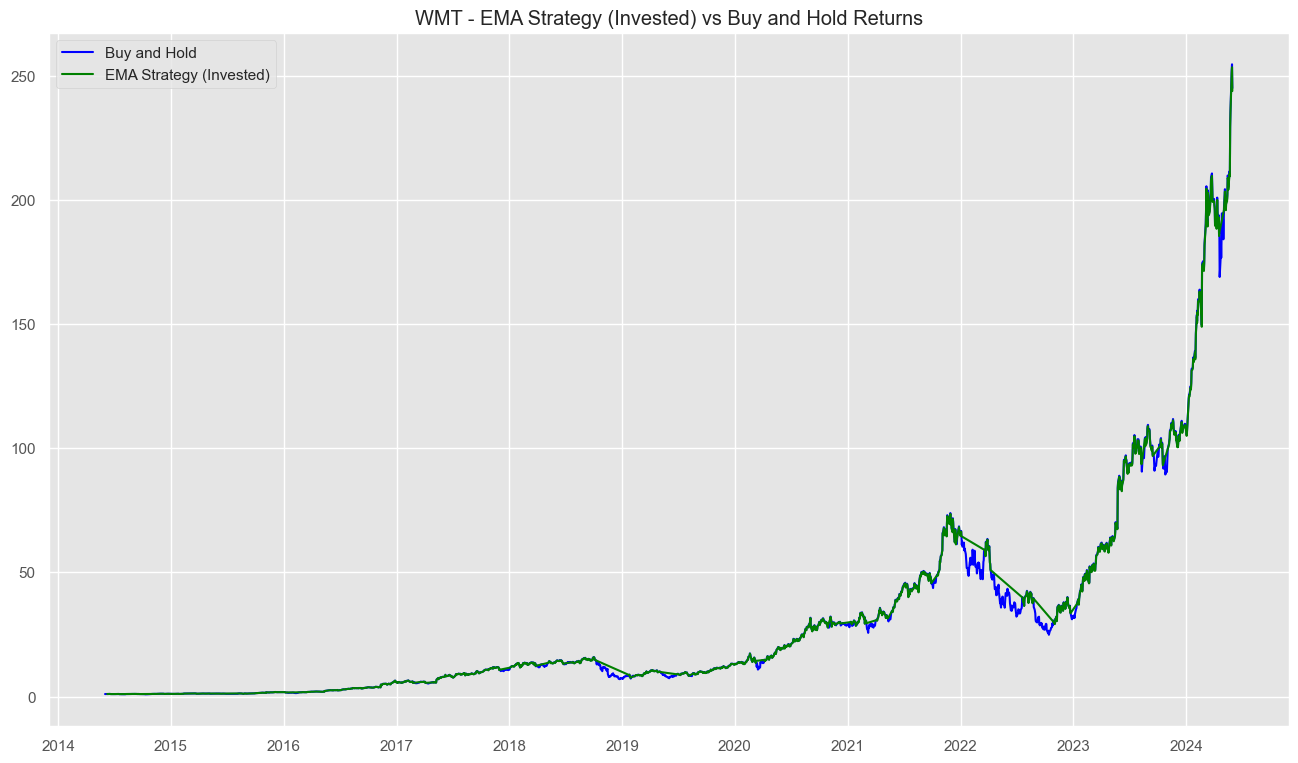

Ticker: AAPL
EMA Buy signals: 41
EMA Sell signals: 40
Days without signals: 2436


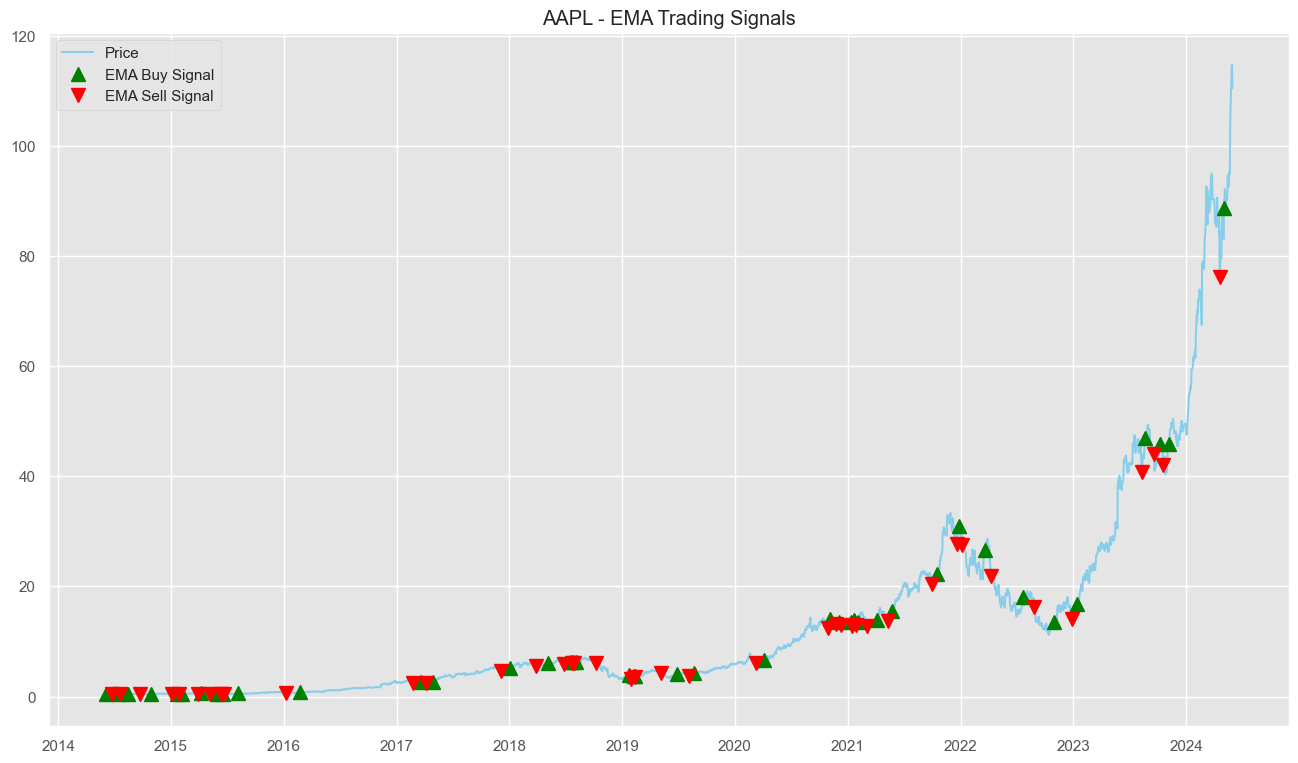

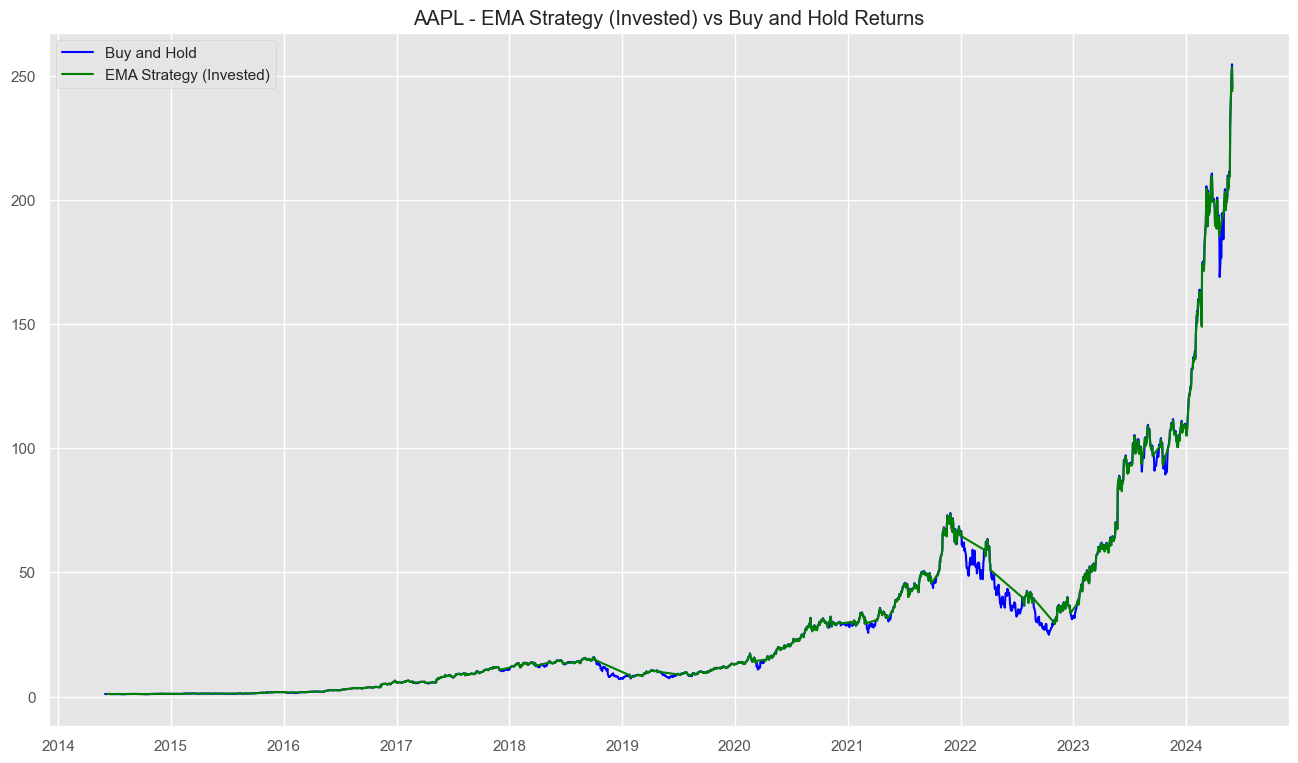

Ticker: NVDA
EMA Buy signals: 41
EMA Sell signals: 40
Days without signals: 2436


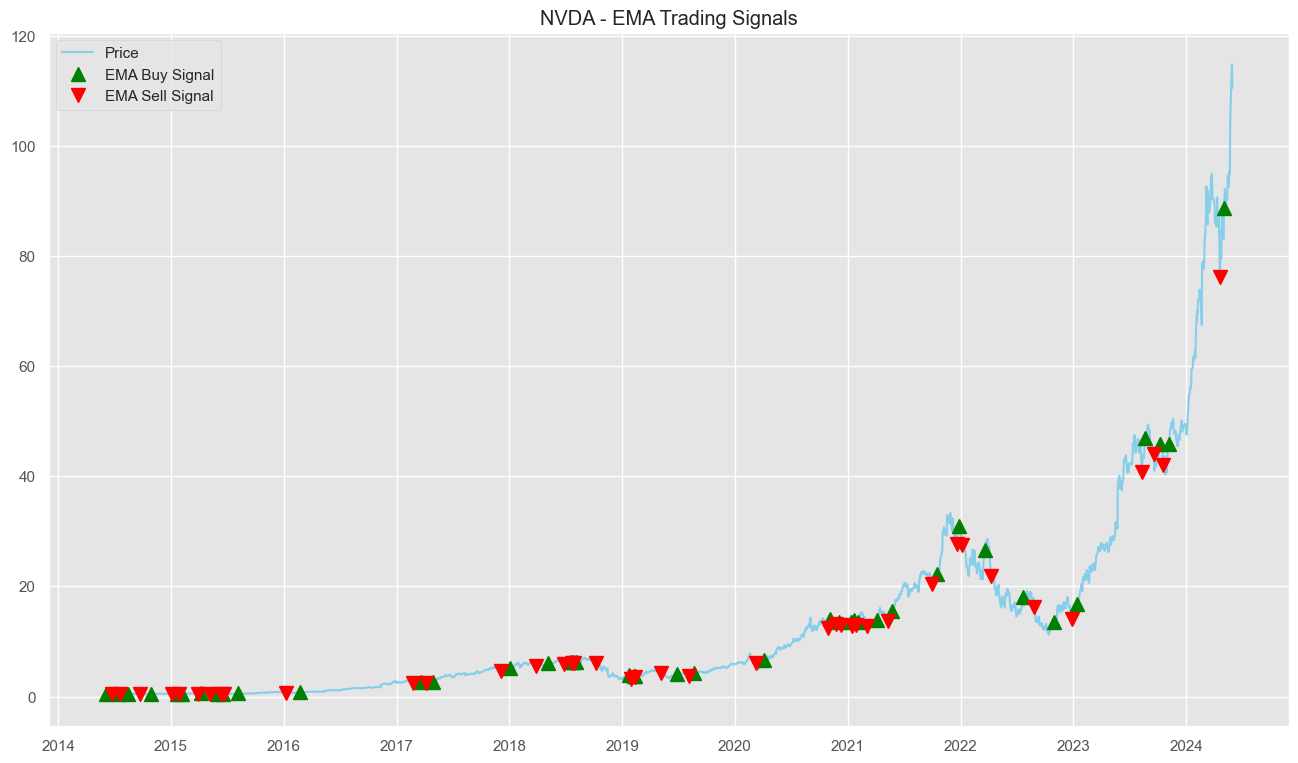

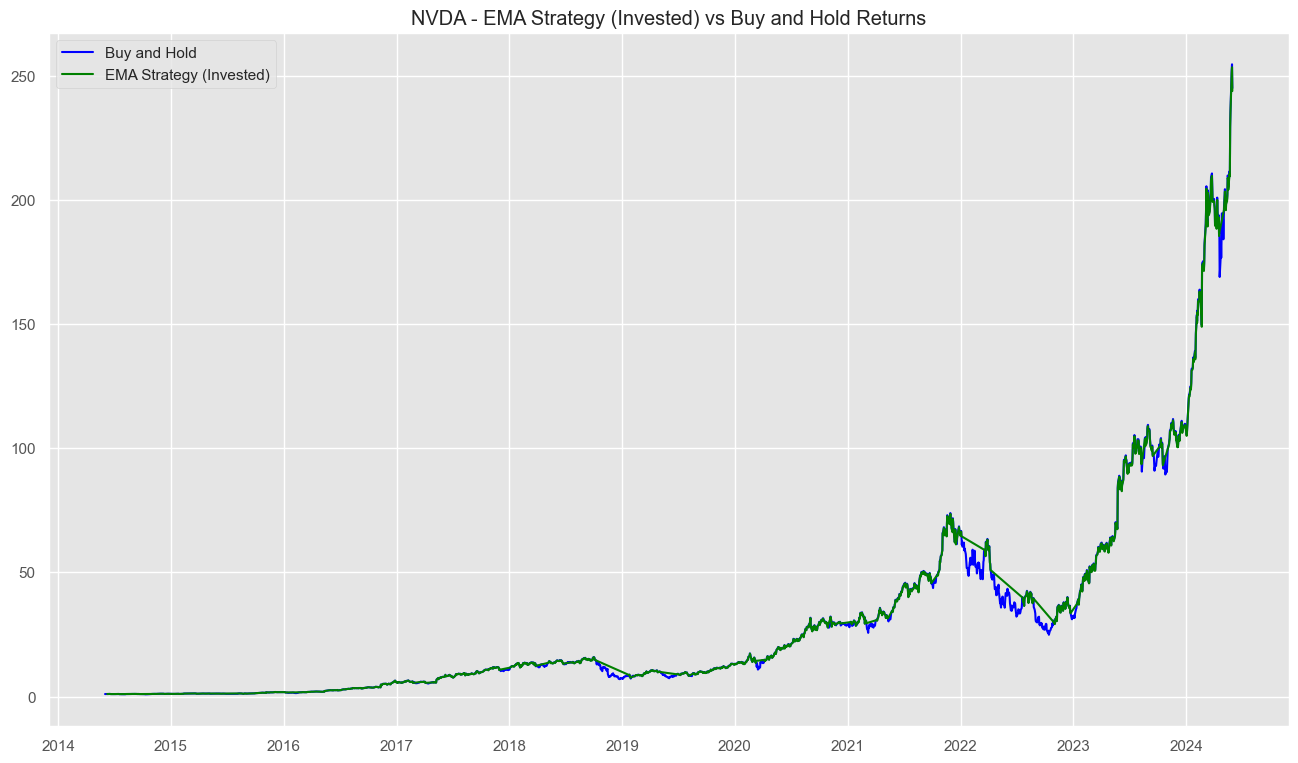

In [ ]:
for ticker in tickers:
    # Calcola le EMA
    data['EMA12'] = data['Adj Close'].ewm(span=12, adjust=False).mean()
    data['EMA26'] = data['Adj Close'].ewm(span=26, adjust=False).mean()

    # Strategia 1: Segnali di acquisto e vendita basati sulle EMA
    data['EMA Buy'] = ((data['EMA12'] > data['EMA26']) & (data['EMA12'].shift(1) < data['EMA26'].shift(1))).astype(int)
    data['EMA Sell'] = ((data['EMA12'] < data['EMA26']) & (data['EMA12'].shift(1) > data['EMA26'].shift(1))).astype(int)

    # Strategia 2: Investimento basato sulla relazione delle EMA
    data['Invested_EWM'] = [1 if data.loc[i, 'EMA12'] > data.loc[i, 'EMA26'] else 0 for i in data.index]
    ewm = data[data['Invested_EWM'] == 1].copy()
    ewm['Price_yesterday'] = ewm['Adj Close'].shift(1)
    ewm['Change'] = ewm['Adj Close'] / ewm['Price_yesterday']
    ewm['Return'] = ewm['Change'].cumprod()

    # Strategia 3: Buy and Hold
    data['Buy_Hold_Return'] = data['Adj Close'] / data['Adj Close'].iloc[0]

    # Conta i segnali per la Strategia 1
    ema_buys = data['EMA Buy'].sum()
    ema_sells = data['EMA Sell'].sum()
    no_signal_days = len(data) - (ema_buys + ema_sells)

    # Output dei conteggi per la Strategia 1
    print(f'Ticker: {ticker}')
    print(f'EMA Buy signals: {ema_buys}')
    print(f'EMA Sell signals: {ema_sells}')
    print(f'Days without signals: {no_signal_days}')

    # Grafico del prezzo e dei segnali per la Strategia 1
    plt.figure(figsize=(16,9))
    plt.plot(data.index, data['Adj Close'], label='Price', color='skyblue')
    plt.plot(data[data['EMA Buy'] == 1].index, data['Adj Close'][data['EMA Buy'] == 1], '^', markersize=10, color='green', label='EMA Buy Signal')
    plt.plot(data[data['EMA Sell'] == 1].index, data['Adj Close'][data['EMA Sell'] == 1], 'v', markersize=10, color='red', label='EMA Sell Signal')
    plt.title(f'{ticker} - EMA Trading Signals')
    plt.legend()
    plt.show()

    # Grafico dei ritorni cumulativi per la strategia EMA (Invested) e Buy and Hold
    plt.figure(figsize=(16,9))
    plt.plot(data.index, data['Buy_Hold_Return'], label='Buy and Hold', color='blue')
    plt.plot(ewm.index, ewm['Return'], label='EMA Strategy (Invested)', color='green')
    plt.title(f'{ticker} - EMA Strategy (Invested) vs Buy and Hold Returns')
    plt.legend()
    plt.show()


# 5. CAPM

In [ ]:
market_returns = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close'].resample('M').ffill().pct_change()

[*********************100%%**********************]  1 of 1 completed


In [ ]:
betas = {}
monthly_returns = {}
stock_returns = adjusted_close_df.resample('M').ffill().pct_change() # Calcola i rendimenti mensili di ogni ticker

In [ ]:
def calculate_beta(asset_returns, market_returns):
    """Calcola il beta di un asset rispetto al mercato."""
    df = pd.DataFrame({
        'asset': asset_returns,
        'market': market_returns
    })
    covariance = df.cov().loc['asset', 'market']
    variance_market = df['market'].var()
    return covariance / variance_market

In [ ]:
for ticker in tickers:
    monthly_return_asset = stock_returns[ticker]
    beta = calculate_beta(monthly_return_asset, market_returns)
    
    betas[ticker] = beta
    monthly_returns[ticker] = monthly_return_asset

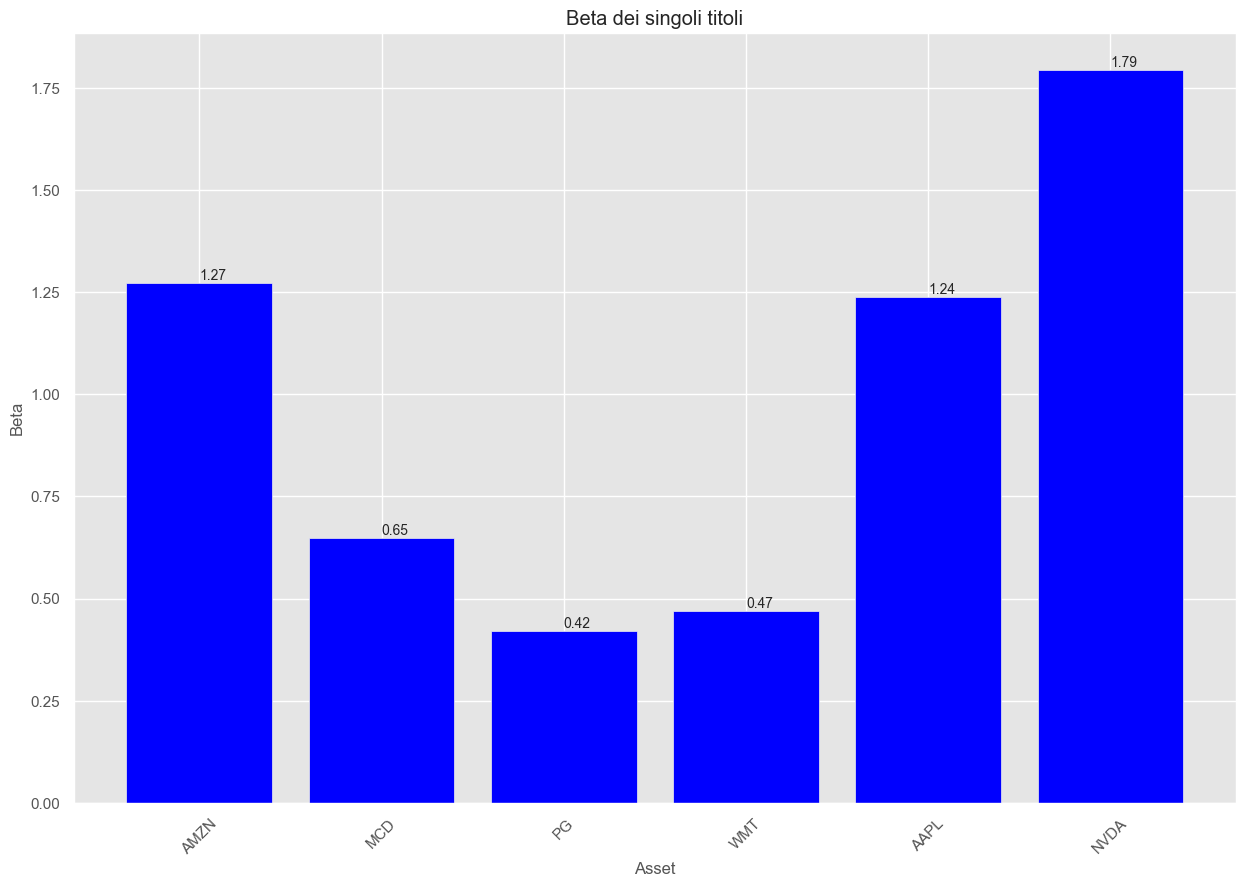

In [ ]:
# Plot dei beta dei singoli titoli
plt.figure(figsize=(15, 10))
bars = plt.bar(betas.keys(), betas.values(), color='blue')
plt.xlabel('Asset')
plt.ylabel('Beta')
plt.title('Beta dei singoli titoli')
plt.xticks(rotation=45)

# Aggiungere le etichette dei valori di beta sopra le barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')
plt.show()

In [ ]:
# Definisci le stime di rendimento
rf = 0.0507    # Rendimento T-Bill a 1 anno 
rm = 0.08   # Rendimento atteso dell'S&P 500

In [ ]:
# Calcola il rendimento atteso per ogni titolo usando CAPM
expected_returns = {}
for ticker, beta in betas.items():
    expected_return = rf + beta * (rm - rf)
    expected_returns[ticker] = expected_return

# Stampa i risultati
print("Rendimenti attesi annuali:")
for ticker, exp_return in expected_returns.items():
    print(f"{ticker}: {exp_return:.2%}")

Rendimenti attesi annuali:
AMZN: 8.80%
MCD: 6.97%
PG: 6.31%
WMT: 6.45%
AAPL: 8.70%
NVDA: 10.33%


[*********************100%%**********************]  6 of 6 completed


            AAPL      AMZN       MCD      NVDA        PG       WMT
const   0.018409  0.022044  0.011235  0.056230  0.009302  0.010288
Mkt-RF  0.821083  0.765160  0.793572  2.291185  1.342862  1.142124
SMB    -2.512365 -3.213330 -2.293740 -0.567894 -0.890028 -1.193961
HML    -1.736640 -1.472101 -0.593711 -0.306700 -0.747877 -0.640861


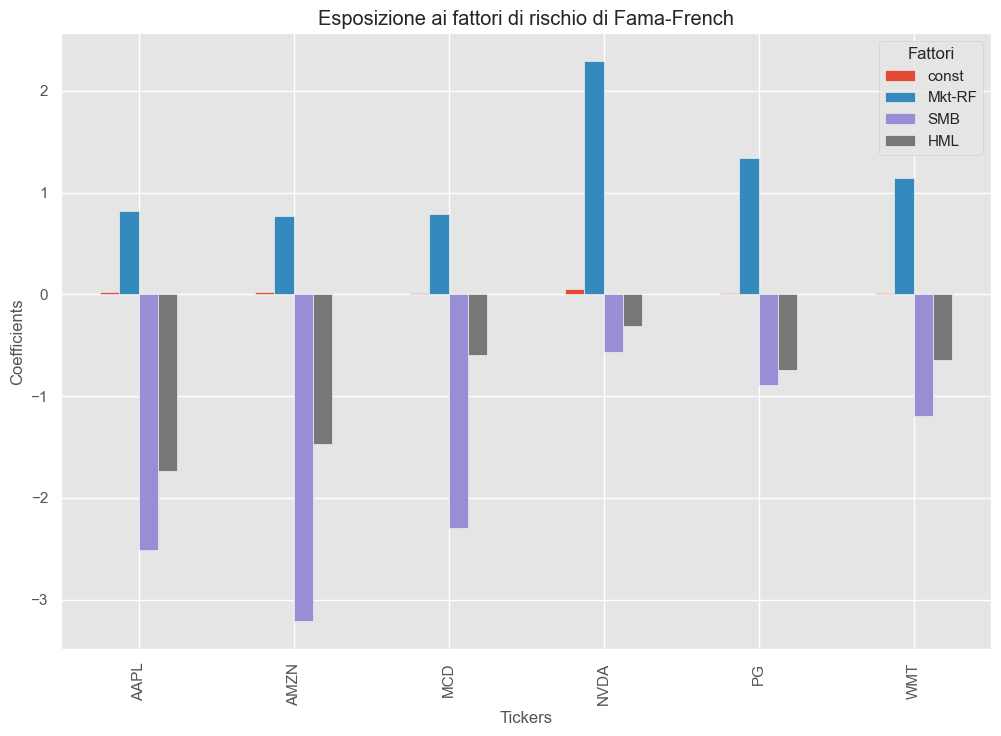

In [ ]:
import statsmodels.api as sm
# Funzione per scaricare e pulire i dati dei fattori di Fama-French
def get_fama_french_factors():
    url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip'
    response = requests.get(url)
    with ZipFile(BytesIO(response.content)) as z:
        with z.open('F-F_Research_Data_Factors_daily.CSV') as f:
            fama_french_factors = pd.read_csv(f, skiprows=3, index_col=0)
    
    # Rimuovi eventuali righe non necessarie
    fama_french_factors = fama_french_factors[~fama_french_factors.index.str.contains('Copyright')]
    
    # Converti l'indice in formato datetime
    fama_french_factors.index = pd.to_datetime(fama_french_factors.index, format='%Y%m%d')
    fama_french_factors = fama_french_factors[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100  # Converti i valori in percentuale
    return fama_french_factors

# Scarica i dati dei fattori di Fama-French
fama_french_factors = get_fama_french_factors()

# Converti i dati in base mensile
fama_french_factors = fama_french_factors.resample('M').last()

# Filtra l'intervallo richiesto
fama_french_factors = fama_french_factors['2014-05-31':'2024-04-30']

data = yf.download(tickers, start='2014-05-31', end='2024-04-30')['Adj Close']

# Calcola i rendimenti mensili
returns = data.resample('M').last().pct_change().dropna()

# Allinea i dati dei fattori di Fama-French con i dati dei rendimenti
factor_df = fama_french_factors.loc[returns.index]

# Calcola l'excess return dei titoli
excess_returns = returns.subtract(factor_df['RF'].values, axis=0)

# Funzione per calcolare l'esposizione ai fattori di rischio di Fama-French
def calculate_exposure(excess_returns, factor_df):
    exposures = {}
    for ticker in excess_returns.columns:
        y = excess_returns[ticker]
        X = factor_df[['Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)  # Aggiungi l'intercetta
        model = sm.OLS(y, X).fit()
        exposures[ticker] = model.params
    return pd.DataFrame(exposures)

# Calcola l'esposizione ai fattori di rischio di Fama-French
exposures = calculate_exposure(excess_returns, factor_df)
print(exposures)

# Visualizza i risultati
exposures.T.plot(kind='bar', figsize=(12, 8))
plt.title('Esposizione ai fattori di rischio di Fama-French')
plt.ylabel('Coefficients')
plt.xlabel('Tickers')
plt.legend(title='Fattori')
plt.show()


# 6. Costruzione di portafoglio

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import plotting

In [ ]:
# Scarica i dati dei titoli da Yahoo Finance
tickers = ["AMZN", "MCD", "PG", "WMT", "AAPL", "NVDA"]
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  6 of 6 completed


In [ ]:
# Calcola i rendimenti e limita i dati ai primi 108 mesi
returns = data.pct_change().dropna().iloc[:108]

# Matrice di covarianza e rendimenti attesi
annual_returns = returns.mean() * 12  # rendimenti annui
covariance_matrix = returns.cov() * 12  # covarianza annua

Pesi ottimali (analitici): [0.00461951 0.03652    0.29631895 0.03105477 0.35915614 0.27233063]
Pesi ottimali (simulazione): [0.10840352 0.05817045 0.0326838  0.00849554 0.44941955 0.34282713]
Beta del portafoglio (analitico): 1.3504400643450516
Beta del portafoglio (simulato): 1.1976061972820047
Portafoglio Ottimale (Analitico): Rendimento Annualizzato: 15.48%, Volatilità Annualizzata: 13.33%, Sharpe Ratio: 1.16
Portafoglio Ottimale (Simulato): Rendimento Annualizzato: 15.19%, Volatilità Annualizzata: 14.09%, Sharpe Ratio: 1.08
Portafoglio Equamente Ponderato: Rendimento Annualizzato: 28.07%, Volatilità Annualizzata: 18.21%, Sharpe Ratio: 1.54


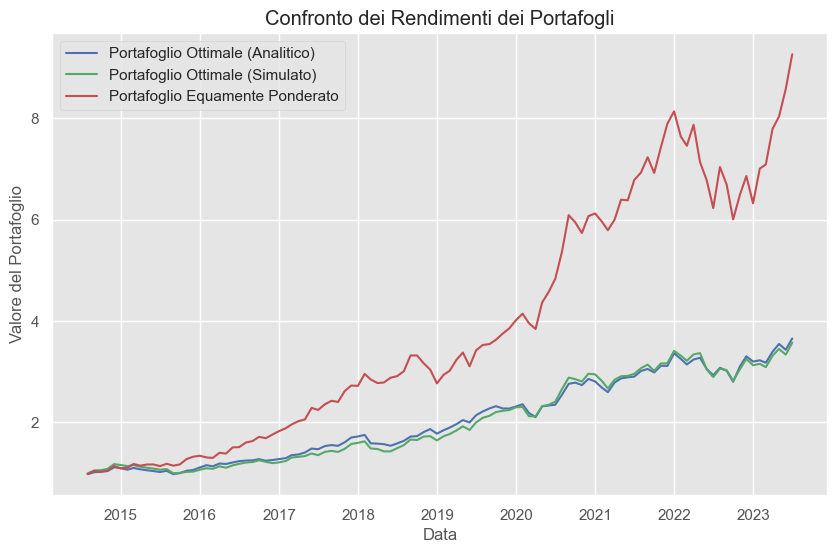

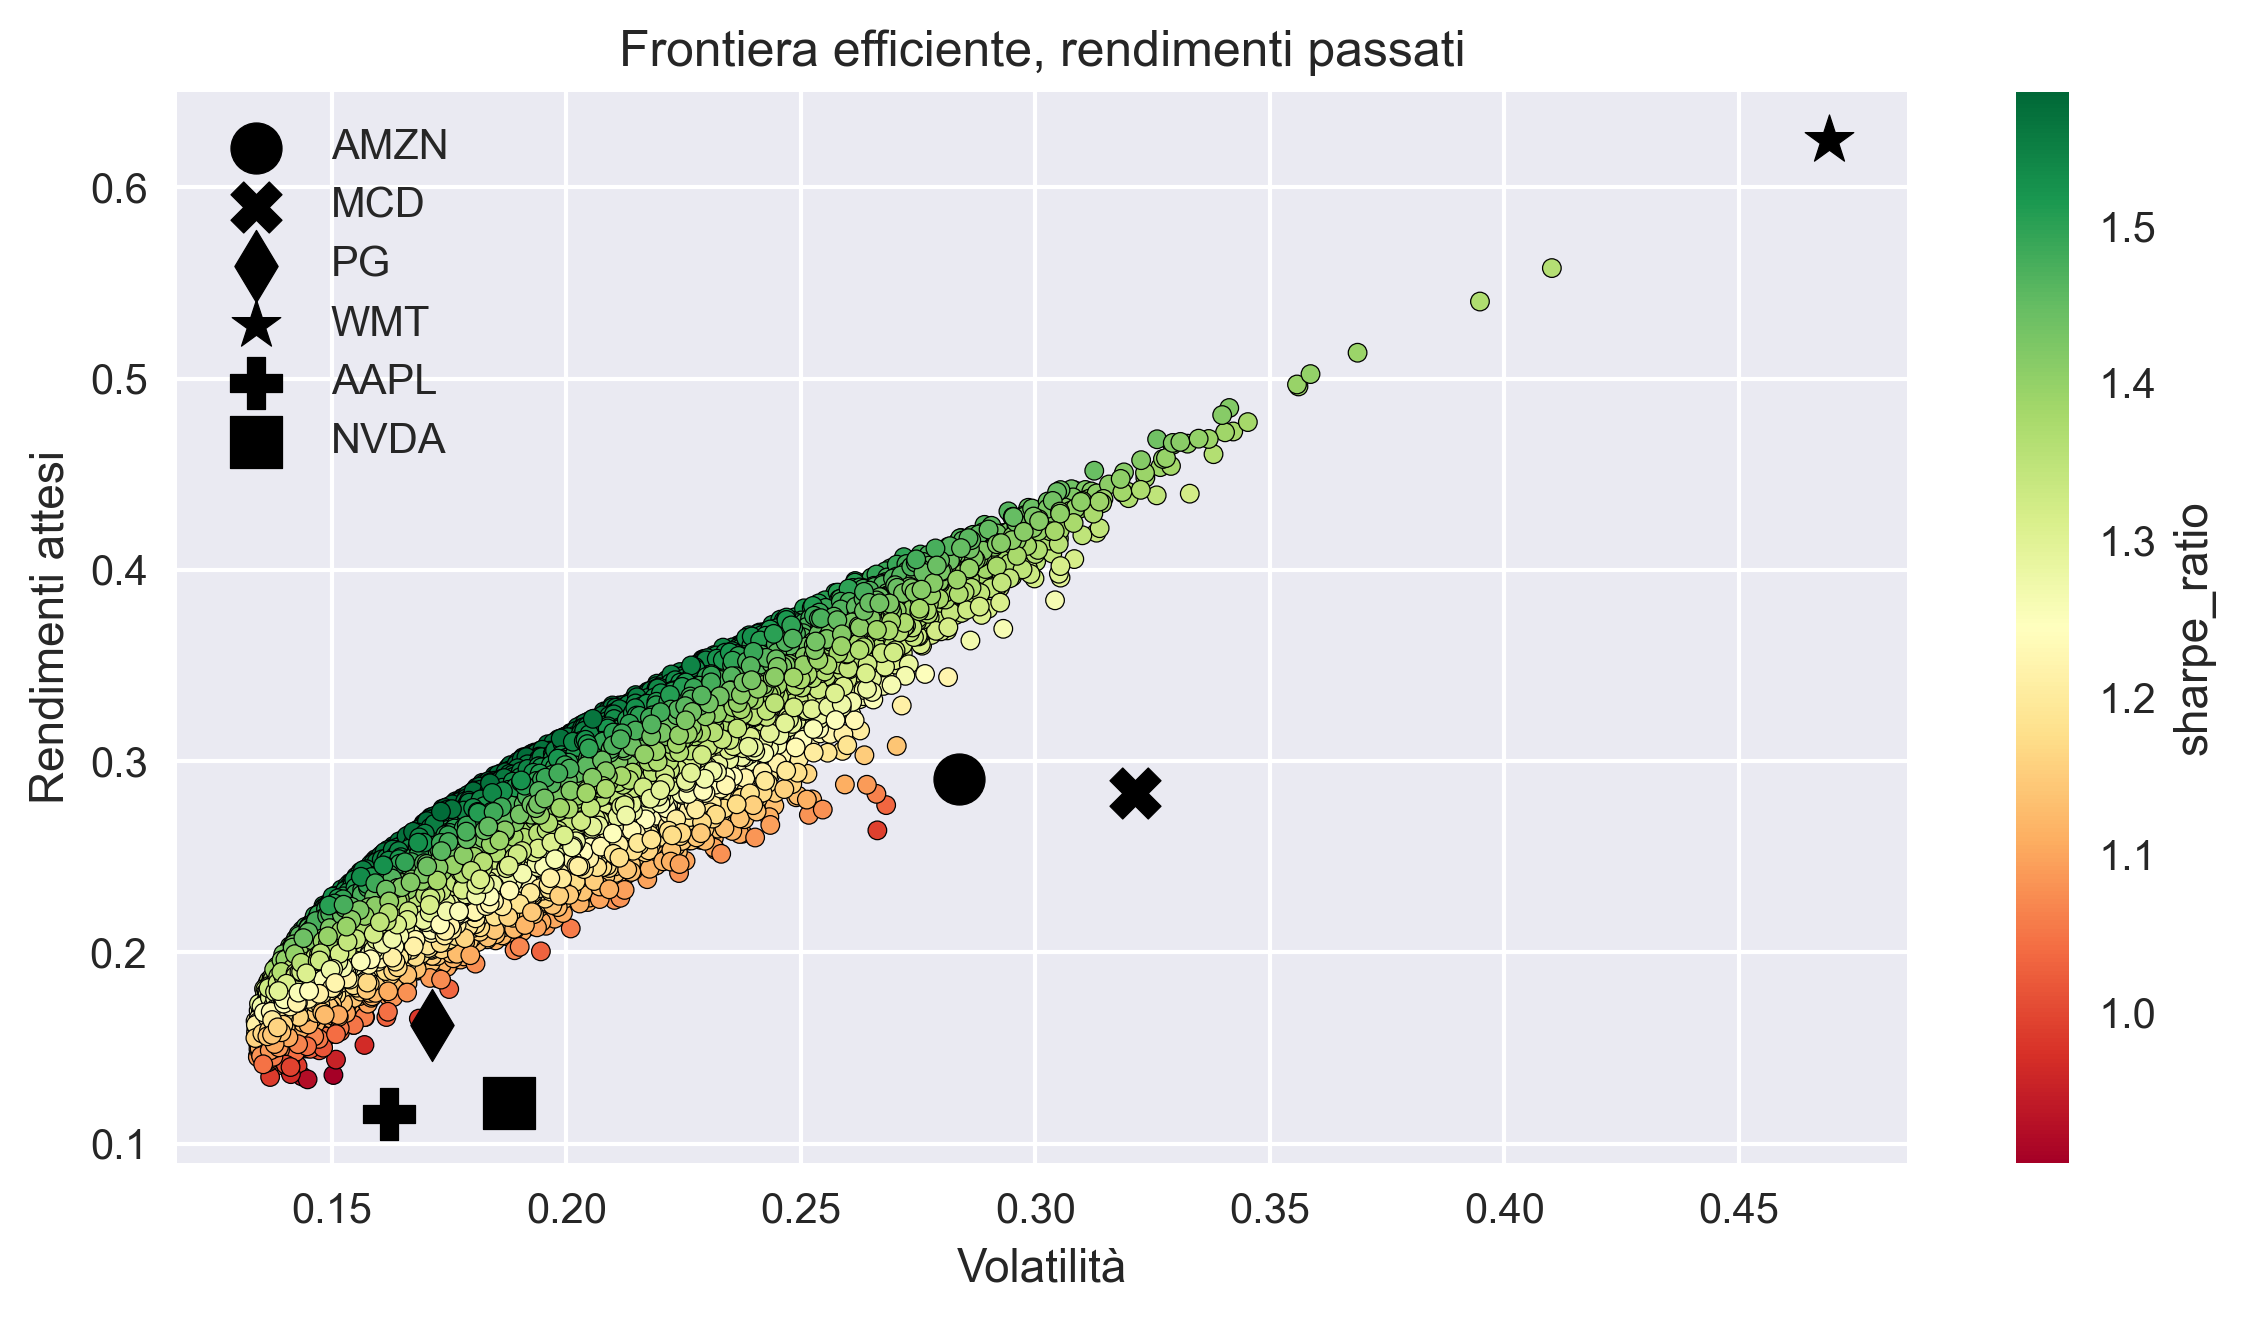

=== Portfolio con Sharpe Ratio massimo ===
Rendimento atteso:  0.2886734455058874
Volatilità:  0.18205733367010146
Sharpe Ratio:  1.5856183307011438 

Pesi portfolio con max SR
AMZN:  0.011826920248026741
MCD:  0.031556085785272255
PG:  0.35172911633463694
WMT:  0.2934370910921155
AAPL:  0.2994323066401027
NVDA:  0.012018479899845972
Beta portfolio con max SR rispetto al mercato
Beta:  1.3606445132195595
=== Portfolio con volatilità minima ===
Rendimento atteso:  0.1552703104091132
Volatilità:  0.13367835526073987
Sharpe Ratio:  1.1615216996518112 

=== Pesi portfolio con min volatility ===
AMZN:  0.014349652473928151
MCD:  0.06407092616946372
PG:  0.23824746599299798
WMT:  0.02854370389620882
AAPL:  0.49943305922173986
NVDA:  0.1553551922456614
Beta portfolio con min volatility rispetto al mercato
Beta:  1.3102150840932103
=== Portfolio con rendimento massimo ===
Rendimento atteso:  0.5577179671257035
Volatilità:  0.41010417754324896
Sharpe Ratio:  1.3599421748560157 

Pesi portfolio 

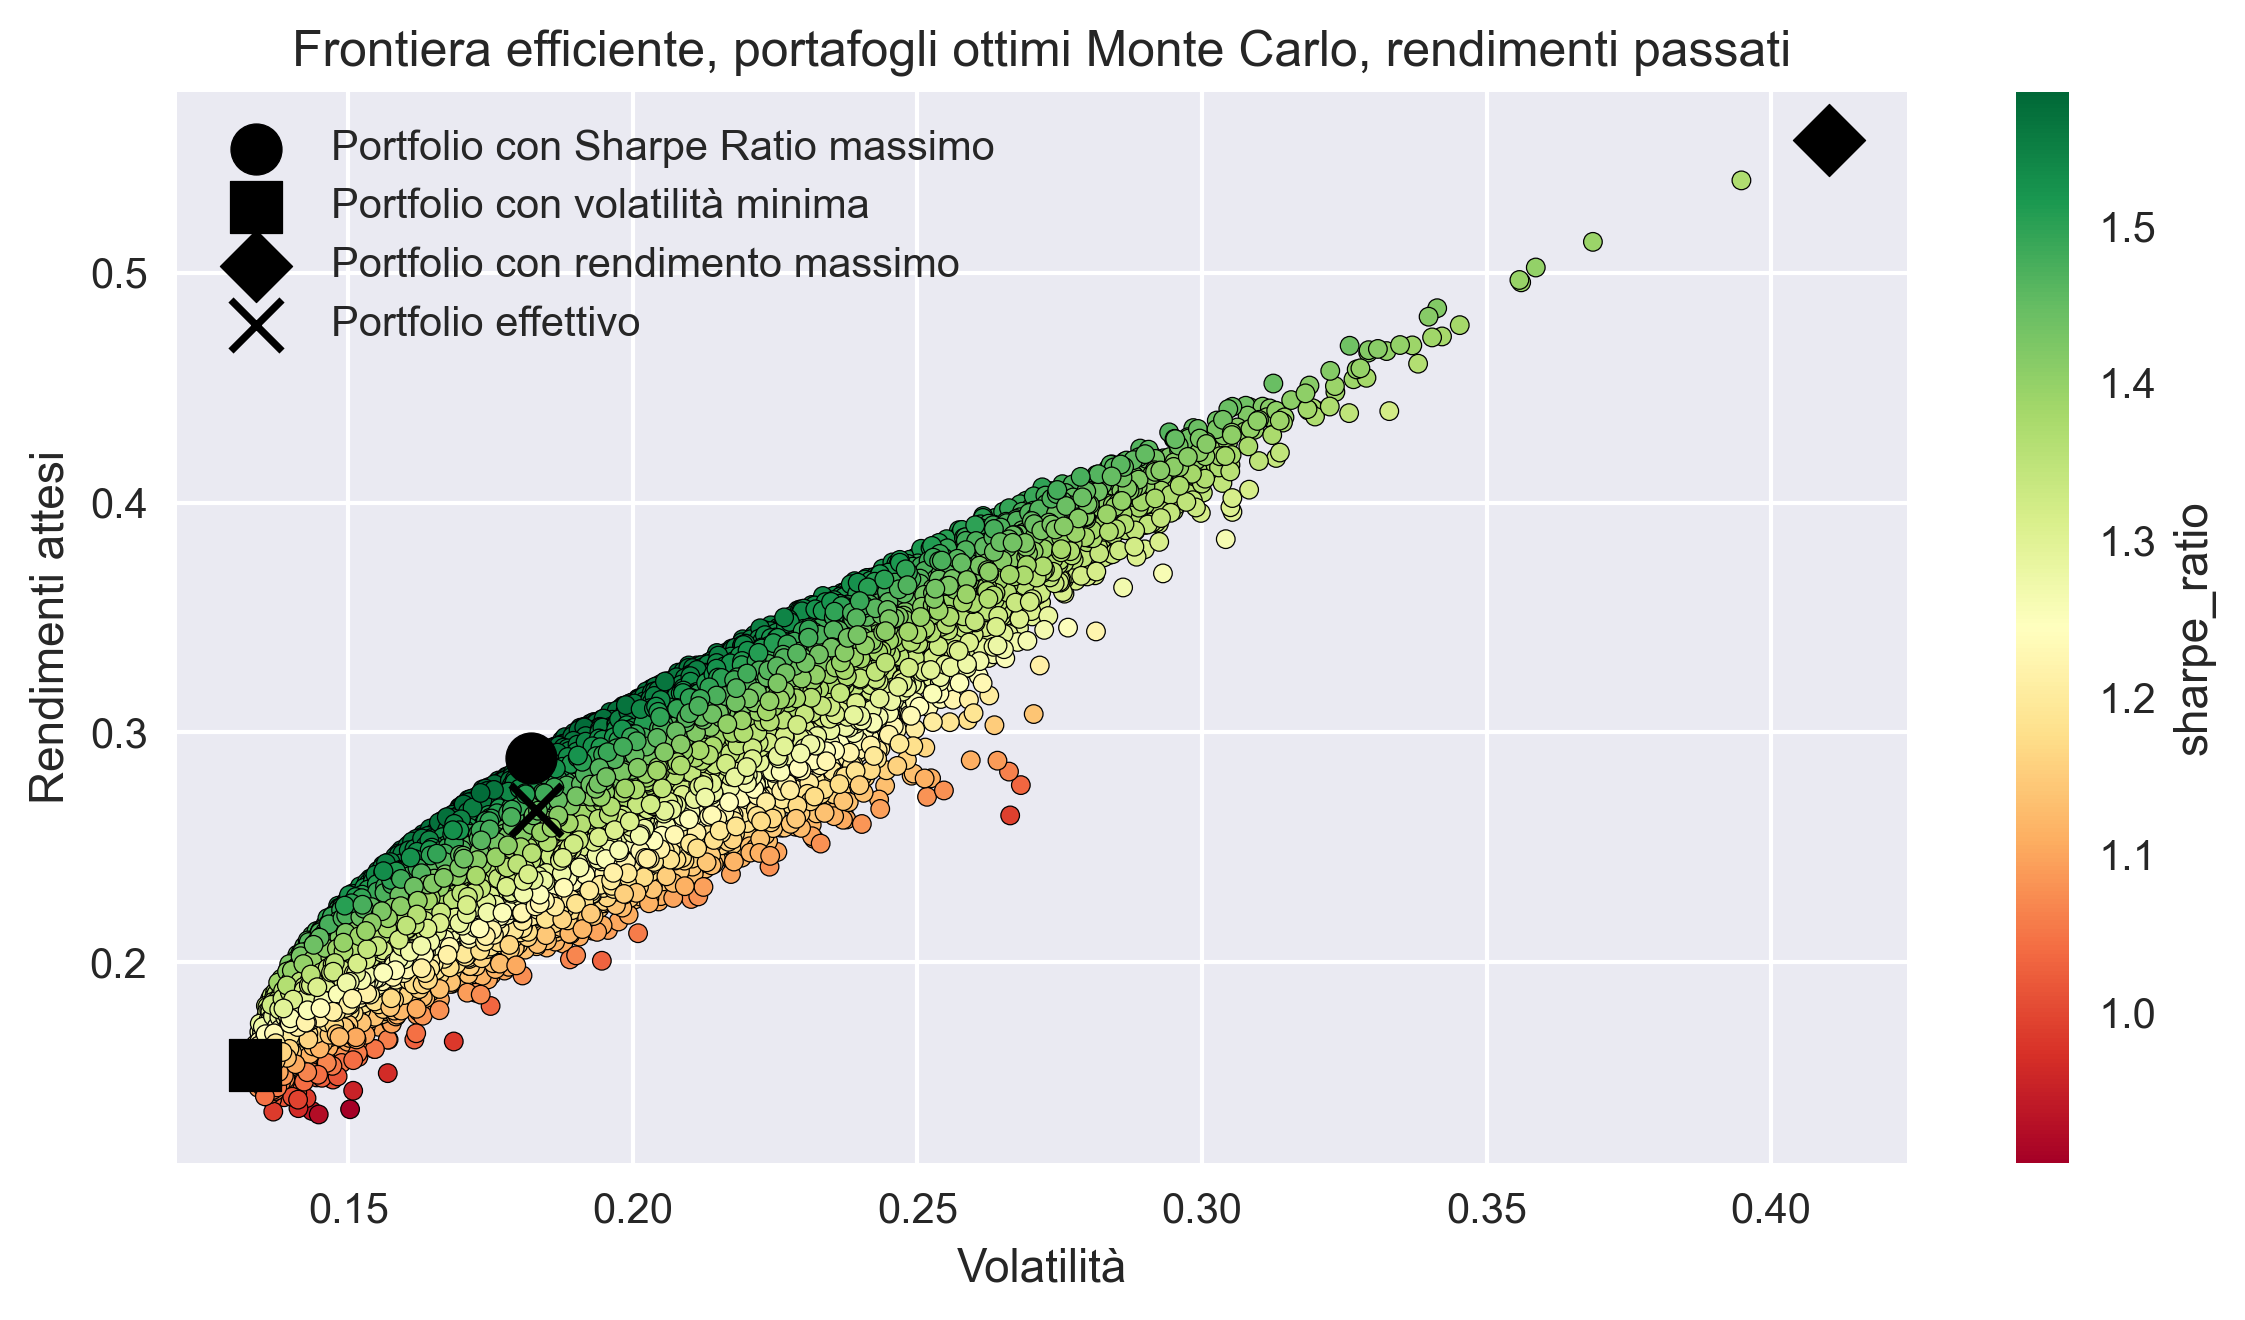

In [ ]:
# Calcola i rendimenti mensili e utilizza i primi 108 mesi di dati
monthly_returns = data.resample('M').ffill().pct_change().dropna()
returns_108_months = monthly_returns.iloc[:108]

# Rendimento atteso annuale
rendimento_atteso_annuo = {
    'AMZN': 0.0880,  
    'MCD': 0.0697,  
    'PG': 0.0631, 
    'WMT': 0.0645, 
    'AAPL': 0.0870,  
    'NVDA': 0.1033  
}
rendimenti_attesi = np.array(list(rendimento_atteso_annuo.values()))

# Metodo analitico: Portafoglio di Markowitz
def portafoglio_ottimale_analitico(rendimenti, rendimenti_attesi):
    cov_matrix = rendimenti.cov()
    num_assets = len(rendimenti.columns)
    
    def funzione_obiettivo(pesi):
        return np.dot(pesi.T, np.dot(cov_matrix, pesi))

    def rendimento_portafoglio(pesi):
        return np.sum(pesi * rendimenti_attesi)

    constraints = ({'type': 'eq', 'fun': lambda pesi: np.sum(pesi) - 1},
                   {'type': 'ineq', 'fun': lambda pesi: rendimento_portafoglio(pesi) - np.mean(rendimenti_attesi)})
    bounds = tuple((0, 1) for _ in range(num_assets))
    pesi_iniziali = num_assets * [1. / num_assets]

    risultato = minimize(funzione_obiettivo, pesi_iniziali, method='SLSQP', bounds=bounds, constraints=constraints)
    return risultato.x

pesi_ottimali_analitici = portafoglio_ottimale_analitico(returns_108_months, rendimenti_attesi)
print("Pesi ottimali (analitici):", pesi_ottimali_analitici)

# Metodo di simulazione: Monte Carlo
def portafoglio_ottimale_simulazione(rendimenti, rendimenti_attesi, num_simulazioni=10000):
    num_assets = len(rendimenti.columns)
    risultati = np.zeros((4, num_simulazioni))
    pesi_simulati = []

    for i in range(num_simulazioni):
        pesi = np.random.random(num_assets)
        pesi /= np.sum(pesi)
        rend_atteso = np.sum(pesi * rendimenti_attesi)
        varianza = np.dot(pesi.T, np.dot(rendimenti.cov(), pesi))
        std_dev = np.sqrt(varianza)
        sharpe_ratio = rend_atteso / std_dev
        
        risultati[0, i] = rend_atteso
        risultati[1, i] = std_dev
        risultati[2, i] = sharpe_ratio
        risultati[3, i] = varianza
        pesi_simulati.append(pesi)

    indice_miglior_sharpe = np.argmax(risultati[2])
    pesi_miglior_sharpe = pesi_simulati[indice_miglior_sharpe]
    
    return pesi_miglior_sharpe

pesi_ottimali_simulati = portafoglio_ottimale_simulazione(returns_108_months, rendimenti_attesi)
print("Pesi ottimali (simulazione):", pesi_ottimali_simulati)

# Calcolare il beta del portafoglio rispetto al mercato
betas = {
    'AMZN': 0.8942,
    'MCD': 1.8161,
    'PG': 1.6931,
    'WMT': 1.2131,
    'AAPL': 1.0882,
    'NVDA': 1.2844
}
beta_portafoglio_analitico = np.sum(np.array(list(betas.values())) * pesi_ottimali_analitici)
beta_portafoglio_simulato = np.sum(np.array(list(betas.values())) * pesi_ottimali_simulati)
print("Beta del portafoglio (analitico):", beta_portafoglio_analitico)
print("Beta del portafoglio (simulato):", beta_portafoglio_simulato)

# Confrontare il rendimento del portafoglio ottimale con quello effettivo
rendimenti_portafoglio_analitico = np.sum(returns_108_months * pesi_ottimali_analitici, axis=1)
rendimenti_portafoglio_simulato = np.sum(returns_108_months * pesi_ottimali_simulati, axis=1)
rendimenti_portafoglio_equamente_ponderato = np.mean(returns_108_months, axis=1)

# Calcolare il rendimento annualizzato, la volatilità annualizzata e lo Sharpe Ratio
def performance_metrics(rendimenti):
    rendimento_annuale = np.prod(1 + rendimenti) ** (12 / len(rendimenti)) - 1
    volatilita_annuale = np.std(rendimenti) * np.sqrt(12)
    sharpe_ratio = rendimento_annuale / volatilita_annuale
    return rendimento_annuale, volatilita_annuale, sharpe_ratio

# Calcolare le metriche di performance
rendimento_annuale_analitico, volatilita_annuale_analitica, sharpe_ratio_analitico = performance_metrics(rendimenti_portafoglio_analitico)
rendimento_annuale_simulato, volatilita_annuale_simulata, sharpe_ratio_simulato = performance_metrics(rendimenti_portafoglio_simulato)
rendimento_annuale_equamente_ponderato, volatilita_annuale_equamente_ponderata, sharpe_ratio_equamente_ponderato = performance_metrics(rendimenti_portafoglio_equamente_ponderato)

# Stampa delle metriche di performance
print(f"Portafoglio Ottimale (Analitico): Rendimento Annualizzato: {rendimento_annuale_analitico:.2%}, Volatilità Annualizzata: {volatilita_annuale_analitica:.2%}, Sharpe Ratio: {sharpe_ratio_analitico:.2f}")
print(f"Portafoglio Ottimale (Simulato): Rendimento Annualizzato: {rendimento_annuale_simulato:.2%}, Volatilità Annualizzata: {volatilita_annuale_simulata:.2%}, Sharpe Ratio: {sharpe_ratio_simulato:.2f}")
print(f"Portafoglio Equamente Ponderato: Rendimento Annualizzato: {rendimento_annuale_equamente_ponderato:.2%}, Volatilità Annualizzata: {volatilita_annuale_equamente_ponderata:.2%}, Sharpe Ratio: {sharpe_ratio_equamente_ponderato:.2f}")

# Confronto dei rendimenti cumulati
plt.figure(figsize=(10, 6))
plt.plot((1 + rendimenti_portafoglio_analitico).cumprod(), label='Portafoglio Ottimale (Analitico)')
plt.plot((1 + rendimenti_portafoglio_simulato).cumprod(), label='Portafoglio Ottimale (Simulato)')
plt.plot((1 + rendimenti_portafoglio_equamente_ponderato).cumprod(), label='Portafoglio Equamente Ponderato')
plt.title('Confronto dei Rendimenti dei Portafogli')
plt.xlabel('Data')
plt.ylabel('Valore del Portafoglio')
plt.legend()
plt.grid(True)
plt.show()

# Monte Carlo per rendimenti passati
n_portfolio = 10 ** 5
n_period = 12
n_assets = len(tickers)

# Matrice di covarianze e rendimenti medi
cov_mat = returns_108_months.cov() * n_period
avg_ret = returns_108_months.mean() * n_period

# Pesi casuali
np.random.seed(42)
weights = np.random.random(size=(n_portfolio, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

# Rendimenti del portafoglio
portfolio_rtn = np.dot(weights, avg_ret)

portfolio_vol = []
for i in range(len(weights)):
    portfolio_vol.append(np.sqrt(np.dot(weights[i].T, np.dot(cov_mat, weights[i]))))
portfolio_vol = np.array(portfolio_vol)  

# Risultati dei portafogli
portfolio_results_df = pd.DataFrame({'returns': portfolio_rtn,
                                     'volatility': portfolio_vol,
                                     'sharpe_ratio': portfolio_rtn / portfolio_vol})

# Visualizzazione della frontiera efficiente
plt.style.use('seaborn')
sns.set_palette('cubehelix')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300

MARKS = ['o', 'X', 'd', '*', 'P', 's']

fig, ax = plt.subplots()
portfolio_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',
                          cmap='RdYlGn', edgecolors='black', ax=ax)
ax.set(xlabel='Volatilità', ylabel='Rendimenti attesi', title='Frontiera efficiente, rendimenti passati')

for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), y=avg_ret[asset_index],
               marker=MARKS[asset_index], s=150, color='black', label=tickers[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

# Calcolo del miglior portafoglio per vari criteri
def print_portfolio(portfolio, msg):
    print("=== " + msg + " ===")
    print("Rendimento atteso: ", portfolio['returns'])
    print("Volatilità: ", portfolio['volatility'])
    print("Sharpe Ratio: ", portfolio['sharpe_ratio'], "\n")

# Max Sharpe Ratio
max_sr = np.argmax(portfolio_results_df.sharpe_ratio)
max_sr_portfolio = portfolio_results_df.loc[max_sr]
max_sr_weights = weights[np.argmax(portfolio_results_df.sharpe_ratio)]

print_portfolio(max_sr_portfolio, "Portfolio con Sharpe Ratio massimo")
print("Pesi portfolio con max SR")
for index in range(len(tickers)):
    print(tickers[index] + ": ", max_sr_weights[index])

beta_max_sr = np.dot(max_sr_weights, list(betas.values()))
print("Beta portfolio con max SR rispetto al mercato")
print("Beta: ", beta_max_sr)
# Min Volatility
min_vol = np.argmin(portfolio_results_df.volatility)
min_vol_portfolio = portfolio_results_df.loc[min_vol]
min_vol_weights = weights[np.argmin(portfolio_results_df.volatility)]

print_portfolio(min_vol_portfolio, "Portfolio con volatilità minima")
print("=== Pesi portfolio con min volatility ===")
for index in range(len(tickers)):
    print(tickers[index] + ": ", min_vol_weights[index])

beta_min_vol = np.dot(min_vol_weights, list(betas.values()))
print("Beta portfolio con min volatility rispetto al mercato")
print("Beta: ", beta_min_vol)


# Max Returns
max_ret = np.argmax(portfolio_results_df.returns)
max_ret_portfolio = portfolio_results_df.loc[max_ret]
max_ret_weights = weights[np.argmax(portfolio_results_df.returns)]

print_portfolio(max_ret_portfolio, "Portfolio con rendimento massimo")
print("Pesi portfolio con max returns")
for index in range(len(tickers)):
    print(tickers[index] + ": ", max_ret_weights[index])

beta_max_ret = np.dot(max_ret_weights, list(betas.values()))
print("Beta portfolio con max returns rispetto al mercato")
print("Beta: ", beta_max_ret)

# Portfolio effettivo (equally weighted)
weights = np.array([1/6] * n_assets)

eff_portfolio = dict()
eff_portfolio.update({'returns': np.dot(weights, avg_ret)})
eff_portfolio.update({'volatility': np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))})
eff_portfolio.update({'sharpe_ratio': eff_portfolio['returns'] / eff_portfolio['volatility']})

print_portfolio(eff_portfolio, "Portfolio effettivo")
beta_eff = np.dot(weights, list(betas.values()))
print("Beta: ", beta_eff)

# Visualizzazione dei portafogli ottimi
fig, ax = plt.subplots()
portfolio_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',
                          cmap='RdYlGn', edgecolors='black', ax=ax)

ax.scatter(x=max_sr_portfolio.volatility, y=max_sr_portfolio.returns, c='black', marker='o',
           s=150, label='Portfolio con Sharpe Ratio massimo')
ax.scatter(x=min_vol_portfolio.volatility, y=min_vol_portfolio.returns, c='black', marker='s',
           s=150, label='Portfolio con volatilità minima')
ax.scatter(x=max_ret_portfolio.volatility, y=max_ret_portfolio.returns, c='black', marker='D',
           s=150, label='Portfolio con rendimento massimo')
ax.scatter(x=eff_portfolio['volatility'], y=eff_portfolio['returns'], c='black', marker='x',
           s=150, label='Portfolio effettivo')

ax.set(xlabel='Volatilità', ylabel='Rendimenti attesi',
       title='Frontiera efficiente, portafogli ottimi Monte Carlo, rendimenti passati')
ax.legend()

plt.tight_layout()
plt.show()

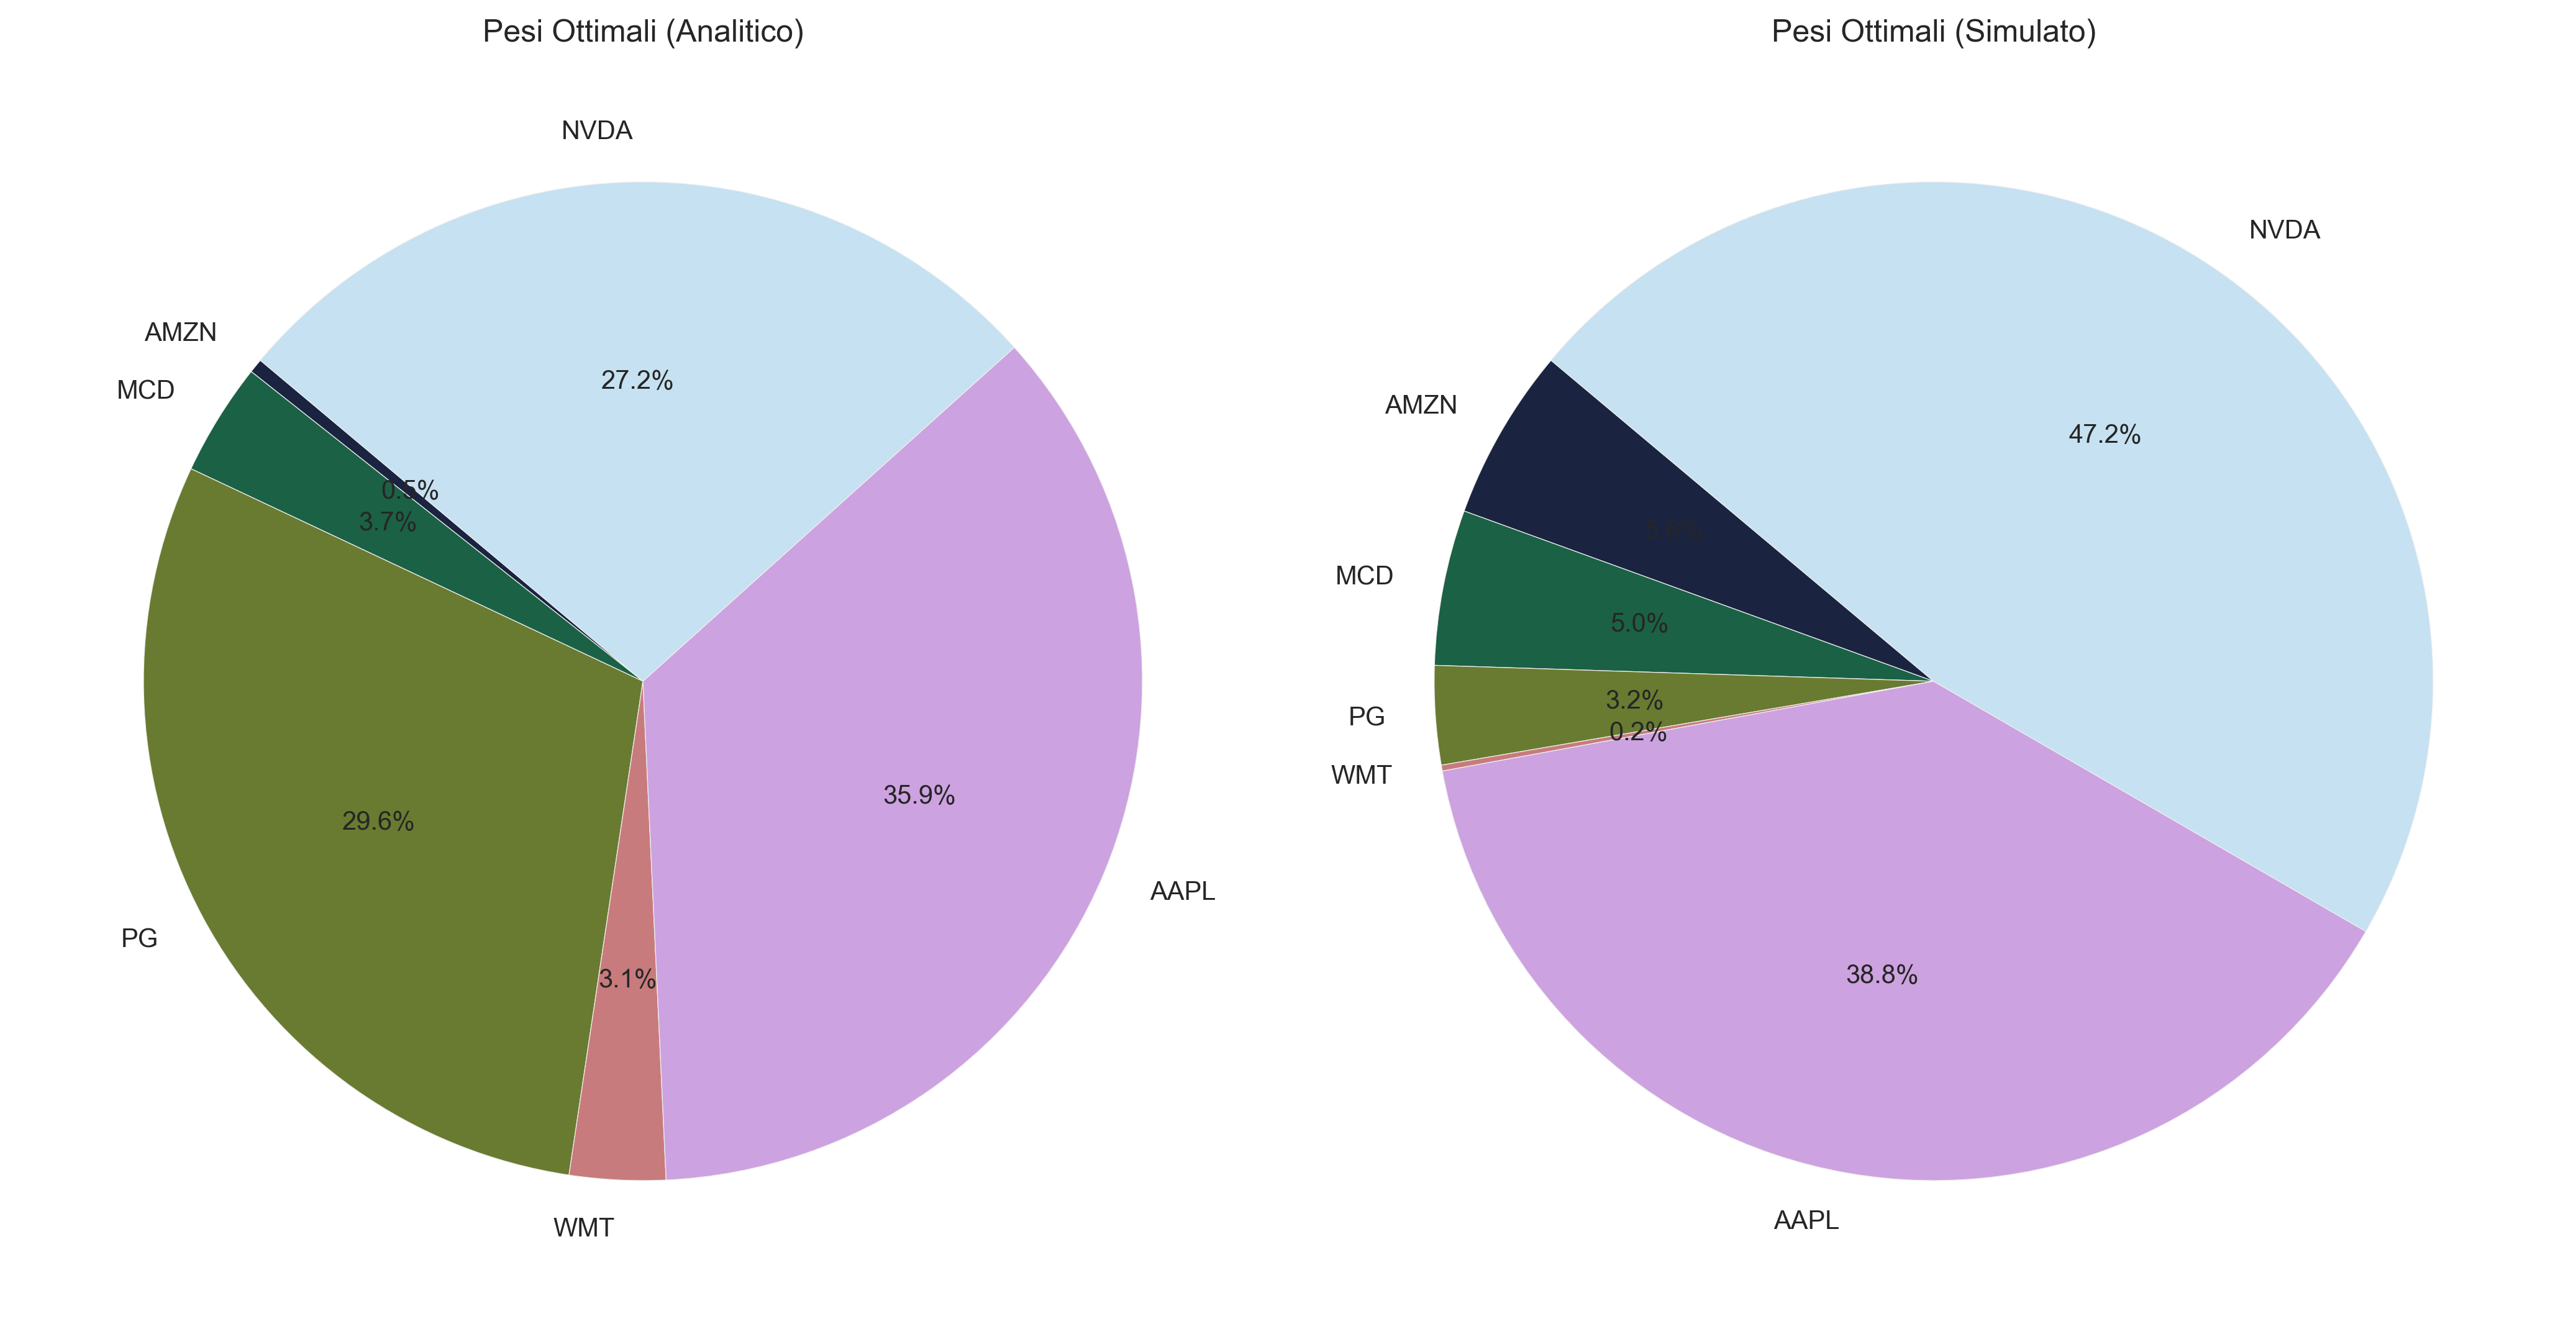

In [ ]:
# Dati per i pesi dei portafogli con ticker specifici
tickers = ["AMZN", "MCD", "PG", "WMT", "AAPL", "NVDA"]
weights_analytical = [0.00461964, 0.03651997, 0.29631854, 0.0310548, 0.3591565, 0.27233055]
weights_simulated = [0.05573324, 0.05030449, 0.03195376, 0.00190853, 0.38769035, 0.47240964]

# Creazione dei grafici a torta con i ticker
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].pie(weights_analytical, labels=tickers, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Pesi Ottimali (Analitico)')
axes[1].pie(weights_simulated, labels=tickers, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Pesi Ottimali (Simulato)')

plt.tight_layout()
plt.show()
